In [1]:
import pandas as pd
import os
import glob
from datetime import datetime

# 1. LOAD FILE LIST
# If you saved the CSV from the previous step:
# df = pd.read_csv("mea_file_locations.csv")

# OR, if you want to run it fresh right now:
root_search_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/"
files = glob.glob(os.path.join(root_search_path, "**", "*network*.json"), recursive=True)
df = pd.DataFrame(files, columns=['full_path'])

def parse_path_metadata(path):
    """
    Extracts metadata from the standard path structure:
    .../AnalyzedData/Genotype/Date/ChipID/Network/RunID/WellID/...
    """
    try:
        parts = path.split(os.sep)
        
        # We anchor everything relative to "AnalyzedData" to be safe
        if "AnalyzedData" in parts:
            idx = parts.index("AnalyzedData")
            
            # Extract based on your specific directory depth
            project = parts[idx + 1]  # e.g., CDKL5_T1
            date_str = parts[idx + 2]  # e.g., 240531
            chip_id  = parts[idx + 3]  # e.g., M07420
            # parts[idx + 4] is usually "Network"
            run_id   = parts[idx + 5]  # e.g., 000052
            well_id  = parts[idx + 6]  # e.g., well005
            
            return pd.Series([project, date_str, chip_id, run_id, well_id])
        else:
            return pd.Series([None, None, None, None, None])
            
    except IndexError:
        return pd.Series([None, None, None, None, None])

# 2. APPLY EXTRACTION
print(" dissecting path names...")
metadata_cols = ["Project", "Date", "ChipID", "RunID", "WellID"]
df[metadata_cols] = df['full_path'].apply(parse_path_metadata)
#puth full_path to last column
df = df[[col for col in df.columns if col != 'full_path'] + ['full_path']]


# 4. REVIEW
print(f"Successfully dissected {len(df)} paths.")
print("\nSnapshot of extracted metadata:")
df.head()

# 5. SAVE
#df.to_csv("/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/mea_metadata_index.csv", index=False)

 dissecting path names...
Successfully dissected 338 paths.

Snapshot of extracted metadata:


Project    Date  ChipID   RunID   WellID  \
0  KCNT1_M1Plus_T1_01142026_PVS  260120  M08068  000019  well005   
1  KCNT1_M1Plus_T1_01142026_PVS  260120  M08068  000019  well003   
2  KCNT1_M1Plus_T1_01142026_PVS  260120  M08068  000019  well002   
3  KCNT1_M1Plus_T1_01142026_PVS  260120  M08068  000019  well000   
4  KCNT1_M1Plus_T1_01142026_PVS  260120  M08068  000019  well001   

                                           full_path  
0  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  
1  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  
2  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  
3  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  
4  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...

In [2]:
import json
import pandas as pd

# 1. Select the first file from our dissected dataframe
# We use .iloc[0] to grab the first row
sample_path = df.iloc[0]['full_path']
#print(f"Inspecting file: {sample_path}\n")
#sample_path = '/pscratch/sd/m/mpatil1/MEA_Analysis/AnalyzedData/CDKL5_T1/240531/M07420/Network/000052/well004/network_results.json'
# 2. Load the JSON data
with open(sample_path, 'r') as f:
    data = json.load(f)

# 3. Helper function to print the structure without flooding the screen
# This will show you the Keys and the Type of data inside (e.g., float, list of 6000 items)
def print_structure(d, indent=0):
    spacing = "  " * indent
    if isinstance(d, dict):
        for key, value in d.items():
            if isinstance(value, dict):
                print(f"{spacing}- {key}: (Nested Dictionary)")
                print_structure(value, indent + 1)
            elif isinstance(value, list):
                print(f"{spacing}- {key}: List [{len(value)} items]")
            else:
                print(f"{spacing}- {key}: {type(value).__name__} (e.g., {value})")
    else:
        print(f"{spacing} (Not a dictionary)")

# 4. Print the "Map" of your JSON
print("--- JSON FILE STRUCTURE ---")
print_structure(data)

# 5. Check for specific "Gold Mine" keys
# These are the standard keys usually found in MaxWell/MACS outputs.
# We try to print them specifically to see if they exist.
print("\n--- CHECKING FOR COMMON METRICS ---")
possible_keys = ['bursts', 'isis_within', 'isis_outside', 'isis_all']

found_metrics = {}
for key in possible_keys:
    # Check top level
    if key in data:
        found_metrics[key] = data[key]
    # Sometimes metrics are hidden inside a 'summary' or 'network' sub-dictionary
    elif 'summary' in data and key in data['summary']:
        found_metrics[key] = data['summary'][key]

print(f"Found specific metrics: {json.dumps(found_metrics, indent=2)}")

--- JSON FILE STRUCTURE ---
- burstlets: (Nested Dictionary)
  - events: List [34 items]
  - metrics: (Nested Dictionary)
    - count: int (e.g., 34)
    - rate: float (e.g., 0.1133195461218885)
    - duration: (Nested Dictionary)
      - mean: float (e.g., 0.5858823529411767)
      - std: float (e.g., 0.30107764922865515)
      - cv: float (e.g., 0.5138875539043308)
    - inter_event_interval: (Nested Dictionary)
      - mean: float (e.g., 8.19909090909091)
      - std: float (e.g., 9.661610494910875)
      - cv: float (e.g., 1.1783758226413086)
    - intensity: (Nested Dictionary)
      - mean: float (e.g., 65.8337421543017)
      - std: float (e.g., 66.70158146795234)
      - cv: float (e.g., 1.0131822874600775)
    - participation: (Nested Dictionary)
      - mean: float (e.g., 0.5351513709629454)
      - std: float (e.g., 0.22017151471906887)
      - cv: float (e.g., 0.41141913609021447)
    - spikes_per_burst: (Nested Dictionary)
      - mean: float (e.g., 3333.705882352941)
    

In [3]:
data['aggregates']

KeyError: 'aggregates'

In [5]:
import numpy as np
# ONLY USED FOR OLD NETWORK JSONS, BEFORE DECEMBER 10th 2025 
def extract_metrics(row):
    path = row['full_path']
    
    metrics = {
        "nb_count": np.nan,
        "nb_rate_hz": np.nan,
        "nb_duration_mean_s": np.nan,
        "nb_ibi_mean_s": np.nan,
        "nb_spikes_per_burst_mean": np.nan,
        "nb_energy_mean": np.nan,
    }
    
    try:
        with open(path, 'r') as f:
            data = json.load(f)
        
        # Get recording duration
        rec_duration = data.get('recording_end', 0) - data.get('recording_start', 0)
        
        # Extract from aggregates → network_level
        if 'aggregates' in data and 'network_level' in data['aggregates']:
            nl = data['aggregates']['network_level']
            
            metrics["nb_count"] = nl.get('count')
            metrics["nb_duration_mean_s"] = nl.get('mean_duration')
            metrics["nb_spikes_per_burst_mean"] = nl.get('mean_total_spikes')
            
            # Calculate rate
            if metrics["nb_count"] is not None and rec_duration > 0:
                metrics["nb_rate_hz"] = metrics["nb_count"] / rec_duration
        
        # Extract from network_bursts list
        if 'network_bursts' in data and len(data['network_bursts']) > 0:
            nb_list = data['network_bursts']
            
            # Extract burst energy
            energies = [b.get('burst_energy') for b in nb_list if b.get('burst_energy') is not None]
            if energies:
                metrics["nb_energy_mean"] = np.nanmean(energies)
            
            # Calculate IBI from start times
            starts = [b.get('start') for b in nb_list if b.get('start') is not None]
            if len(starts) > 1:
                ibis = [starts[i+1] - starts[i] for i in range(len(starts)-1)]
                metrics["nb_ibi_mean_s"] = np.nanmean(ibis)
            
            # PSIB calculation (if you want to calculate it yourself)
            # Would need total spikes across entire recording from all units
            # This would require processing unit_bursts data which is complex
                    
    except Exception as e:
        print(f"Error reading {path}: {e}")
    
    return pd.Series(metrics)
# 2. APPLY EXTRACTION
print(" extracting burst metrics from JSON files...")
burst_metrics = df.apply(extract_metrics, axis=1) 
print(burst_metrics.head())  

 extracting burst metrics from JSON files...
   nb_count  nb_rate_hz  nb_duration_mean_s  nb_ibi_mean_s  \
0      93.0    0.309918            0.557957       3.194891   
1     195.0    0.649827            0.436205       1.526392   
2      89.0    0.296588            0.608989       3.359432   
3     114.0    0.379899            0.498070       2.585487   
4     118.0    0.393229            0.510254       2.535897   

   nb_spikes_per_burst_mean  nb_energy_mean  
0              15612.580645    10165.029947  
1              15768.743590     3361.170488  
2              51845.415730    12022.224534  
3              22907.052632     4220.042003  
4              13586.440678     6004.124364  


In [6]:
# FOR NEWER NETWORK JSONS, HAS NETWORK_STATS 
import json
import pandas as pd
import numpy as np
# Optional: Use tqdm for a progress bar if installed, otherwise regular loop
try:
    from tqdm import tqdm
    tqdm.pandas()
    iterable = tqdm(df.iterrows(), total=len(df), desc="Extracting Metrics")
except ImportError:
    iterable = df.iterrows()
    print("Extracting metrics (install 'tqdm' for a progress bar)...")

# --- 1. DEFINE EXTRACTION LOGIC ---
def extract_metrics(row):
    path = row['full_path']
    
    # Initialize default values (NaN) in case file is empty/corrupt
    metrics = {
        "nb_count": np.nan,
        "nb_rate_hz": np.nan,
        "nb_duration_mean_s": np.nan,        # Duration is usually in seconds
        "nb_ibi_mean_s": np.nan,             # Inter-Burst Interval
        "nb_spikes_per_burst_mean": np.nan,
        "nb_energy_mean": np.nan,            # Often informative for connectivity
    }

    try:
        with open(path, 'r') as f:
            data = json.load(f)
        
        # Access the specific nested keys you identified
        # We use .get() to avoid crashing if a specific key is missing
        if 'network_stats' in data:
            ns = data['network_stats']
            
            metrics["nb_count"] = ns.get('count')
            metrics["nb_rate_hz"] = ns.get('rate_hz')
            
            # Nested: Duration
            if 'duration' in ns:
                metrics["nb_duration_mean_s"] = ns['duration'].get('mean')
            
            # Nested: IBI
            if 'inter_burst_interval' in ns:
                metrics["nb_ibi_mean_s"] = ns['inter_burst_interval'].get('mean')
                
            # Nested: Intensity (Energy, Spikes, PSIB)
            if 'intensity' in ns:
                inte = ns['intensity']
                metrics["psib"] = inte.get('psib')
                
                if 'spikes' in inte:
                    metrics["nb_spikes_per_burst_mean"] = inte['spikes'].get('mean')
                if 'energy' in inte:
                    metrics["nb_energy_mean"] = inte['energy'].get('mean')

    except Exception as e:
        print(f"Error reading {path}: {e}")
        
    return pd.Series(metrics)

# --- 2. RUN EXTRACTION ---
# We apply the function to every row in your existing DataFrame
# and join the new columns to the right side of the metadata
print("Starting extraction...")
df_metrics = df.apply(extract_metrics, axis=1)
burst_metrics = pd.concat([df, df_metrics], axis=1)

# --- 3. CLEAN UP & SAVE ---
# Convert DIV to numeric if it exists, drop rows where extraction failed completely (optional)
# final_df.dropna(subset=['nb_rate_hz'], inplace=True) 

print(f"\nExtraction complete. Dataframe shape: {burst_metrics.shape}")
print(burst_metrics[['Project', 'ChipID', 'nb_rate_hz', 'nb_duration_mean_s']].head())
burst_metrics 
# Save the Master Table
#output_csv = "/pscratch/sd/m/mpatil1/MEA_Analysis/IPNAnalysis/workbooks/Network_Analysis_Master.csv"
#final_df.to_csv(output_csv, index=False)
#print(f"Master table saved to: {output_csv}")

Extracting Metrics:   0%|          | 0/53 [00:00<?, ?it/s]

Starting extraction...

Extraction complete. Dataframe shape: (53, 12)
                           Project  ChipID  nb_rate_hz  nb_duration_mean_s
0  B6J_PSYCHEDELICS_T1_11252025_PS  M08034         NaN                 NaN
1  B6J_PSYCHEDELICS_T1_11252025_PS  M08034         NaN                 NaN
2  B6J_PSYCHEDELICS_T1_11252025_PS  M08034         NaN                 NaN
3  B6J_PSYCHEDELICS_T1_11252025_PS  M08034         NaN                 NaN
4  B6J_PSYCHEDELICS_T1_11252025_PS  M08034         NaN                 NaN


Project    Date  ChipID   RunID   WellID  \
0   B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000073  well005   
1   B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000073  well003   
2   B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000073  well002   
3   B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000073  well000   
4   B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000073  well001   
5   B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000073  well004   
6   B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000079  well003   
7   B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000079  well002   
8   B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000079  well000   
9   B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000079  well001   
10  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000079  well004   
11  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000074  well005   
12  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000074  well003   
13  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000074  well002   
14  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000074  well000   
15  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000074  well001   
16  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08034  000074  well004   
17  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000085  well005   
18  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000085  well003   
19  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000085  well002   
20  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000085  well000   
21  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000085  well001   
22  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000085  well004   
23  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000098  well005   
24  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000098  well003   
25  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000098  well002   
26  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000098  well000   
27  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000098  well001   
28  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000098  well004   
29  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000097  well005   
30  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000097  well003   
31  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000097  well002   
32  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000097  well000   
33  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000097  well001   
34  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000097  well004   
35  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000086  well005   
36  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000086  well003   
37  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000086  well002   
38  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000086  well000   
39  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000086  well001   
40  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000086  well004   
41  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000084  well005   
42  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000084  well003   
43  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000084  well002   
44  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000084  well000   
45  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000084  well001   
46  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000084  well004   
47  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000087  well005   
48  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000087  well003   
49  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000087  well002   
50  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000087  well000   
51  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000087  well001   
52  B6J_PSYCHEDELICS_T1_11252025_PS  251212  M08029  000087  well004   

                                            full_path  nb_count  nb_rate_hz  \
0   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...       

In [10]:
import json

# Load one sample file
sample_path = df.iloc[0]['full_path']
print(f"Checking file: {sample_path}\n")

with open(sample_path, 'r') as f:
    data = json.load(f)

# Print all top-level keys
print("Top-level keys in JSON:")
print(data.keys())
print()

# Check if 'network_stats' exists
if 'network_stats' in data:
    print("✓ 'network_stats' found")
    print("Keys inside network_stats:")
    print(data['network_stats'].keys())
else:
    print("✗ 'network_stats' NOT found")
    print("\nLet's see what IS in the file:")
    for key in data.keys():
        print(f"  - {key}: {type(data[key])}")

Checking file: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/Media_Density_T2_04142025_AR/Media_Density_Experiment_T2_04142025_AR/250421/M08024/Network/000029/well005/network_data.json

Top-level keys in JSON:
dict_keys(['recording_start', 'recording_end', 'params', 'diagnostics', 'unit_bursts', 'burstlets', 'network_bursts', 'superbursts', 'aggregates', 'NumUnits', 'fileName'])

✗ 'network_stats' NOT found

Let's see what IS in the file:
  - recording_start: <class 'float'>
  - recording_end: <class 'float'>
  - params: <class 'dict'>
  - diagnostics: <class 'dict'>
  - unit_bursts: <class 'dict'>
  - burstlets: <class 'list'>
  - network_bursts: <class 'list'>
  - superbursts: <class 'list'>
  - aggregates: <class 'dict'>
  - NumUnits: <class 'int'>
  - fileName: <class 'str'>


In [9]:
# FOR OLD JSON 

# Run extraction
print("Starting extraction...")
df_metrics = df.apply(extract_metrics, axis=1)
final_df = pd.concat([df, df_metrics], axis=1)

print(f"\nExtraction complete. Dataframe shape: {final_df.shape}")
print("\nSample of extracted metrics:")
print(final_df[['Project', 'ChipID', 'WellID', 'nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_spikes_per_burst_mean']].head(10))

# Check for NaN values
print("\n=== NaN Check ===")
for col in ['nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s', 'nb_spikes_per_burst_mean', 'nb_energy_mean']:
    nan_count = final_df[col].isna().sum()
    print(f"{col}: {nan_count} NaN values ({nan_count/len(final_df)*100:.1f}%)")

Starting extraction...


NameError: name 'np' is not defined

In [8]:
def extract_metrics(row):
    path = row['full_path']
    
    metrics = {
        "nb_count": np.nan,
        "nb_rate_hz": np.nan,
        "nb_duration_mean_s": np.nan,
        "nb_ibi_mean_s": np.nan,
        "nb_spikes_per_burst_mean": np.nan,
        "nb_energy_mean": np.nan,
        "psib": np.nan
    }
    
    try:
        with open(path, 'r') as f:
            data = json.load(f)
        
        # NEW STRUCTURE: Check for 'aggregates' → 'network_level'
        if 'aggregates' in data and 'network_level' in data['aggregates']:
            nl = data['aggregates']['network_level']
            
            metrics["nb_count"] = nl.get('count')
            metrics["nb_duration_mean_s"] = nl.get('mean_duration')
            # Note: rate_hz might need to be calculated
            # If you have recording duration, rate = count / duration
            
        # For network bursts list
        if 'network_bursts' in data:
            nb_list = data['network_bursts']
            
            if len(nb_list) > 0:
                # Extract metrics from the list of bursts
                durations = [b.get('duration', np.nan) for b in nb_list if 'duration' in b]
                spikes = [b.get('total_spikes', np.nan) for b in nb_list if 'total_spikes' in b]
                
                if durations:
                    metrics["nb_duration_mean_s"] = np.nanmean(durations)
                if spikes:
                    metrics["nb_spikes_per_burst_mean"] = np.nanmean(spikes)
                
                # Calculate IBI (inter-burst interval)
                starts = [b.get('start', np.nan) for b in nb_list if 'start' in b]
                if len(starts) > 1:
                    ibis = [starts[i+1] - starts[i] for i in range(len(starts)-1)]
                    metrics["nb_ibi_mean_s"] = np.nanmean(ibis)
        
        # Calculate rate if we have count and recording duration
        if 'recording_end' in data and 'recording_start' in data:
            rec_duration = data['recording_end'] - data['recording_start']
            if metrics["nb_count"] and rec_duration > 0:
                metrics["nb_rate_hz"] = metrics["nb_count"] / rec_duration
                
    except Exception as e:
        print(f"Error reading {path}: {e}")
    
    return pd.Series(metrics)

In [6]:
ref_df = pd.read_csv("/home/shruti/Downloads/MaxTwo_MEA Tracking Sheets_Sep2024 onwards_AR(Media Density Exp_T2_04142025).csv")
print(ref_df.columns)


# --- 2. TRANSFORMATION LOGIC ---

# Step A: Split the strings into actual Python lists
# We split by comma and implicitly handle the 1:1 mapping
ref_df['Wells_List'] = ref_df['Wells_Recorded'].astype(str).str.split(',')
ref_df['Source_List'] = ref_df['Neuron Source'].astype(str).str.split(',')
print(ref_df[['Wells_Recorded', 'Wells_List', 'Neuron Source', 'Source_List']].head())
# Step B: Explode the lists into rows
# Pandas >= 1.3.0 allows exploding multiple columns simultaneously to keep them aligned
# This is crucial so Index 0 of Wells stays with Index 0 of Source
exploded_df = ref_df.explode(['Wells_List', 'Source_List'])
# Step C: Cleanup
# Remove whitespace that might exist in the strings (e.g., " MxWT" -> "MxWT")
exploded_df['Well_Num'] = exploded_df['Wells_List'].str.strip()
exploded_df['Neuron Source'] = exploded_df['Source_List'].str.strip()
# Step D: Create a "Match Key" for merging with your JSON results
# Your files are named like 'well005', so we format the number '5' -> 'well005'

#exploded_df['WellID'] = 'well' + exploded_df['Well_Num'].str.zfill(3)

# Step D: FIXED - Convert from 1-indexed to 0-indexed
exploded_df['Well_Num_Int'] = pd.to_numeric(exploded_df['Well_Num'], errors='coerce') - 1
exploded_df = exploded_df.dropna(subset=['Well_Num_Int'])  # Remove any NaN
exploded_df['WellID'] = 'well' + exploded_df['Well_Num_Int'].astype(int).astype(str).str.zfill(3)

# Filter to keep only the clean columns
clean_ref_df = exploded_df[['Date', 'ID', 'Run #','WellID', 'Neuron Source', 'Assay', 'DIV']]

# --- 3. VIEW RESULTS ---
print(f"Transformation complete.")
print(f"Original rows: {len(ref_df)}")
print(f"Exploded rows: {len(clean_ref_df)}")
print("\nFirst 10 rows of clean metadata:")
print(clean_ref_df.head(10))

# Save this for the next step
#clean_ref_df.to_csv("clean_metadata_map.csv", index=False)

Index(['Date', 'DIV', 'Assay', 'Run #', 'ID', 'Wells_Recorded',
       'Neuron Source', 'Scan Details', 'Patterning- YES/NO', 'Notes',
       'Recording Settings Overview', 'Unnamed: 11', '# of chips', 'Plate #',
       'Plate ID', 'Well #', 'Genotype', 'Plating Method', 'Avg. Raw Counts',
       'Avg. Cell Density/chip', 'Cell Counter Settings', 'Media',
       'Plated Date', 'Breeding Pairs', 'Plated By', 'Notes.1',
       'General Experiment Notes:', 'Recorded By', 'Date.1', 'DIV.1',
       'M08035- P1W1', 'M08035- P1W2', 'M08035- P1W3', 'M08035- P1W4',
       'M08035- P1W5', 'M08035- P1W6', 'M08018- P2W1', 'M08018- P2W2',
       'M08018- P2W3', 'M08018- P2W4', 'M08018- P2W5', 'M08018- P2W6',
       'M08024- P4W1', 'M08024- P4W2', 'M08024- P4W3', 'M08024- P4W4',
       'M08024- P4W5', 'M08024- P4W6'],
      dtype='object')
  Wells_Recorded          Wells_List  \
0    1,2,3,4,5,6  [1, 2, 3, 4, 5, 6]   
1    1,2,3,4,5,6  [1, 2, 3, 4, 5, 6]   
2    1,2,3,4,5,6  [1, 2, 3, 4, 5, 6]   
3 

In [19]:
# First, check what columns are in df (the one with file paths)
print("Columns in df (with file paths):")
print(df.columns.tolist())
print(f"\ndf shape: {df.shape}")
print("\nFirst few rows of df:")
print(df.head())

# You need to create matching keys in df to merge with clean_ref_df
# Based on your file paths, extract Date, ID, Run #, and WellID
# This will depend on how your 'full_path' is structured
# For example, if path is like: /path/to/M08035/run1/well000/network.json

# Assuming df already has these columns (ChipID, WellID, etc.), merge like this:
merged_df = clean_ref_df.merge(
    df,
    on=['Date', 'ChipID', 'RunID', 'WellID'],
    how='left',  # Keep ALL rows from clean_ref_df
    indicator=True  # This shows which rows matched
)

print(f"\nMerged df shape: {merged_df.shape}")
print(f"\nMerge indicator counts:")
print(merged_df['_merge'].value_counts())
print(f"\nDIVs in merged_df: {sorted(merged_df['DIV'].unique())}")

# Now extract metrics from the merged dataframe
print("\nExtracting burst metrics from JSON files...")
df_metrics = merged_df.apply(extract_metrics, axis=1)

# Combine everything
final_df = pd.concat([merged_df, df_metrics], axis=1)

print(f"\nFinal shape: {final_df.shape}")
print(f"DIVs in final_df: {sorted(final_df['DIV'].unique())}")
print(f"\nDIV counts:")
print(final_df['DIV'].value_counts().sort_index())

Columns in df (with file paths):
['Project', 'Date', 'ChipID', 'RunID', 'WellID', 'full_path']

df shape: (260, 6)

First few rows of df:
                                   Project    Date  ChipID   RunID   WellID  \
0  Media_Density_Experiment_T2_04142025_AR  250421  M08024  000029  well005   
1  Media_Density_Experiment_T2_04142025_AR  250421  M08024  000029  well003   
2  Media_Density_Experiment_T2_04142025_AR  250421  M08024  000029  well002   
3  Media_Density_Experiment_T2_04142025_AR  250421  M08024  000029  well000   
4  Media_Density_Experiment_T2_04142025_AR  250421  M08024  000029  well001   

                                           full_path  
0  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  
1  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  
2  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  
3  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  
4  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...  


KeyError: 'ChipID'

In [18]:

final_df.rename(columns={"ChipID": "ID"}, inplace=True)
final_df.rename(columns={"RunID": "Run #"}, inplace=True)

NameError: name 'final_df' is not defined

In [264]:
final_df.head()

nb_count  nb_rate_hz  nb_duration_mean_s  nb_ibi_mean_s  \
93     110.0    0.367838            0.620273       2.710917   
94     373.0    1.247167            0.559223       0.800914   
92     357.0    1.193673            0.408123       0.835197   
91     202.0    0.675410            0.500891       1.478458   
95      74.0    0.247555            0.474595       3.933288   

    nb_spikes_per_burst_mean  nb_energy_mean  
93                 10.654545        0.089607  
94                558.032172       35.733766  
92                554.700280       73.817243  
91                343.856436       31.415606  
95                  6.756757        0.069128

In [269]:
clean_ref_df

Date      ID  Run #   WellID Neuron Source             Assay   DIV
0    4/17/2025  M08035    1.0  well000      60K DMEM     Full Scan 30s   3.0
0    4/17/2025  M08035    1.0  well001      80K DMEM     Full Scan 30s   3.0
0    4/17/2025  M08035    1.0  well002     100K DMEM     Full Scan 30s   3.0
0    4/17/2025  M08035    1.0  well003     120K DMEM     Full Scan 30s   3.0
0    4/17/2025  M08035    1.0  well004     100K DMEM     Full Scan 30s   3.0
..         ...     ...    ...      ...           ...               ...   ...
116  5/15/2025  M08018  211.0  well001      80K DMEM  Neuronal Units 9  31.0
116  5/15/2025  M08018  211.0  well002     100K DMEM  Neuronal Units 9  31.0
116  5/15/2025  M08018  211.0  well003     120K DMEM  Neuronal Units 9  31.0
116  5/15/2025  M08018  211.0  well004      60K DMEM  Neuronal Units 9  31.0
116  5/15/2025  M08018  211.0  well005      80K DMEM  Neuronal Units 9  31.0

[702 rows x 7 columns]

In [270]:
clean_ref_df['DIV']

0       3.0
0       3.0
0       3.0
0       3.0
0       3.0
       ... 
116    31.0
116    31.0
116    31.0
116    31.0
116    31.0
Name: DIV, Length: 702, dtype: float64

In [271]:
print(final_df['Run #'])
final_df['Run #'] = final_df['Run #'].astype(int)
clean_ref_df
print(final_df.columns)

KeyError: 'Run #'

In [267]:
#merge on ID and WellID and Run #
merged_df = pd.merge(final_df, clean_ref_df, how='left', left_on=['ID', 'WellID', 'Run #'], right_on=['ID', 'WellID', 'Run #'])


KeyError: 'ID'

In [257]:
merged_df

Project    Date      ID  Run #   WellID  \
93   Media_Density_Experiment_T2_04142025_AR  250417  M08018      6  well000   
94   Media_Density_Experiment_T2_04142025_AR  250417  M08018      6  well001   
92   Media_Density_Experiment_T2_04142025_AR  250417  M08018      6  well002   
91   Media_Density_Experiment_T2_04142025_AR  250417  M08018      6  well003   
95   Media_Density_Experiment_T2_04142025_AR  250417  M08018      6  well004   
..                                       ...     ...     ...    ...      ...   
174  Media_Density_Experiment_T2_04142025_AR  250508  M08035    164  well001   
172  Media_Density_Experiment_T2_04142025_AR  250508  M08035    164  well002   
171  Media_Density_Experiment_T2_04142025_AR  250508  M08035    164  well003   
175  Media_Density_Experiment_T2_04142025_AR  250508  M08035    164  well004   
170  Media_Density_Experiment_T2_04142025_AR  250508  M08035    164  well005   

                                             full_path  nb_count  nb_rate_hz  \
93   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     110.0    0.367838   
94   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     373.0    1.247167   
92   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     357.0    1.193673   
91   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     202.0    0.675410   
95   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...      74.0    0.247555   
..                                                 ...       ...         ...   
174  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     164.0    0.548379   
172  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     378.0    1.263883   
171  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     196.0    0.655393   
175  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     178.0    0.595163   
170  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     209.0    0.698845   

     nb_duration_mean_s  nb_ibi_mean_s  nb_spikes_per_burst_mean  \
93             0.620273       2.710917                 10.654545   
94             0.559223       0.800914                558.032172   
92             0.408123       0.835197                554.700280   
91             0.500891       1.478458                343.856436   
95             0.474595       3.933288                  6.756757   
..                  ...            ...                       ...   
174            0.539268       1.823497                 84.530488   
172            0.614550       0.791300                239.788360   
171            0.530408       1.517641                166.520408   
175            0.501573       1.669322                190.662921   
170            0.478230       1.423606                167.722488   

     nb_energy_mean Neuron Source             Assay   DIV  
93         0.089607      60K DMEM     Network Today   3.0  
94        35.733766      80K DMEM     Network Today   3.0  
92        73.817243     100K DMEM     Network Today   3.0  
91        31.415606     120K DMEM     Network Today   3.0  
95         0.069128      60K DMEM     Network Today   3.0  
..              ...           ...               ...   ...  
174        3.119811      80K DMEM  Neuronal Units 9  24.0  
172        8.966449     100K DMEM  Neuronal Units 9  24.0  
171       12.527503     120K DMEM  Neuronal Units 9  24.0  
175       12.044678     100K DMEM  Neuronal Units 9  24.0  
170       15.570142     120K DMEM  Neuronal Units 9  24.0  

[260 rows x 15 columns]

In [ ]:
## FIX DIVS HERE 

[3, 7, 10, 14, 17, 21, 24]


In [253]:
#keep only DateX and delete Date_y
merged_df.drop(columns=['Date_y'], inplace=True)
merged_df.rename(columns={"Date_x": "Date"}, inplace=True)

In [254]:
#order by run #
merged_df.sort_values(by=['ID', 'Run #', 'WellID'], inplace=True)

In [255]:
merged_df

Project    Date      ID  Run #   WellID  \
93   Media_Density_Experiment_T2_04142025_AR  250417  M08018      6  well000   
94   Media_Density_Experiment_T2_04142025_AR  250417  M08018      6  well001   
92   Media_Density_Experiment_T2_04142025_AR  250417  M08018      6  well002   
91   Media_Density_Experiment_T2_04142025_AR  250417  M08018      6  well003   
95   Media_Density_Experiment_T2_04142025_AR  250417  M08018      6  well004   
..                                       ...     ...     ...    ...      ...   
174  Media_Density_Experiment_T2_04142025_AR  250508  M08035    164  well001   
172  Media_Density_Experiment_T2_04142025_AR  250508  M08035    164  well002   
171  Media_Density_Experiment_T2_04142025_AR  250508  M08035    164  well003   
175  Media_Density_Experiment_T2_04142025_AR  250508  M08035    164  well004   
170  Media_Density_Experiment_T2_04142025_AR  250508  M08035    164  well005   

                                             full_path  nb_count  nb_rate_hz  \
93   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     110.0    0.367838   
94   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     373.0    1.247167   
92   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     357.0    1.193673   
91   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     202.0    0.675410   
95   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...      74.0    0.247555   
..                                                 ...       ...         ...   
174  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     164.0    0.548379   
172  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     378.0    1.263883   
171  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     196.0    0.655393   
175  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     178.0    0.595163   
170  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     209.0    0.698845   

     nb_duration_mean_s  nb_ibi_mean_s  nb_spikes_per_burst_mean  \
93             0.620273       2.710917                 10.654545   
94             0.559223       0.800914                558.032172   
92             0.408123       0.835197                554.700280   
91             0.500891       1.478458                343.856436   
95             0.474595       3.933288                  6.756757   
..                  ...            ...                       ...   
174            0.539268       1.823497                 84.530488   
172            0.614550       0.791300                239.788360   
171            0.530408       1.517641                166.520408   
175            0.501573       1.669322                190.662921   
170            0.478230       1.423606                167.722488   

     nb_energy_mean Neuron Source             Assay   DIV  
93         0.089607      60K DMEM     Network Today   3.0  
94        35.733766      80K DMEM     Network Today   3.0  
92        73.817243     100K DMEM     Network Today   3.0  
91        31.415606     120K DMEM     Network Today   3.0  
95         0.069128      60K DMEM     Network Today   3.0  
..              ...           ...               ...   ...  
174        3.119811      80K DMEM  Neuronal Units 9  24.0  
172        8.966449     100K DMEM  Neuronal Units 9  24.0  
171       12.527503     120K DMEM  Neuronal Units 9  24.0  
175       12.044678     100K DMEM  Neuronal Units 9  24.0  
170       15.570142     120K DMEM  Neuronal Units 9  24.0  

[260 rows x 15 columns]

In [236]:
#Calcuate DIV based on Date and Date of plating
plating_date = '250414'
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%y%m%d')
plating_date_dt = pd.to_datetime(plating_date, format='%y%m%d')
merged_df['DIV'] = (merged_df['Date'] - plating_date_dt).dt.days
merged_df.tail()

Project       Date      ID  Run #  \
174  Media_Density_Experiment_T2_04142025_AR 2025-05-08  M08035    164   
172  Media_Density_Experiment_T2_04142025_AR 2025-05-08  M08035    164   
171  Media_Density_Experiment_T2_04142025_AR 2025-05-08  M08035    164   
175  Media_Density_Experiment_T2_04142025_AR 2025-05-08  M08035    164   
170  Media_Density_Experiment_T2_04142025_AR 2025-05-08  M08035    164   

      WellID                                          full_path  nb_count  \
174  well001  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     164.0   
172  well002  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     378.0   
171  well003  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     196.0   
175  well004  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     178.0   
170  well005  /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analy...     209.0   

     nb_rate_hz  nb_duration_mean_s  nb_ibi_mean_s  nb_spikes_per_burst_mean  \
174    0.548379            0.539268       1.823497                 84.530488   
172    1.263883            0.614550       0.791300                239.788360   
171    0.655393            0.530408       1.517641                166.520408   
175    0.595163            0.501573       1.669322                190.662921   
170    0.698845            0.478230       1.423606                167.722488   

     nb_energy_mean Neuron Source             Assay  DIV  
174        3.119811      80K DMEM  Neuronal Units 9   24  
172        8.966449     100K DMEM  Neuronal Units 9   24  
171       12.527503     120K DMEM  Neuronal Units 9   24  
175       12.044678     100K DMEM  Neuronal Units 9   24  
170       15.570142     120K DMEM  Neuronal Units 9   24

In [212]:
# Just the NaN rows
nan_rows = merged_df[merged_df['Neuron Source'].isna()]
display(nan_rows)

# With better display settings
with pd.option_context('display.max_columns', None, 'display.width', None):
    nan_rows
# remove rows missing 'Neuron Source' and reset index
merged_df = merged_df.dropna(subset=['Neuron Source']).reset_index(drop=True)

Empty DataFrame
Columns: [Project, Date_x, ID, Run #, WellID, full_path, nb_count, nb_rate_hz, nb_duration_mean_s, nb_ibi_mean_s, nb_spikes_per_burst_mean, nb_energy_mean, Date_y, Neuron Source, Assay, DIV]
Index: []

In [247]:
unique_genotypes = merged_df['Neuron Source'].unique().tolist()
print("Unique Neuron Sources (Genotypes) found:")
for genotype in unique_genotypes:
    print(f" - {genotype}")
divs = sorted(merged_df['DIV'].unique())
print("DIVs:", divs)

Unique Neuron Sources (Genotypes) found:
 - 60K DMEM
 - 80K DMEM
 - 100K DMEM
 - 120K DMEM
 - 60K NBP
 - 80K NBP
 - 100K NBP
 - 120K NBP
DIVs: [3, 7, 10, 14, 17, 21, 24]


Number of unique Genotypes: 8
['60K DMEM', '80K DMEM', '100K DMEM', '120K DMEM', '60K NBP', '80K NBP', '100K NBP', '120K NBP']


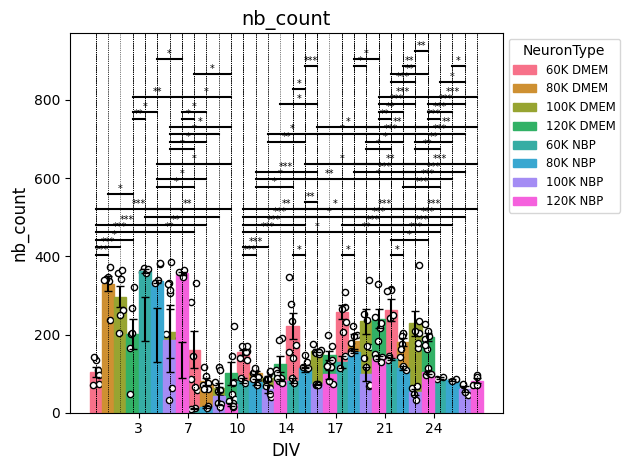

Number of unique Genotypes: 8
['60K DMEM', '80K DMEM', '100K DMEM', '120K DMEM', '60K NBP', '80K NBP', '100K NBP', '120K NBP']


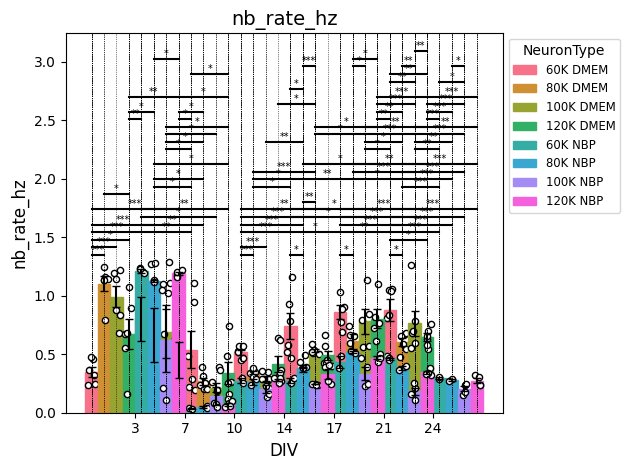

Number of unique Genotypes: 8
['60K DMEM', '80K DMEM', '100K DMEM', '120K DMEM', '60K NBP', '80K NBP', '100K NBP', '120K NBP']


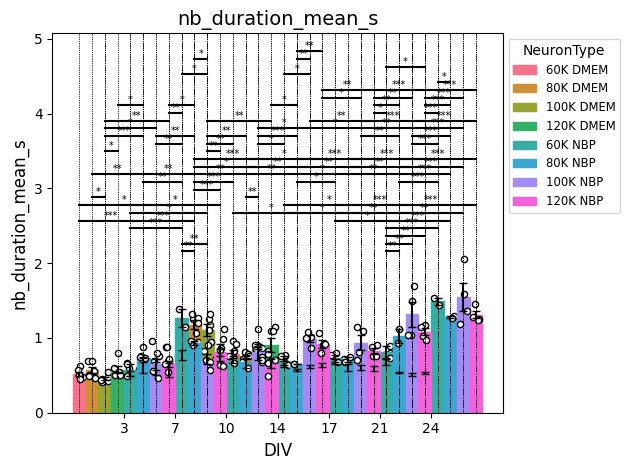

Number of unique Genotypes: 8
['60K DMEM', '80K DMEM', '100K DMEM', '120K DMEM', '60K NBP', '80K NBP', '100K NBP', '120K NBP']


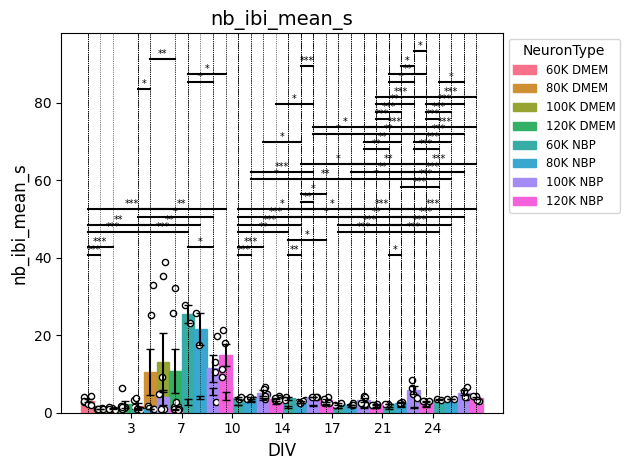

Number of unique Genotypes: 8
['60K DMEM', '80K DMEM', '100K DMEM', '120K DMEM', '60K NBP', '80K NBP', '100K NBP', '120K NBP']


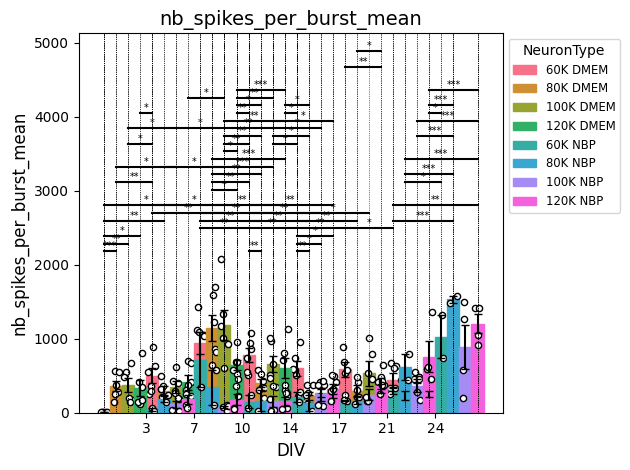

Number of unique Genotypes: 8
['60K DMEM', '80K DMEM', '100K DMEM', '120K DMEM', '60K NBP', '80K NBP', '100K NBP', '120K NBP']


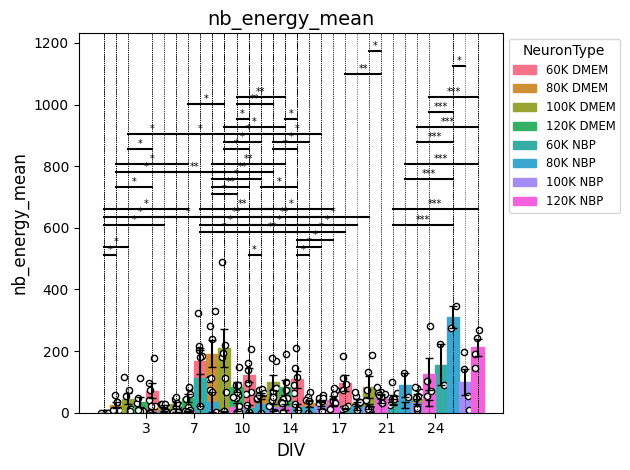

Number of unique Genotypes: 8
['60K DMEM', '80K DMEM', '100K DMEM', '120K DMEM', '60K NBP', '80K NBP', '100K NBP', '120K NBP']


KeyError: 'psib'

In [237]:
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
df = merged_df.copy()
output_types = ['nb_count',
       'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
       'nb_spikes_per_burst_mean', 'nb_energy_mean', 'psib']

div = sorted(df['DIV'].unique())

#unique_genotypes = [ 'MxWT', 'FxHET' ,'MxHEMI']

#colors = ['blue','orange','red']
#markers = ['o','o','d','*','^']

# Get unique genotypes
unique_genotypes = merged_df['Neuron Source'].unique().tolist()

# Generate colors using seaborn palette
colors = sns.color_palette("husl", len(unique_genotypes))  # or "Set2", "tab10", etc.

# Markers
marker_bank = ['o', 's', '^', 'v', 'd', '*', 'P', 'X', 'D', '<', '>', 'p', 'h', '8']
markers = marker_bank[:len(unique_genotypes)]

#dirpath = '/mnt/disk15tb/paula/Main_DA_Projects/data_analysis_output/Primary Neurons/CDKL5_E6T1_Apr29/plots/'
for output_type in output_types:
    total_genotypes = len(unique_genotypes)
    #output_type='Number_Bursts'
    # Print the number of unique genotypes
    print(f"Number of unique Genotypes: {total_genotypes}")

    # Initialize output arrays for each unique genotype
    output_arrays = {genotype: [] for genotype in unique_genotypes}
    chip_arrays = {genotype: [] for genotype in unique_genotypes}
    well_arrays = {genotype: [] for genotype in unique_genotypes}
    print(unique_genotypes)
    # Fill data from data frame
    for i in div:
        for genotype in unique_genotypes:
            temp_df = df.loc[(df['DIV'] == i) &
                            (df['Neuron Source'].str.strip() == genotype)
                            ]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
            chip_arrays[genotype].append(np.array(temp_df['ID']))
            well_arrays[genotype].append(np.array(temp_df['WellID']))
    #print(df)
    # Adjust bar width and gap between them
    bar_width = 0.25  # Adjust as necessary for your specific plot
    gap_between_bars = 0  # Adjust the gap between bars within a group

    # Calculate the total width for all bars in a group
    total_bar_group_width = total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars

    # Create x-coordinates of bars for each genotype group
    x_genotype = {genotype: [] for genotype in unique_genotypes}
    base_x_coordinate = np.arange(len(div))  # Base x-coordinates for each group
    offset = (total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars) / 2
    centered_x = base_x_coordinate - offset + bar_width / 2
    for i, genotype in enumerate(unique_genotypes):
        x_genotype[genotype] = centered_x + i * (bar_width + gap_between_bars)



    # Initialize plot
    fig, ax = plt.subplots()
    # Generate a list of distinct colors based on the number of genotypes
    #colors = [plt.colormaps['Set1'](i) for i in np.linspace(0, 1, len(unique_genotypes))]# Using a colormap to generate colors
    #colors2 = [plt.colormaps['Set2'](i) for i in np.linspace(0, 1, len(unique_genotypes))]#
    # marker_shapes = ['^', 's', 'v', 'D', '+', 'x', '*', 'H', '8']
    # marker_chips={chip:marker_shapes[idx] for idx, chip in enumerate(track_chips)}
    # Plot data for each genotype
    mean_data_all ={}
    yerr_data_all = {}
    n_data_all={}
    #breakpoint()
    #pdb.set_trace()
    for i,genotype in enumerate(unique_genotypes):
        #breakpoint()
        y_data = output_arrays[genotype]
        chipy_data = chip_arrays[genotype]
        welly_data = well_arrays[genotype]
        #print("type: ",type(genotype))
        # Calculate statistics
        mean_data = [np.mean([n for n in yi if np.isfinite(n)]) for yi in y_data]
        yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1)/np.sqrt(np.size(yi)) for yi in y_data]
        n_data = [len(yi) for yi in y_data]
        # Store statistics in dictionaries
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        
            
        # Plot bars
        #transparency value 
        alpha_value = 0.5
        ax.bar(x_genotype[genotype], mean_data, yerr=yerr_data, capsize=3, width=bar_width, color=colors[i], edgecolor=colors[i], ecolor='black', label=genotype,alpha=1.0)

        #pdb.set_trace()
        # Plot scatter points
        #breakpoint()
        for j in range(len(x_genotype[genotype])):
            #pdb.set_trace()
            # ax.scatter(x_genotype[genotype][j] + np.zeros(y_data[j].size), y_data[j], s=20,color=colors2[i],marker=marker_chips[chipy_data[j]+str(welly_data[j])] if chipy_data[j]+str(welly_data[j]) in track_chips else 'o')
    # Concatenate corresponding elements from chipy_data[j] and welly_data[j]
            combined_data = [str(chip)+ str(well) for chip, well in zip(chipy_data[j], welly_data[j])]

            # # Check if the concatenated string is in track_chips, and set the marker accordingly
            # markers = [marker_chips.get(chipwell, 'o') for chipwell in combined_data]
            # #marker_chips[combined_data[0]] if combined_data[0] in track_chips else 'o'

            # Use the marker in the scatter plot
            jitter_amount=0.08
            for k in range(len(y_data[j])):
                #pdb.set_trace()
                ax.scatter(
                    x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount, 1),
                    y_data[j][k],
                    s=20,
                    color='white',
                    marker='o',
                    edgecolors='black'
                        )


    # # Calculate maximum y-value for plotting significance
    # max_y = max([max(data) for data in output_arrays.values() if data.size > 0])
    # increment = max_y * 0.1  # Increment to adjust y-position for significance markers

    #Perform and plot t-tests between all pairs of genotype
    #pdb.set_trace()
    for i in range(len(base_x_coordinate)):
        #maxim = max([max( output_arrays[genotype][i] )for genotype in unique_genotypes])
        # Filter out empty arrays and arrays with only NaN values
        maxim = max(
            max(array) 
            for genotype_arrays in output_arrays.values() 
            for array in genotype_arrays 
            if len(array) > 0 and not all(np.isnan(array))
        )
        count = 1
        p_values = []
        for j, genotype1 in enumerate(unique_genotypes):
            for k, genotype2 in enumerate(unique_genotypes):
                if j < k:
                    #pdb.set_trace()
                    #print("mean_data_all",mean_data_all[genotype1])
                    #print("type:",type(genotype1))
                    mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                    mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                    #t_stat, p_value = stats.ttest_ind_from_stats(mean1, sem1, n1, mean2, sem2, n2)
                    sed = sqrt(sem1**2.0 + sem2**2.0)
                    t_stat = (mean1 - mean2) / sed
                    # degrees of freedom
                    degreef = n1+n2 - 2
                    alpha=0.05
                    # calculate the critical value
                    cv = stats.t.ppf(1.0 - alpha, degreef)
                    # calculate the p-vallue
                    p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                    p_values.append([mean1,sem1,mean2,sem2,p_value])

                    # Plot significance
                    #maxim = max(np.max(output_arrays[genotype1][i]), np.max(output_arrays[genotype2][i]))
                    x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                    
                    sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                    if not sign =='ns':
                        ax.plot([x1, x2], [maxim + 0.05*maxim*(count)] * 2, 'k', linewidth=1.5)
                        ax.text((x1 + x2) / 2, maxim +0.05*maxim*(count), sign, ha='center', va='bottom', fontsize=7)
                        ax.axvline(x1,color='black',linestyle=':',linewidth=0.5)
                        ax.axvline(x2,color='black',linestyle=':',linewidth=0.5)
                    count = count +1

                    


   # Adjustments for plot aesthetics
    plt.title(f"{output_type}", fontsize=14)
    plt.xlabel('DIV', fontsize=12)
    plt.ylabel(f"{output_type}", fontsize=12)
    plt.xticks(base_x_coordinate, div, fontsize=10)

    plt.legend(title='NeuronType', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
    plt.tight_layout() 
    plt.show() # Adjust layout to prevent clipping of ylabel
    #plt.legend(title='NeuronType',loc='upper right', fontsize='x-small', handlelength=2, handletextpad=2, handleheight=2,bbox_to_anchor=(1.0, 1))
   # import os 
    
    #if not os.path.exists(dirpath):
    #        os.makedirs(dirpath)
    #plt.savefig(f"{dirpath}/{output_type}.svg",dpi=300,format='svg')

In [245]:
df['DIV']

93      3
94      3
92      3
91      3
95      3
       ..
174    24
172    24
171    24
175    24
170    24
Name: DIV, Length: 248, dtype: int64

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_New/nb_count_250414.png


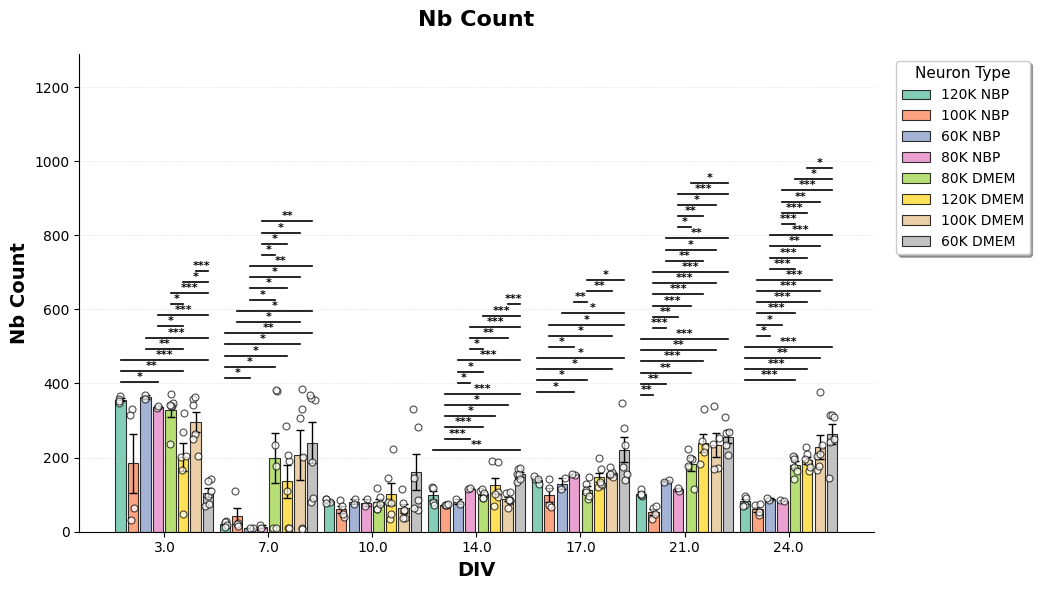

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_New/nb_rate_hz_250414.png


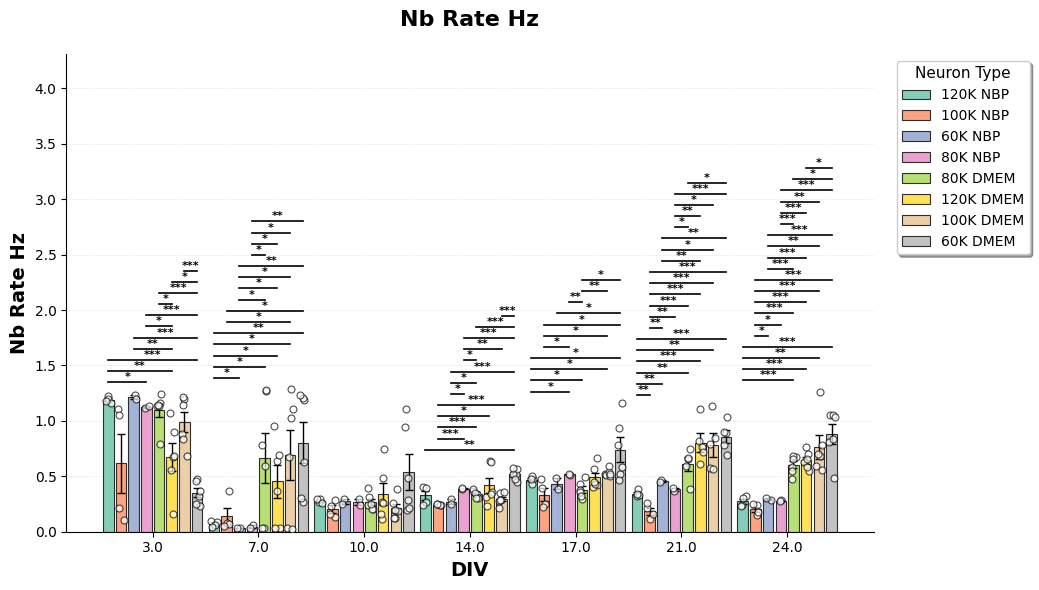

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_New/nb_duration_mean_s_250414.png


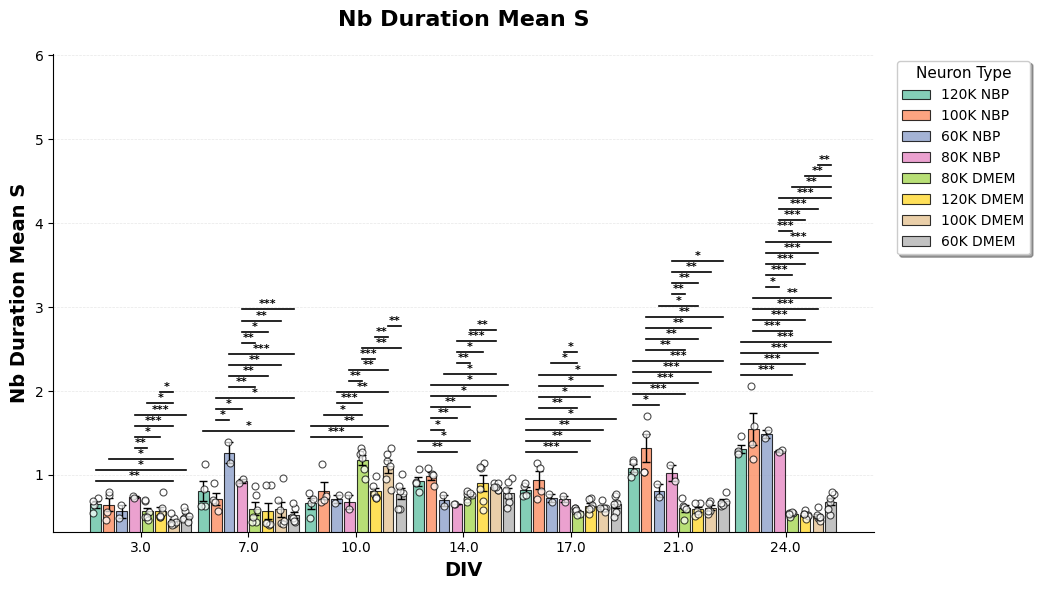

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_New/nb_ibi_mean_s_250414.png


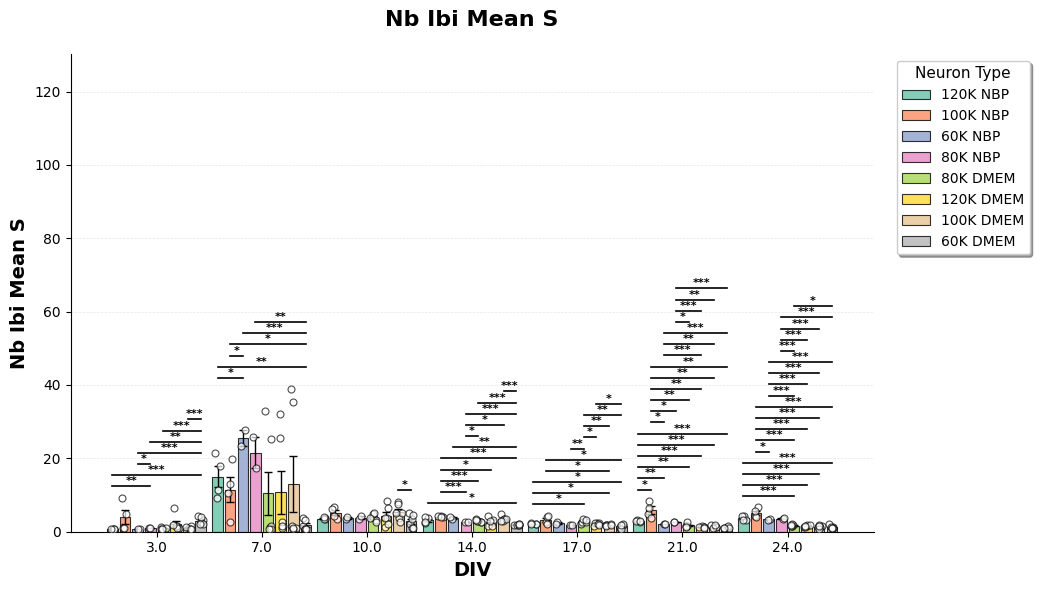

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_New/nb_spikes_per_burst_mean_250414.png


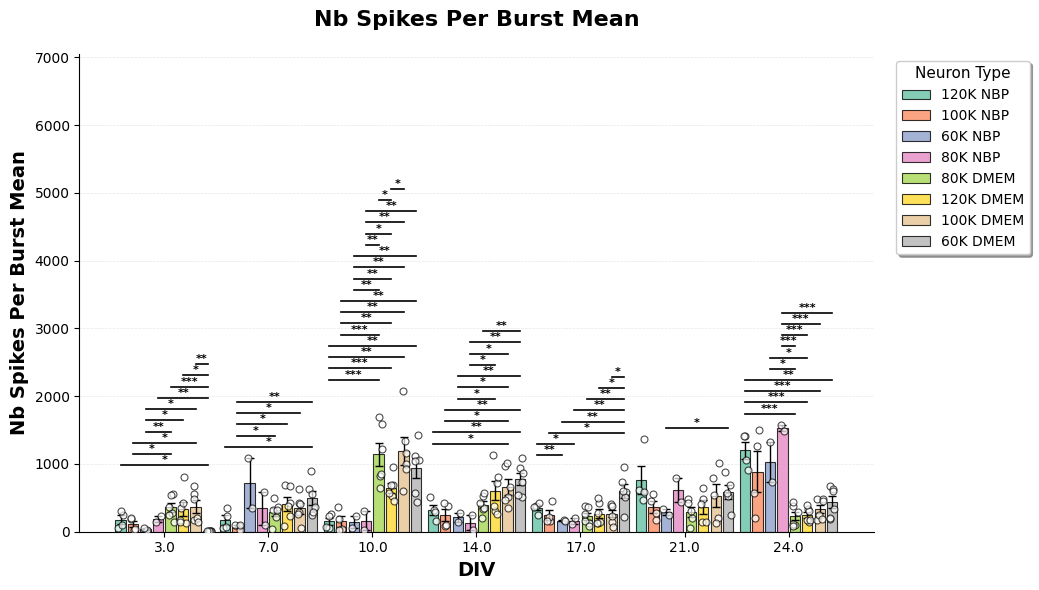

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_New/nb_energy_mean_250414.png


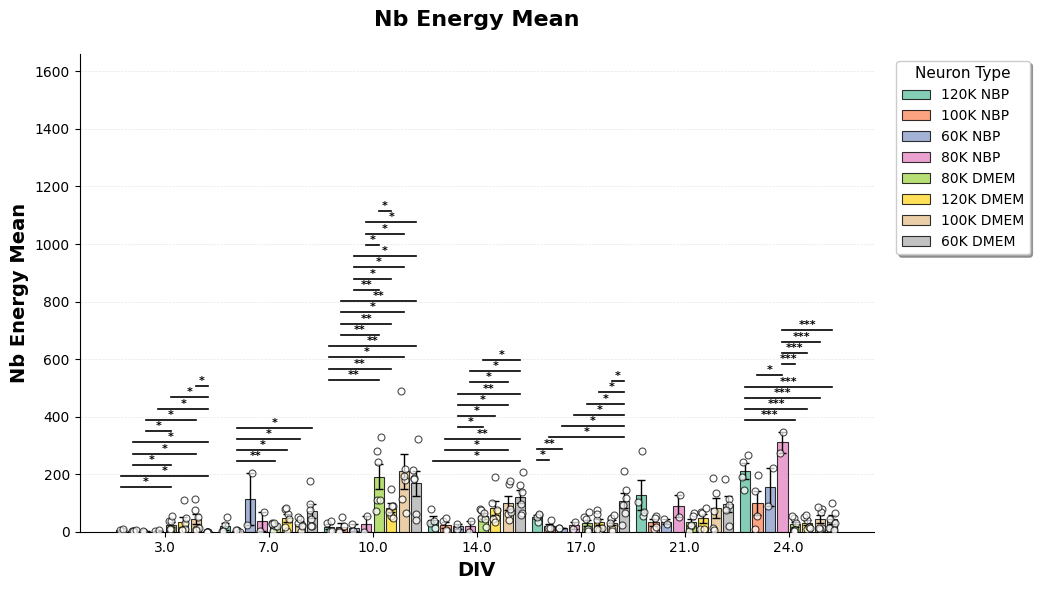

In [215]:
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

df = merged_df.copy()
output_types = ['nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
                'nb_spikes_per_burst_mean', 'nb_energy_mean']

div = sorted(df['DIV'].unique())

# Get unique genotypes (excluding 'nan' if present)
unique_genotypes = [g for g in merged_df['Neuron Source'].unique().tolist() if str(g) != 'nan']

# Generate colors using seaborn palette
colors = sns.color_palette("Set2", len(unique_genotypes))  # Set2 is better for bar plots

# Markers
marker_bank = ['o', 's', '^', 'v', 'd', '*', 'P', 'X', 'D', '<', '>', 'p', 'h', '8']
markers = marker_bank[:len(unique_genotypes)]

for output_type in output_types:
    total_genotypes = len(unique_genotypes)
    
    # Initialize output arrays for each unique genotype
    output_arrays = {genotype: [] for genotype in unique_genotypes}
    chip_arrays = {genotype: [] for genotype in unique_genotypes}
    well_arrays = {genotype: [] for genotype in unique_genotypes}
    
    # Fill data from data frame
    for i in div:
        for genotype in unique_genotypes:
            temp_df = df.loc[(df['DIV'] == i) & (df['Neuron Source'].str.strip() == genotype)]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
            chip_arrays[genotype].append(np.array(temp_df['ID']))
            well_arrays[genotype].append(np.array(temp_df['WellID']))
    
    # IMPROVED: Dynamic bar width based on number of genotypes
    bar_width = 0.8 / total_genotypes  # Total width of 0.8 divided by number of genotypes
    gap_between_bars = 0.02  # Small gap between bars
    
    # Create x-coordinates of bars for each genotype group
    x_genotype = {genotype: [] for genotype in unique_genotypes}
    base_x_coordinate = np.arange(len(div))
    offset = (total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars) / 2
    centered_x = base_x_coordinate - offset + bar_width / 2
    
    for i, genotype in enumerate(unique_genotypes):
        x_genotype[genotype] = centered_x + i * (bar_width + gap_between_bars)
    
    # IMPROVED: Larger figure size based on number of DIVs and genotypes
    fig_width = max(10, len(div) * 1.5)
    fig_height = 6
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Plot data for each genotype
    mean_data_all = {}
    yerr_data_all = {}
    n_data_all = {}
    
    for i, genotype in enumerate(unique_genotypes):
        y_data = output_arrays[genotype]
        chipy_data = chip_arrays[genotype]
        welly_data = well_arrays[genotype]
        
        # Calculate statistics
        mean_data = [np.mean([n for n in yi if np.isfinite(n)]) if len([n for n in yi if np.isfinite(n)]) > 0 else 0 
                     for yi in y_data]
        yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1) / np.sqrt(len([n for n in yi if np.isfinite(n)])) 
                     if len([n for n in yi if np.isfinite(n)]) > 1 else 0 
                     for yi in y_data]
        n_data = [len([n for n in yi if np.isfinite(n)]) for yi in y_data]
        
        # Store statistics in dictionaries
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        
        # Plot bars with better styling
        ax.bar(x_genotype[genotype], mean_data, yerr=yerr_data, capsize=3, 
               width=bar_width, color=colors[i], edgecolor='black', linewidth=0.8,
               ecolor='black', label=genotype, alpha=0.8, error_kw={'linewidth': 1})
        
        # Plot scatter points
        jitter_amount = bar_width * 0.3  # Dynamic jitter based on bar width
        for j in range(len(x_genotype[genotype])):
            for k in range(len(y_data[j])):
                if np.isfinite(y_data[j][k]):  # Only plot finite values
                    ax.scatter(
                        x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount),
                        y_data[j][k],
                        s=25,
                        color='white',
                        marker='o',
                        edgecolors='black',
                        linewidths=0.8,
                        alpha=0.7,
                        zorder=3
                    )
    
    # IMPROVED: Calculate significance and determine y-axis limits dynamically
    all_valid_values = []
    for genotype_arrays in output_arrays.values():
        for array in genotype_arrays:
            valid_vals = [v for v in array if np.isfinite(v)]
            all_valid_values.extend(valid_vals)
    
    if len(all_valid_values) > 0:
        data_max = max(all_valid_values)
        data_min = min(all_valid_values)
        data_range = data_max - data_min
        
        # Perform t-tests and plot significance
        for i in range(len(base_x_coordinate)):
            # Get max for this specific DIV
            div_max_values = []
            for genotype in unique_genotypes:
                valid_vals = [v for v in output_arrays[genotype][i] if np.isfinite(v)]
                if valid_vals:
                    div_max_values.append(max(valid_vals))
            
            if not div_max_values:
                continue
                
            maxim = max(div_max_values)
            count = 1
            
            for j, genotype1 in enumerate(unique_genotypes):
                for k, genotype2 in enumerate(unique_genotypes):
                    if j < k:
                        mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                        mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                        
                        # Skip if not enough data
                        if n1 < 2 or n2 < 2 or sem1 == 0 or sem2 == 0:
                            continue
                        
                        sed = sqrt(sem1**2.0 + sem2**2.0)
                        t_stat = (mean1 - mean2) / sed
                        degreef = n1 + n2 - 2
                        p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                        
                        x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                        sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                        
                        if sign != 'ns':
                            # IMPROVED: Dynamic y-position for significance bars
                            y_pos = maxim + 0.08 * data_range * count
                            ax.plot([x1, x2], [y_pos, y_pos], 'k', linewidth=1.2)
                            ax.text((x1 + x2) / 2, y_pos, sign, ha='center', va='bottom', fontsize=8, fontweight='bold')
                            count += 1
        
        # IMPROVED: Set y-axis limits dynamically with padding for significance bars
        max_count = (total_genotypes * (total_genotypes - 1)) // 2  # Max number of comparisons
        y_max = data_max + 0.08 * data_range * (max_count + 2)  # Extra space for significance
        y_min = max(0, data_min - 0.05 * data_range)  # Small padding at bottom, don't go below 0
        ax.set_ylim(y_min, y_max)
    
    # IMPROVED: Better plot aesthetics
    ax.set_title(f"{output_type.replace('_', ' ').title()}", fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('DIV', fontsize=14, fontweight='bold')
    ax.set_ylabel(f"{output_type.replace('_', ' ').title()}", fontsize=14, fontweight='bold')
    ax.set_xticks(base_x_coordinate)
    ax.set_xticklabels(div, fontsize=11)
    ax.tick_params(axis='both', labelsize=10)
    
    # IMPROVED: Better legend placement
    ax.legend(title='Neuron Type', loc='upper left', bbox_to_anchor=(1.02, 1), 
              fontsize=10, title_fontsize=11, frameon=True, fancybox=True, shadow=True)
    
    # IMPROVED: Grid for better readability
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    outdir = "/mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_New"
    os.makedirs(outdir, exist_ok=True)

    safe_output_type = output_type.replace(" ", "_").replace("/", "_")
    fname = f"{safe_output_type}_{plating_date}.png"
    savepath = os.path.join(outdir, fname)

    fig.savefig(savepath, dpi=300, bbox_inches='tight', format='png')
    print(f"Saved figure to: {savepath}")
    plt.tight_layout()
    plt.show()

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_meanonly_New/nb_count.png


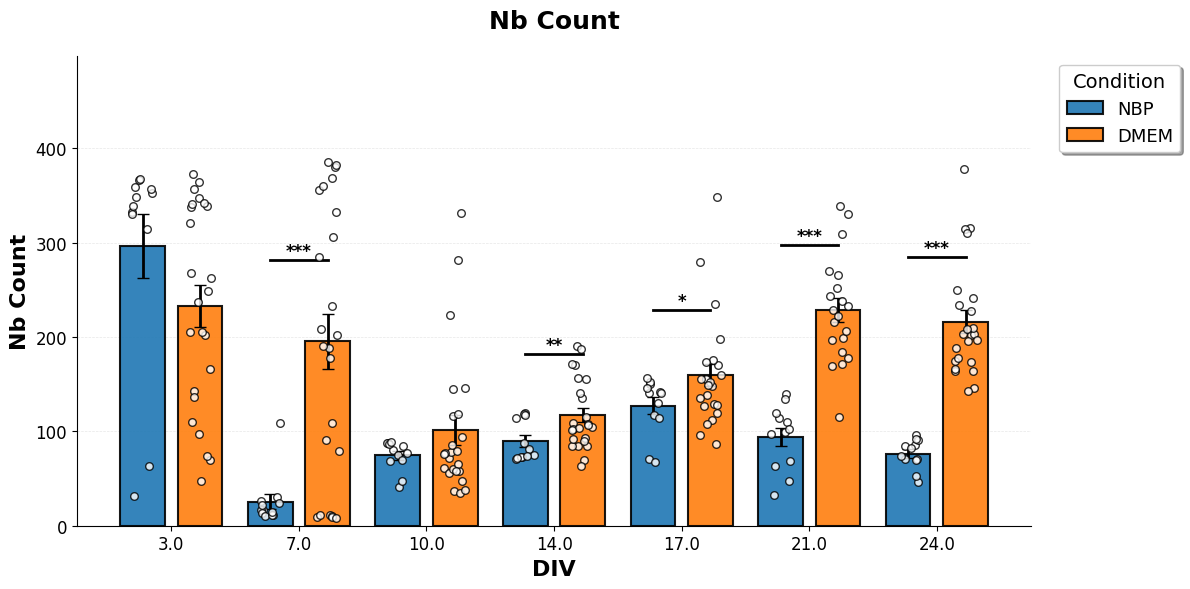

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_meanonly_New/nb_rate_hz.png


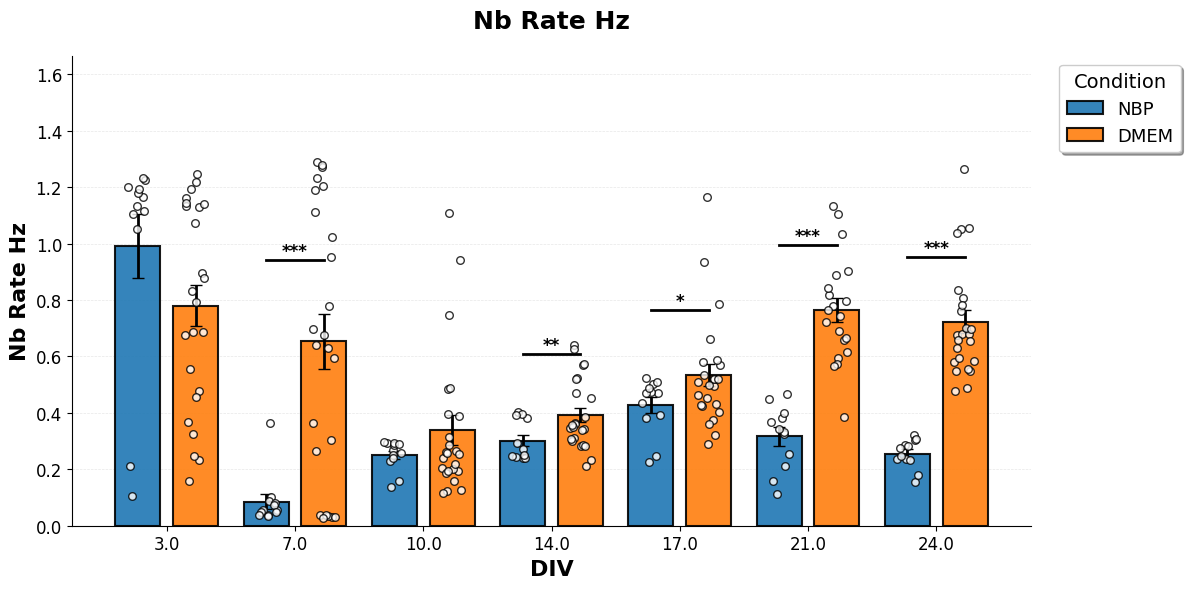

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_meanonly_New/nb_duration_mean_s.png


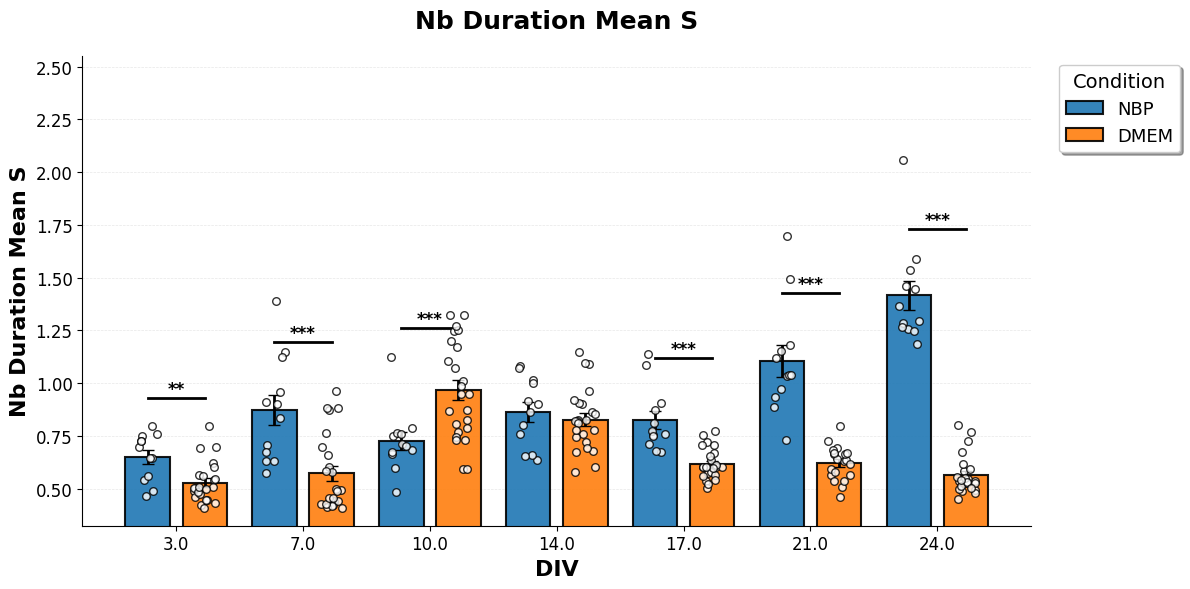

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_meanonly_New/nb_ibi_mean_s.png


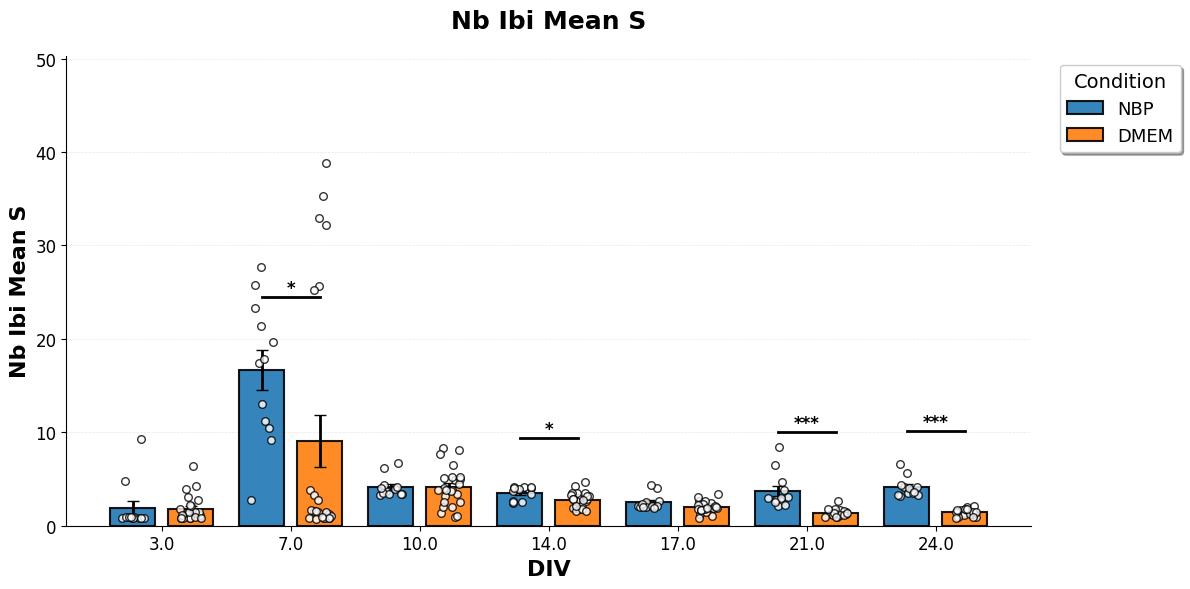

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_meanonly_New/nb_spikes_per_burst_mean.png


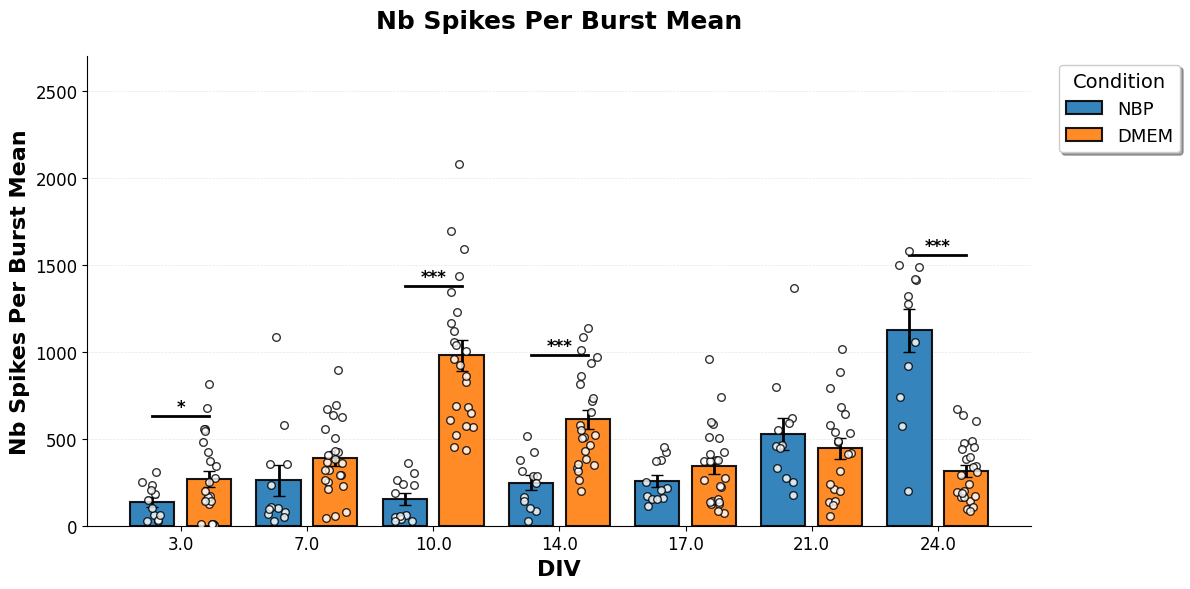

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_meanonly_New/nb_energy_mean.png


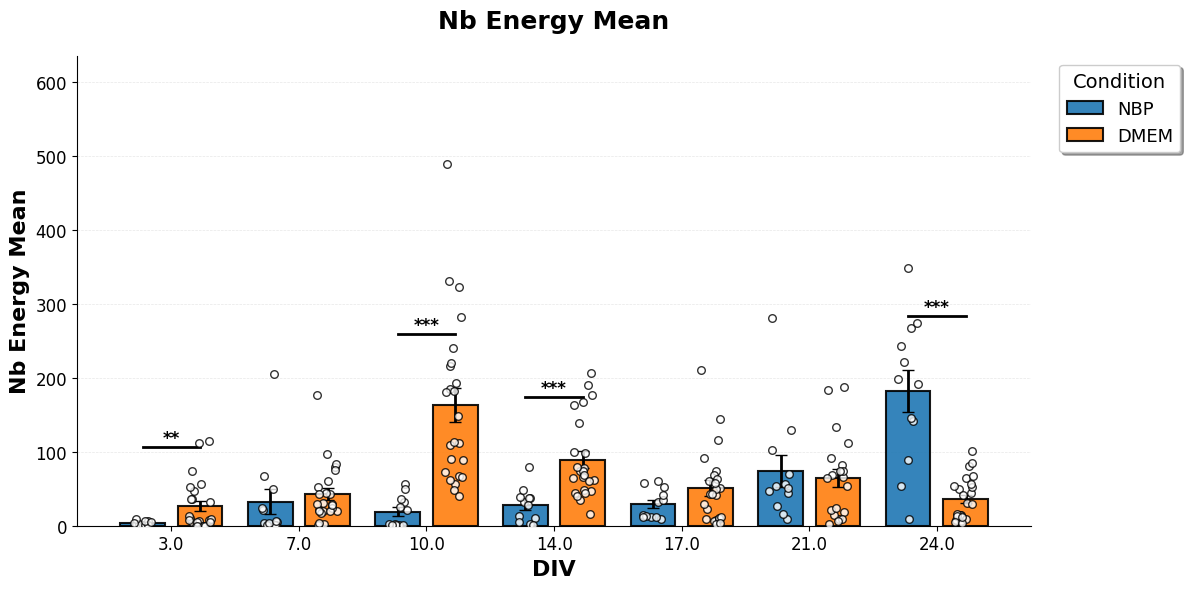

In [216]:
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = merged_df.copy()

# Create aggregated condition column
def aggregate_condition(neuron_source):
    if pd.isna(neuron_source) or str(neuron_source) == 'nan':
        return None
    elif 'NBP' in str(neuron_source):
        return 'NBP'
    elif 'DMEM' in str(neuron_source):
        return 'DMEM'
    else:
        return None

df['Condition'] = df['Neuron Source'].apply(aggregate_condition)
df = df.dropna(subset=['Condition'])  # Remove rows without a condition

output_types = ['nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
                'nb_spikes_per_burst_mean', 'nb_energy_mean']

div = sorted(df['DIV'].unique())

# Two conditions only
unique_genotypes = ['NBP', 'DMEM']

# Bold, distinct colors
colors = ['#1f77b4', '#ff7f0e']  # Bold blue and bold orange

for output_type in output_types:
    total_genotypes = len(unique_genotypes)
    
    # Initialize output arrays for each condition
    output_arrays = {genotype: [] for genotype in unique_genotypes}
    
    # Fill data from data frame
    for i in div:
        for genotype in unique_genotypes:
            temp_df = df.loc[(df['DIV'] == i) & (df['Condition'] == genotype)]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
    
    # Bar width
    bar_width = 0.35
    gap_between_bars = 0.1
    
    # Create x-coordinates
    x_genotype = {}
    base_x_coordinate = np.arange(len(div))
    offset = (total_genotypes * bar_width + gap_between_bars) / 2
    centered_x = base_x_coordinate - offset + bar_width / 2
    
    for i, genotype in enumerate(unique_genotypes):
        x_genotype[genotype] = centered_x + i * (bar_width + gap_between_bars)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Store statistics
    mean_data_all = {}
    yerr_data_all = {}
    n_data_all = {}
    
    for i, genotype in enumerate(unique_genotypes):
        y_data = output_arrays[genotype]
        
        # Calculate statistics
        mean_data = []
        yerr_data = []
        n_data = []
        
        for yi in y_data:
            valid_values = [n for n in yi if np.isfinite(n)]
            if len(valid_values) > 0:
                mean_data.append(np.mean(valid_values))
                if len(valid_values) > 1:
                    yerr_data.append(np.std(valid_values, ddof=1) / np.sqrt(len(valid_values)))
                else:
                    yerr_data.append(0)
                n_data.append(len(valid_values))
            else:
                mean_data.append(0)
                yerr_data.append(0)
                n_data.append(0)
        
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        
        # Plot bars
        ax.bar(x_genotype[genotype], mean_data, yerr=yerr_data, capsize=4,
               width=bar_width, color=colors[i], edgecolor='black', linewidth=1.5,
               ecolor='black', label=genotype, alpha=0.9, error_kw={'linewidth': 2})
        
        # Plot scatter points
        jitter_amount = bar_width * 0.25
        for j in range(len(x_genotype[genotype])):
            for k in range(len(y_data[j])):
                if np.isfinite(y_data[j][k]):
                    ax.scatter(
                        x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount),
                        y_data[j][k],
                        s=30,
                        color='white',
                        marker='o',
                        edgecolors='black',
                        linewidths=1,
                        alpha=0.8,
                        zorder=3
                    )
    
    # Calculate y-axis limits based on data
    all_valid_values = []
    for genotype_arrays in output_arrays.values():
        for array in genotype_arrays:
            valid_vals = [v for v in array if np.isfinite(v)]
            all_valid_values.extend(valid_vals)
    
    if len(all_valid_values) > 0:
        data_max = max(all_valid_values)
        data_min = min(all_valid_values)
        data_range = data_max - data_min if data_max > data_min else data_max
        
        # Perform t-tests
        for i in range(len(base_x_coordinate)):
            genotype1, genotype2 = unique_genotypes[0], unique_genotypes[1]
            mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
            mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
            
            if n1 >= 2 and n2 >= 2 and sem1 > 0 and sem2 > 0:
                sed = sqrt(sem1**2.0 + sem2**2.0)
                t_stat = (mean1 - mean2) / sed
                degreef = n1 + n2 - 2
                p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                
                x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                
                if sign != 'ns':
                    # Get max for this DIV
                    div_max = max([mean1 + sem1, mean2 + sem2])
                    y_pos = div_max + 0.15 * data_range
                    ax.plot([x1, x2], [y_pos, y_pos], 'k', linewidth=2)
                    ax.text((x1 + x2) / 2, y_pos, sign, ha='center', va='bottom', 
                           fontsize=12, fontweight='bold')
        
        # Set y-axis limits relative to max value
        y_max = data_max + 0.3 * data_range  # 30% padding above max
        y_min = max(0, data_min - 0.05 * data_range)
        ax.set_ylim(y_min, y_max)
    
    # Styling
    ax.set_title(f"{output_type.replace('_', ' ').title()}", fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('DIV', fontsize=16, fontweight='bold')
    ax.set_ylabel(f"{output_type.replace('_', ' ').title()}", fontsize=16, fontweight='bold')
    ax.set_xticks(base_x_coordinate)
    ax.set_xticklabels(div, fontsize=13)
    ax.tick_params(axis='both', labelsize=12)
    
    ax.legend(title='Condition', loc='upper left', bbox_to_anchor=(1.02, 1),
              fontsize=13, title_fontsize=14, frameon=True, fancybox=True, shadow=True)
    
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    outdir = "/mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_meanonly_New"
    os.makedirs(outdir, exist_ok=True)

    safe_output_type = output_type.replace(" ", "_").replace("/", "_")
    fname = f"{safe_output_type}.png"
    savepath = os.path.join(outdir, fname)

    fig.savefig(savepath, dpi=300, bbox_inches='tight', format='png')
    print(f"Saved figure to: {savepath}")
    
    plt.tight_layout()
    plt.show()

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_NBP_DMEM_Seperate_New/nb_count_250414.png


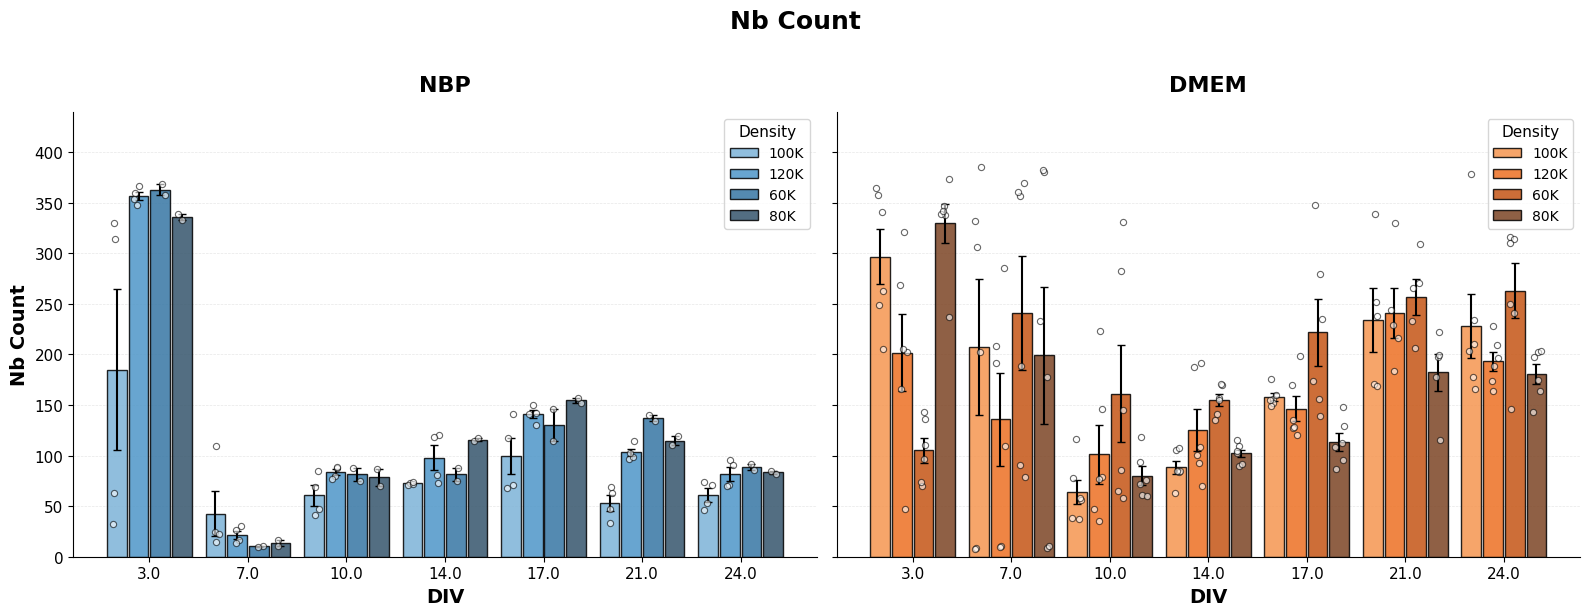

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_NBP_DMEM_Seperate_New/nb_rate_hz_250414.png


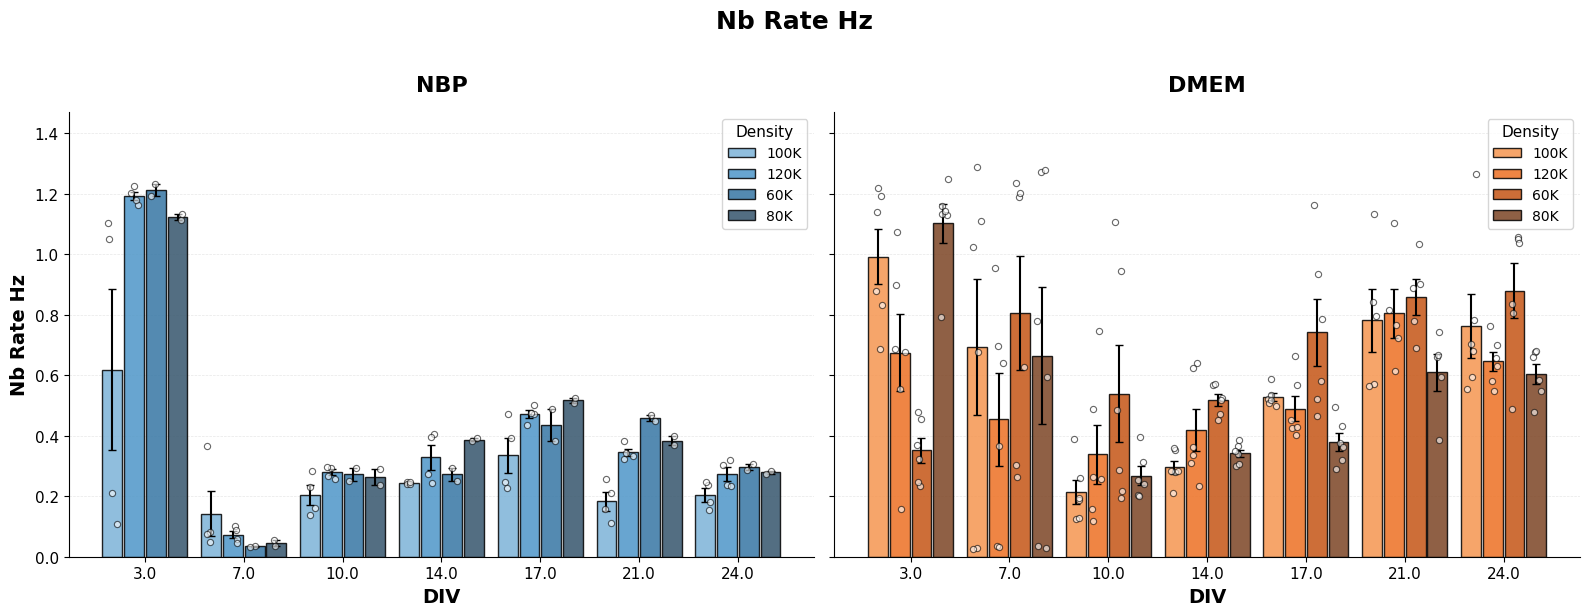

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_NBP_DMEM_Seperate_New/nb_duration_mean_s_250414.png


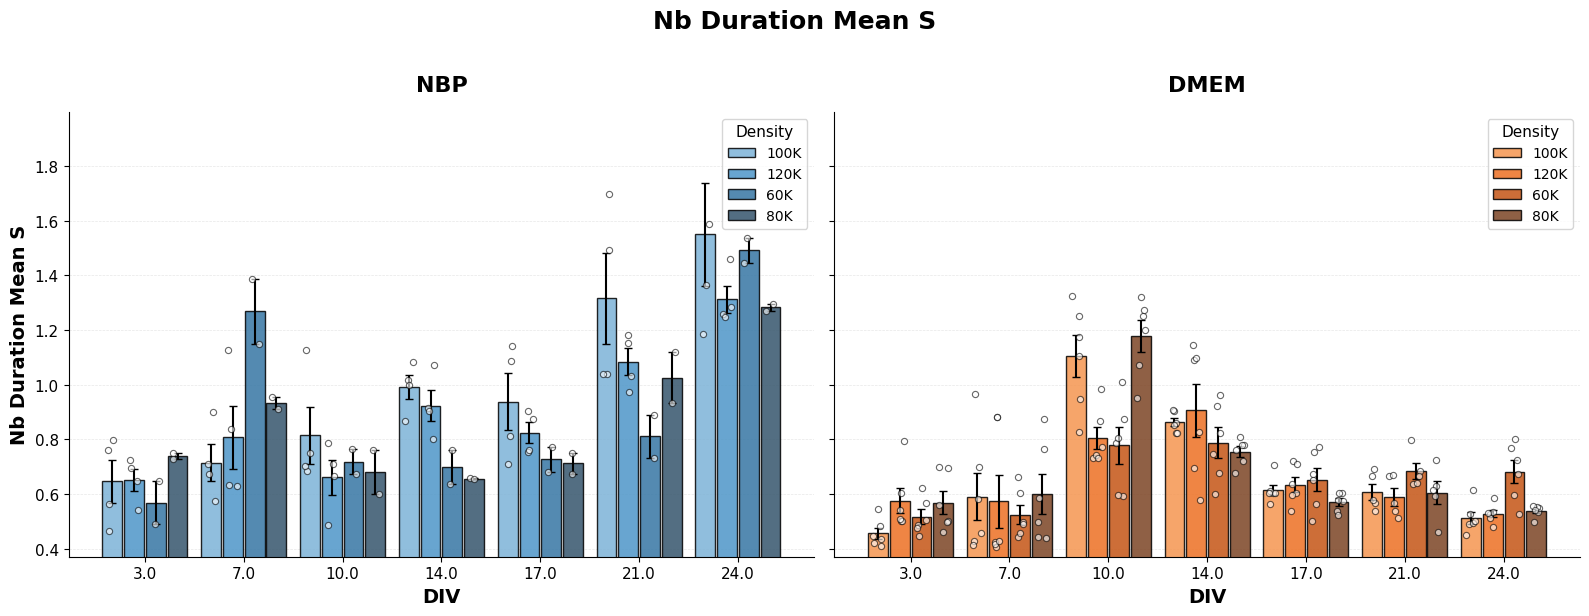

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_NBP_DMEM_Seperate_New/nb_ibi_mean_s_250414.png


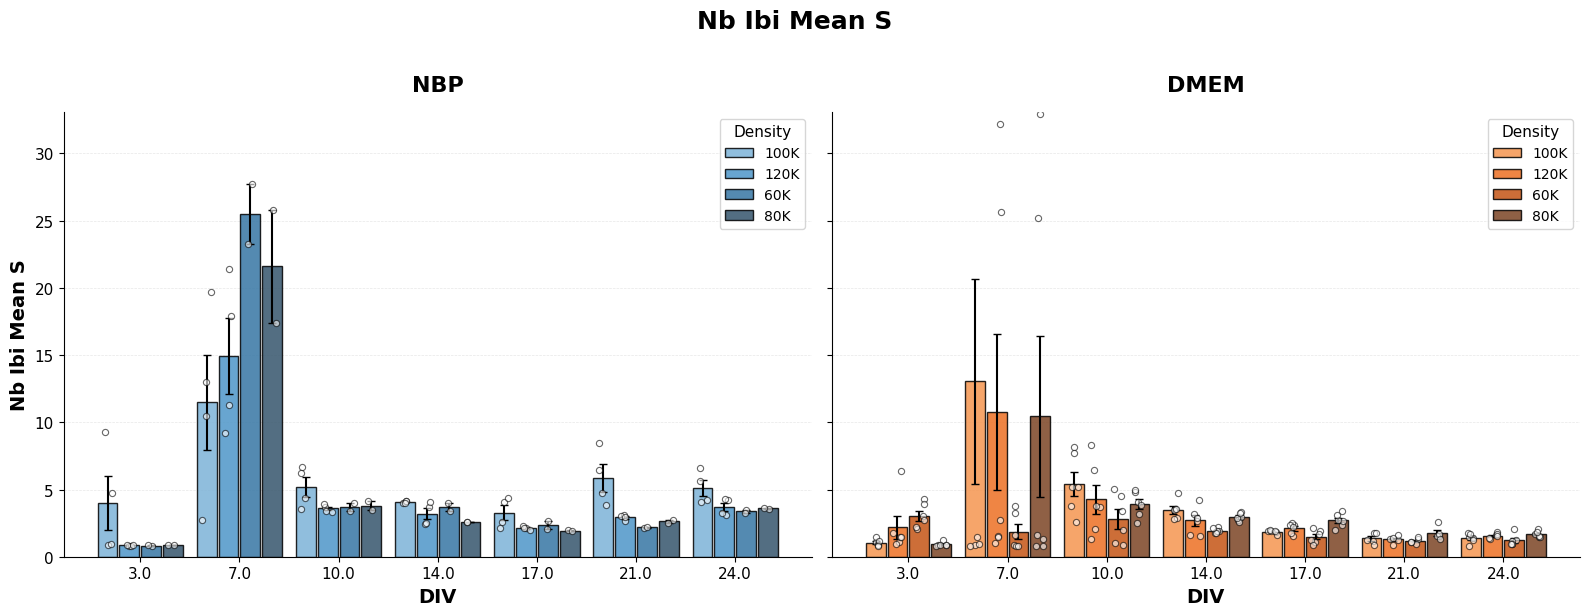

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_NBP_DMEM_Seperate_New/nb_spikes_per_burst_mean_250414.png


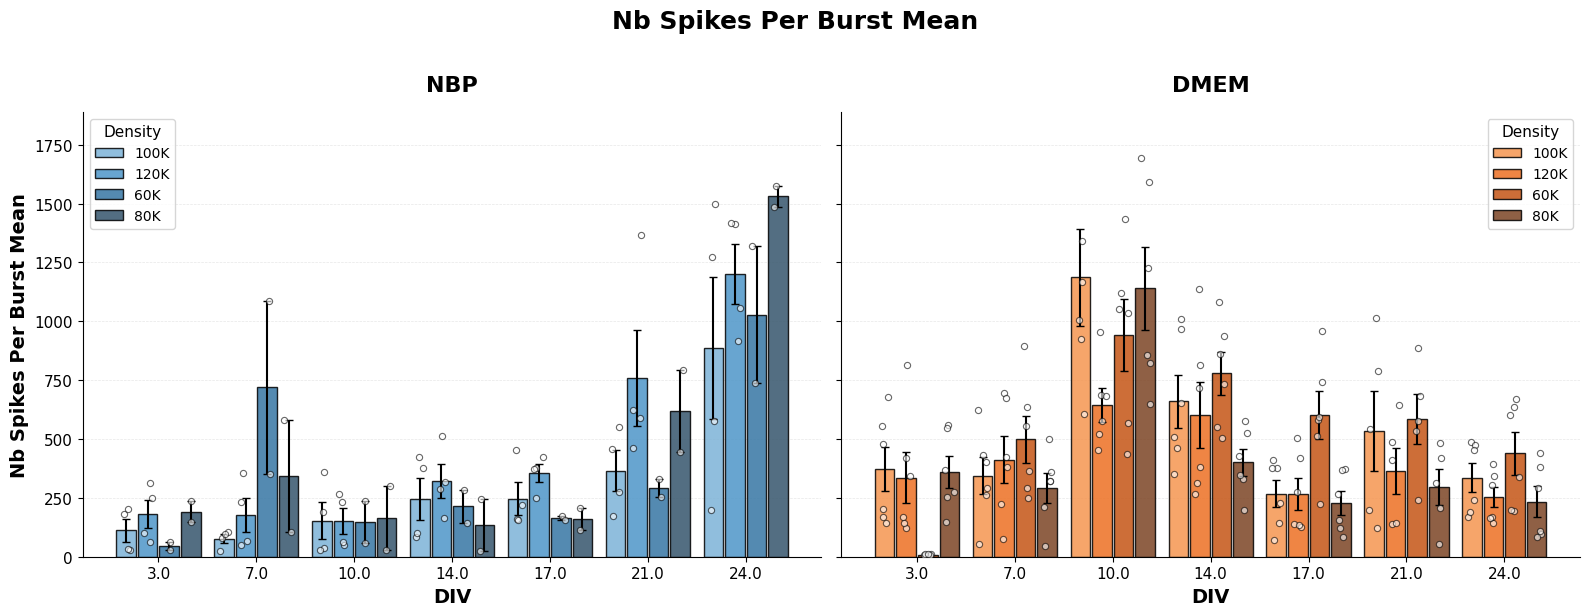

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_NBP_DMEM_Seperate_New/nb_energy_mean_250414.png


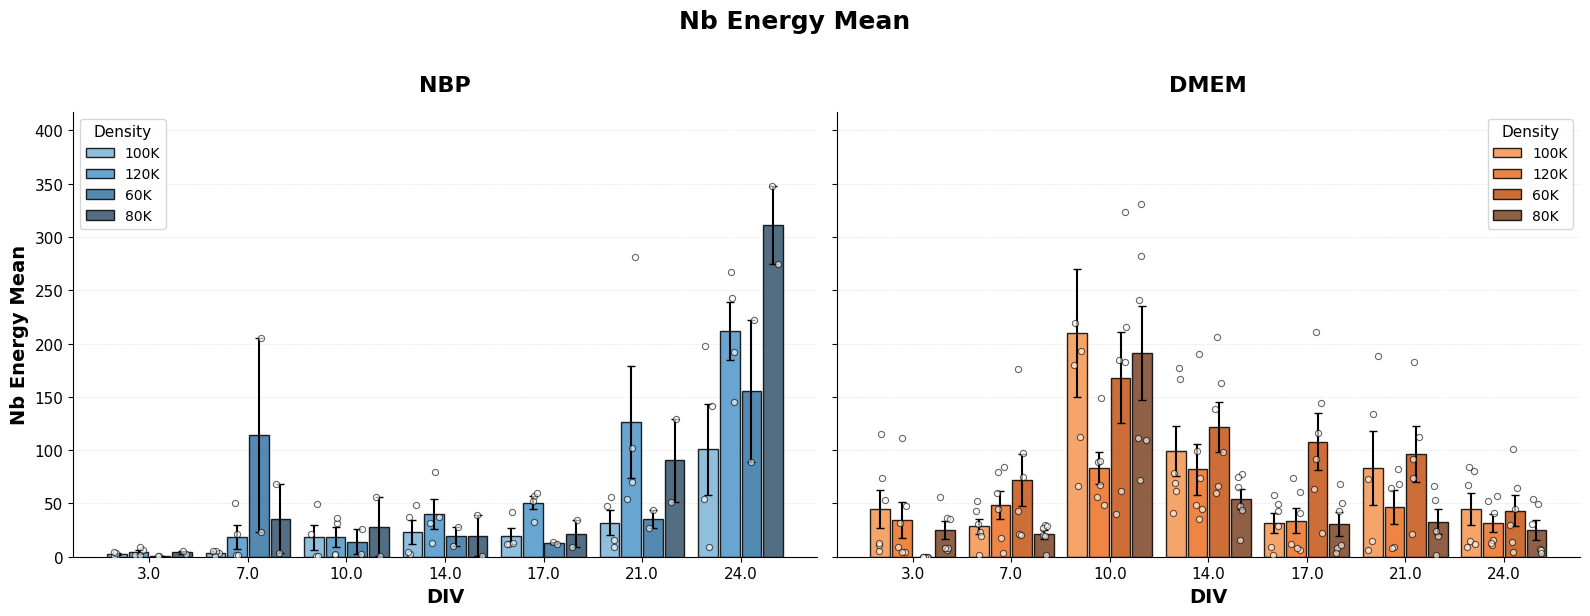

KeyError: 'psib'

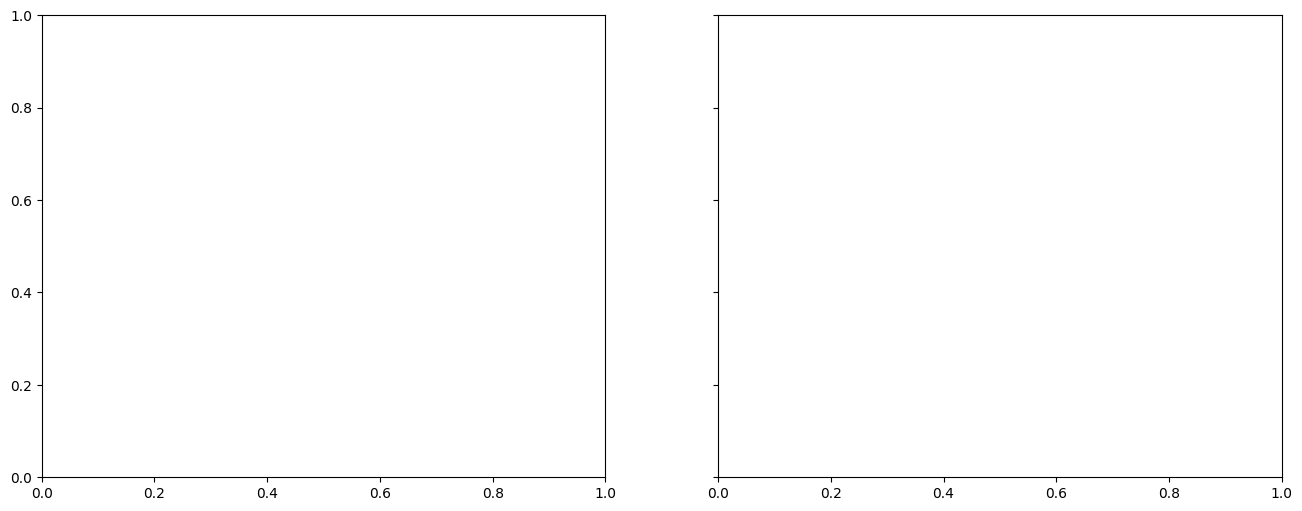

In [217]:
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = merged_df.copy()

# Separate NBP and DMEM with density info
def get_condition_and_density(neuron_source):
    if pd.isna(neuron_source) or str(neuron_source) == 'nan':
        return None, None
    ns = str(neuron_source)
    if 'NBP' in ns:
        condition = 'NBP'
    elif 'DMEM' in ns:
        condition = 'DMEM'
    else:
        return None, None
    
    # Extract density (e.g., "60K", "80K")
    density = ns.split()[0] if ' ' in ns else ns.split('K')[0] + 'K'
    return condition, density

df[['Condition', 'Density']] = df['Neuron Source'].apply(
    lambda x: pd.Series(get_condition_and_density(x))
)
df = df.dropna(subset=['Condition', 'Density'])

output_types = ['nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
                'nb_spikes_per_burst_mean', 'nb_energy_mean', 'psib']

div = sorted(df['DIV'].unique())

# Get unique densities for each condition
nbp_densities = sorted(df[df['Condition'] == 'NBP']['Density'].unique())
dmem_densities = sorted(df[df['Condition'] == 'DMEM']['Density'].unique())

# Color palettes
nbp_colors = sns.color_palette("Blues_d", len(nbp_densities))
dmem_colors = sns.color_palette("Oranges_d", len(dmem_densities))

for output_type in output_types:
    # Create subplots: one for NBP, one for DMEM
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    
    for ax_idx, (condition, densities, colors_palette) in enumerate([
        ('NBP', nbp_densities, nbp_colors),
        ('DMEM', dmem_densities, dmem_colors)
    ]):
        ax = axes[ax_idx]
        
        # Initialize arrays
        output_arrays = {density: [] for density in densities}
        
        # Fill data
        for i in div:
            for density in densities:
                temp_df = df.loc[(df['DIV'] == i) & 
                                (df['Condition'] == condition) & 
                                (df['Density'] == density)]
                output_arrays[density].append(np.array(temp_df[output_type]))
        
        # Bar settings
        total_densities = len(densities)
        bar_width = 0.8 / total_densities
        gap = 0.02
        
        # X-coordinates
        x_density = {}
        base_x = np.arange(len(div))
        offset = (total_densities * bar_width + (total_densities - 1) * gap) / 2
        centered_x = base_x - offset + bar_width / 2
        
        for i, density in enumerate(densities):
            x_density[density] = centered_x + i * (bar_width + gap)
        
        # Store statistics
        mean_data_all = {}
        yerr_data_all = {}
        n_data_all = {}
        all_values = []
        
        # Plot each density
        for i, density in enumerate(densities):
            y_data = output_arrays[density]
            
            mean_data = []
            yerr_data = []
            n_data = []
            
            for yi in y_data:
                valid_values = [n for n in yi if np.isfinite(n)]
                if len(valid_values) > 0:
                    mean_data.append(np.mean(valid_values))
                    if len(valid_values) > 1:
                        yerr_data.append(np.std(valid_values, ddof=1) / np.sqrt(len(valid_values)))
                    else:
                        yerr_data.append(0)
                    n_data.append(len(valid_values))
                    all_values.extend(valid_values)
                else:
                    mean_data.append(0)
                    yerr_data.append(0)
                    n_data.append(0)
            
            mean_data_all[density] = mean_data
            yerr_data_all[density] = yerr_data
            n_data_all[density] = n_data
            
            # Plot bars
            ax.bar(x_density[density], mean_data, yerr=yerr_data, capsize=3,
                   width=bar_width, color=colors_palette[i], edgecolor='black', 
                   linewidth=1, ecolor='black', label=density, alpha=0.85,
                   error_kw={'linewidth': 1.5})
            
            # Scatter points
            jitter = bar_width * 0.25
            for j in range(len(x_density[density])):
                for k in range(len(y_data[j])):
                    if np.isfinite(y_data[j][k]):
                        ax.scatter(
                            x_density[density][j] + np.random.uniform(-jitter, jitter),
                            y_data[j][k],
                            s=20,
                            color='white',
                            marker='o',
                            edgecolors='black',
                            linewidths=0.8,
                            alpha=0.6,
                            zorder=3
                        )
        
        # Styling
        ax.set_title(f"{condition}", fontsize=16, fontweight='bold', pad=15)
        ax.set_xlabel('DIV', fontsize=14, fontweight='bold')
        if ax_idx == 0:
            ax.set_ylabel(f"{output_type.replace('_', ' ').title()}", fontsize=14, fontweight='bold')
        ax.set_xticks(base_x)
        ax.set_xticklabels(div, fontsize=11)
        ax.tick_params(axis='both', labelsize=11)
        
        ax.legend(title='Density', fontsize=10, title_fontsize=11, 
                 frameon=True, fancybox=True)
        ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
        ax.set_axisbelow(True)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Set shared y-axis limits based on all data
    all_data_values = []
    for ax in axes:
        for line in ax.get_lines():
            all_data_values.extend(line.get_ydata())
    
    if all_data_values:
        data_max = max([v for v in all_data_values if np.isfinite(v)])
        data_min = min([v for v in all_data_values if np.isfinite(v)])
        data_range = data_max - data_min if data_max > data_min else data_max
        y_max = data_max + 0.2 * data_range
        y_min = max(0, data_min - 0.05 * data_range)
        for ax in axes:
            ax.set_ylim(y_min, y_max)
    
    fig.suptitle(f"{output_type.replace('_', ' ').title()}", 
                fontsize=18, fontweight='bold', y=1.02)

    outdir = "/mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_NBP_DMEM_Seperate_New"
    os.makedirs(outdir, exist_ok=True)

    safe_output_type = output_type.replace(" ", "_").replace("/", "_")
    fname = f"{safe_output_type}_{plating_date}.png"
    savepath = os.path.join(outdir, fname)

    fig.savefig(savepath, dpi=300, bbox_inches='tight', format='png')
    print(f"Saved figure to: {savepath}")
    plt.tight_layout()
    plt.show()

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_SameColorMedia/nb_count_250414.png


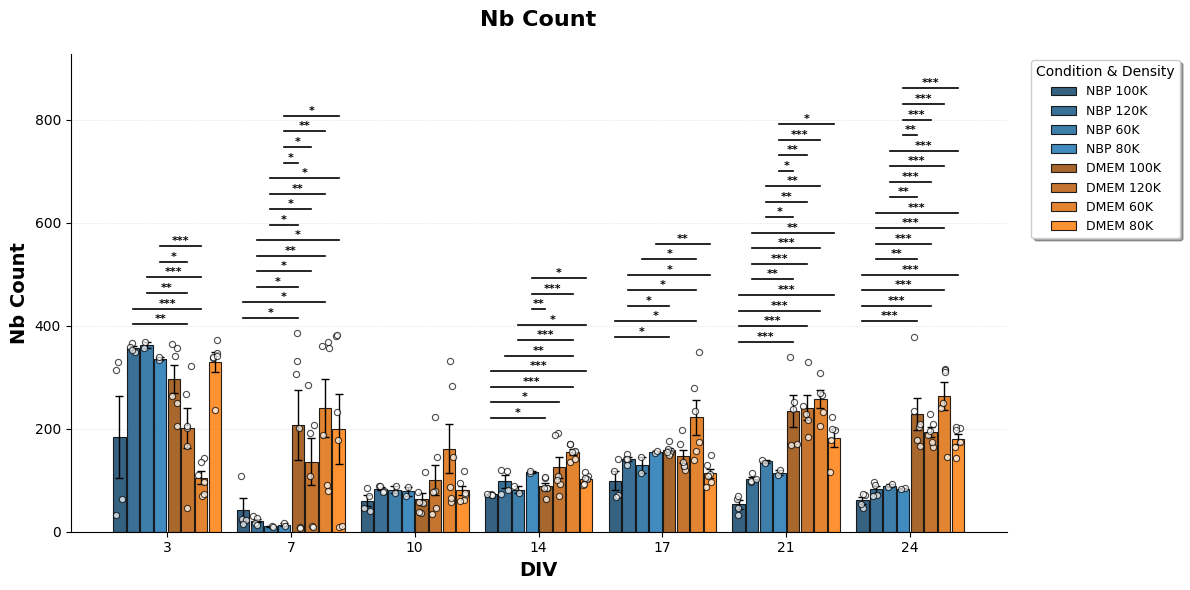

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_SameColorMedia/nb_rate_hz_250414.png


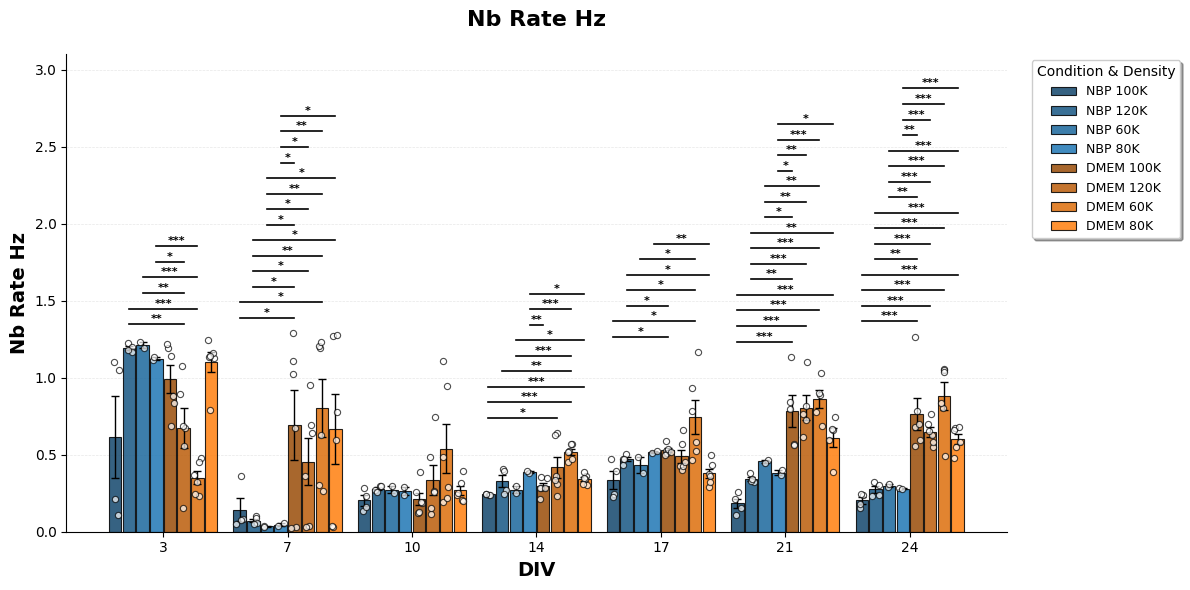

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_SameColorMedia/nb_duration_mean_s_250414.png


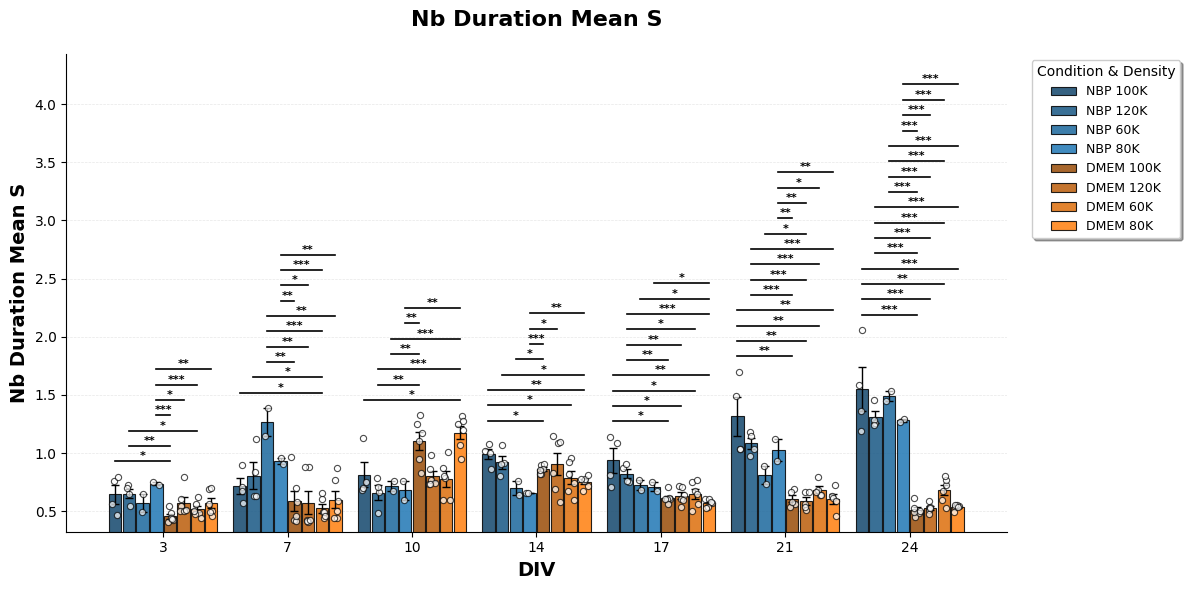

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_SameColorMedia/nb_ibi_mean_s_250414.png


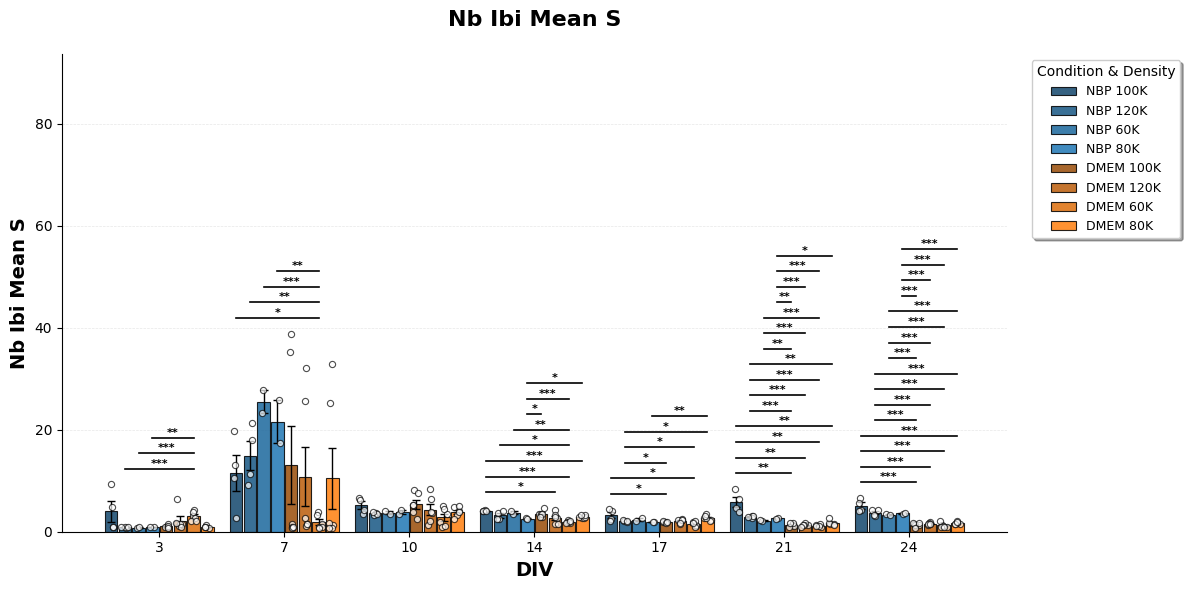

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_SameColorMedia/nb_spikes_per_burst_mean_250414.png


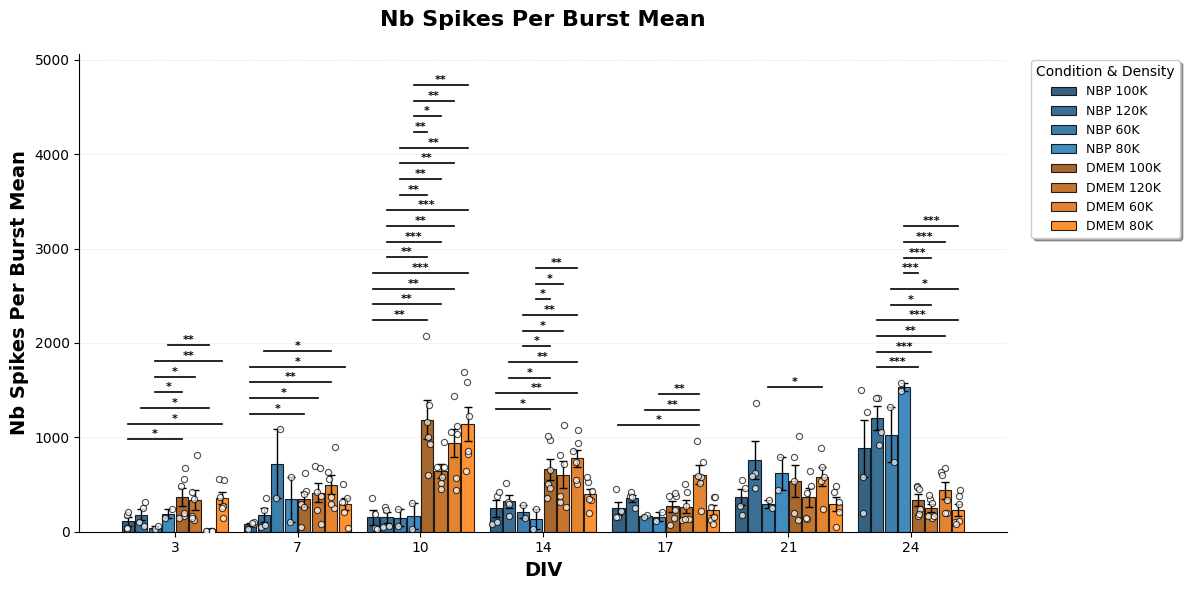

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_SameColorMedia/nb_energy_mean_250414.png


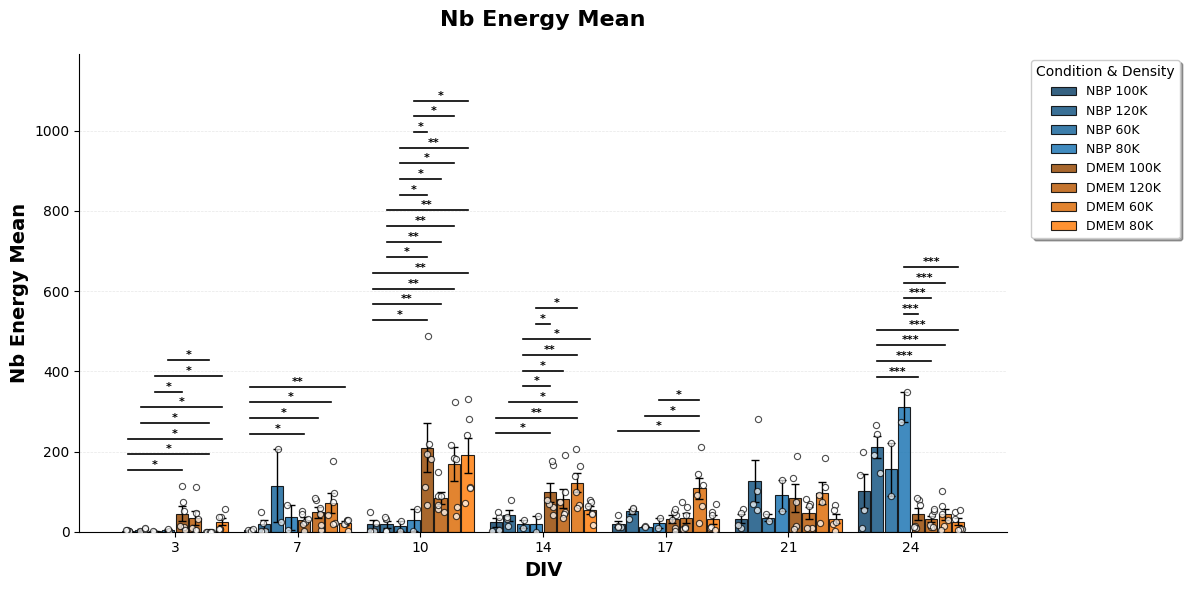

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_SameColorMedia/psib_250414.png


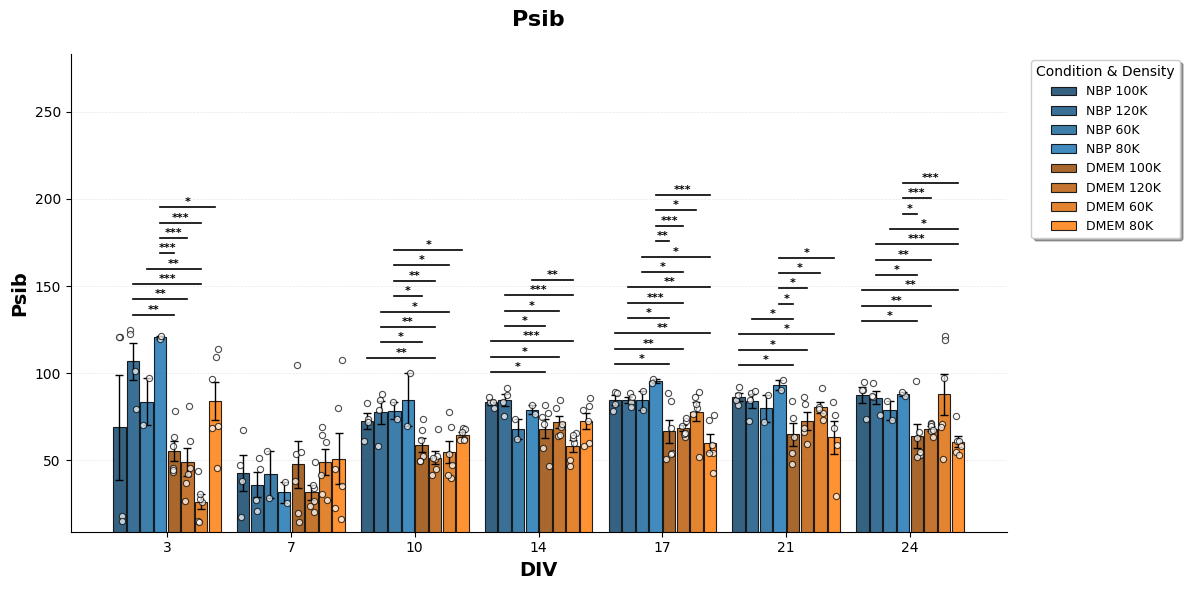

In [132]:
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

df = merged_df.copy()

# Create condition and density columns
def get_condition_and_density(neuron_source):
    if pd.isna(neuron_source) or str(neuron_source) == 'nan':
        return None, None
    ns = str(neuron_source)
    if 'NBP' in ns:
        condition = 'NBP'
    elif 'DMEM' in ns:
        condition = 'DMEM'
    else:
        return None, None
    
    # Extract density (e.g., "60K", "80K")
    parts = ns.split()
    density = parts[0] if len(parts) > 0 else ns.split('K')[0] + 'K'
    return condition, density

df[['Condition', 'Density']] = df['Neuron Source'].apply(
    lambda x: pd.Series(get_condition_and_density(x))
)
df = df.dropna(subset=['Condition', 'Density'])

output_types = ['nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
                'nb_spikes_per_burst_mean', 'nb_energy_mean', 'psib']

div = sorted(df['DIV'].unique())

# Get unique densities for each condition
nbp_densities = sorted(df[df['Condition'] == 'NBP']['Density'].unique())
dmem_densities = sorted(df[df['Condition'] == 'DMEM']['Density'].unique())

# Combine all genotypes (density labels) maintaining their condition
all_genotypes = [f"NBP {d}" for d in nbp_densities] + [f"DMEM {d}" for d in dmem_densities]

# Create colors: shades of blue for NBP, shades of orange for DMEM
nbp_base_color = np.array([31, 119, 180]) / 255  # Blue
dmem_base_color = np.array([255, 127, 14]) / 255  # Orange

def create_color_shades(base_color, n_shades):
    """Create n different shades of a base color"""
    shades = []
    for i in range(n_shades):
        # Vary lightness: darker to lighter
        factor = 0.6 + (0.4 * i / max(1, n_shades - 1))
        shade = base_color * factor
        shade = np.clip(shade, 0, 1)
        shades.append(shade)
    return shades

nbp_colors = create_color_shades(nbp_base_color, len(nbp_densities))
dmem_colors = create_color_shades(dmem_base_color, len(dmem_densities))
colors = nbp_colors + dmem_colors

for output_type in output_types:
    total_genotypes = len(all_genotypes)
    
    # Initialize output arrays for each genotype
    output_arrays = {genotype: [] for genotype in all_genotypes}
    
    # Fill data from data frame
    for i in div:
        for genotype in all_genotypes:
            condition, density = genotype.split(' ', 1)
            temp_df = df.loc[(df['DIV'] == i) & 
                            (df['Condition'] == condition) & 
                            (df['Density'] == density)]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
    
    # Dynamic bar width based on number of genotypes
    bar_width = 0.8 / total_genotypes
    gap_between_bars = 0.01
    
    # Create x-coordinates of bars for each genotype group
    x_genotype = {genotype: [] for genotype in all_genotypes}
    base_x_coordinate = np.arange(len(div))
    offset = (total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars) / 2
    centered_x = base_x_coordinate - offset + bar_width / 2
    
    for i, genotype in enumerate(all_genotypes):
        x_genotype[genotype] = centered_x + i * (bar_width + gap_between_bars)
    
    # Larger figure size
    fig_width = max(12, len(div) * 1.5)
    fig_height = 6
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Plot data for each genotype
    mean_data_all = {}
    yerr_data_all = {}
    n_data_all = {}
    condition_data = {}  # Track which condition each genotype belongs to
    
    for i, genotype in enumerate(all_genotypes):
        y_data = output_arrays[genotype]
        condition = genotype.split(' ', 1)[0]
        condition_data[genotype] = condition
        
        # Calculate statistics
        mean_data = [np.mean([n for n in yi if np.isfinite(n)]) if len([n for n in yi if np.isfinite(n)]) > 0 else 0 
                     for yi in y_data]
        yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1) / np.sqrt(len([n for n in yi if np.isfinite(n)])) 
                     if len([n for n in yi if np.isfinite(n)]) > 1 else 0 
                     for yi in y_data]
        n_data = [len([n for n in yi if np.isfinite(n)]) for yi in y_data]
        
        # Store statistics in dictionaries
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        
        # Plot bars
        ax.bar(x_genotype[genotype], mean_data, yerr=yerr_data, capsize=3, 
               width=bar_width, color=colors[i], edgecolor='black', linewidth=0.8,
               ecolor='black', label=genotype, alpha=0.85, error_kw={'linewidth': 1})
        
        # Plot scatter points
        jitter_amount = bar_width * 0.3
        for j in range(len(x_genotype[genotype])):
            for k in range(len(y_data[j])):
                if np.isfinite(y_data[j][k]):
                    ax.scatter(
                        x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount),
                        y_data[j][k],
                        s=20,
                        color='white',
                        marker='o',
                        edgecolors='black',
                        linewidths=0.8,
                        alpha=0.7,
                        zorder=3
                    )
    
    # Calculate significance and determine y-axis limits dynamically
    all_valid_values = []
    for genotype_arrays in output_arrays.values():
        for array in genotype_arrays:
            valid_vals = [v for v in array if np.isfinite(v)]
            all_valid_values.extend(valid_vals)
    
    if len(all_valid_values) > 0:
        data_max = max(all_valid_values)
        data_min = min(all_valid_values)
        data_range = data_max - data_min if data_max > data_min else data_max
        
        # Perform t-tests ONLY between NBP and DMEM conditions (not within conditions)
        for i in range(len(base_x_coordinate)):
            # Get max for this specific DIV
            div_max_values = []
            for genotype in all_genotypes:
                valid_vals = [v for v in output_arrays[genotype][i] if np.isfinite(v)]
                if valid_vals:
                    div_max_values.append(max(valid_vals))
            
            if not div_max_values:
                continue
                
            maxim = max(div_max_values)
            count = 1
            
            # Only compare between different conditions (NBP vs DMEM)
            for j, genotype1 in enumerate(all_genotypes):
                for k, genotype2 in enumerate(all_genotypes):
                    if j < k:
                        condition1 = condition_data[genotype1]
                        condition2 = condition_data[genotype2]
                        
                        # ONLY compare if conditions are different
                        if condition1 == condition2:
                            continue
                        
                        mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                        mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                        
                        # Skip if not enough data
                        if n1 < 2 or n2 < 2 or sem1 == 0 or sem2 == 0:
                            continue
                        
                        sed = sqrt(sem1**2.0 + sem2**2.0)
                        t_stat = (mean1 - mean2) / sed
                        degreef = n1 + n2 - 2
                        p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                        
                        x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                        sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                        
                        if sign != 'ns':
                            # Dynamic y-position for significance bars
                            y_pos = maxim + 0.08 * data_range * count
                            ax.plot([x1, x2], [y_pos, y_pos], 'k', linewidth=1.2)
                            ax.text((x1 + x2) / 2, y_pos, sign, ha='center', va='bottom', fontsize=8, fontweight='bold')
                            count += 1
        
        # Count only cross-condition comparisons for y-limit
        n_nbp = len(nbp_densities)
        n_dmem = len(dmem_densities)
        max_cross_comparisons = n_nbp * n_dmem
        
        y_max = data_max + 0.08 * data_range * (max_cross_comparisons + 2)
        y_min = max(0, data_min - 0.05 * data_range)
        ax.set_ylim(y_min, y_max)
    
    # Better plot aesthetics
    ax.set_title(f"{output_type.replace('_', ' ').title()}", fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('DIV', fontsize=14, fontweight='bold')
    ax.set_ylabel(f"{output_type.replace('_', ' ').title()}", fontsize=14, fontweight='bold')
    ax.set_xticks(base_x_coordinate)
    ax.set_xticklabels(div, fontsize=11)
    ax.tick_params(axis='both', labelsize=10)
    
    # Better legend placement
    ax.legend(title='Condition & Density', loc='upper left', bbox_to_anchor=(1.02, 1), 
              fontsize=9, title_fontsize=10, frameon=True, fancybox=True, shadow=True)
    
    # Grid for better readability
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    outdir = "/mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_SameColorMedia"
    os.makedirs(outdir, exist_ok=True)

    safe_output_type = output_type.replace(" ", "_").replace("/", "_")
    fname = f"{safe_output_type}_{plating_date}.png"
    savepath = os.path.join(outdir, fname)

    fig.savefig(savepath, dpi=300, bbox_inches='tight', format='png')
    print(f"Saved figure to: {savepath}")
    plt.tight_layout()
    plt.show()

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_OnlySameDensitiesCompared/nb_count_250414.png


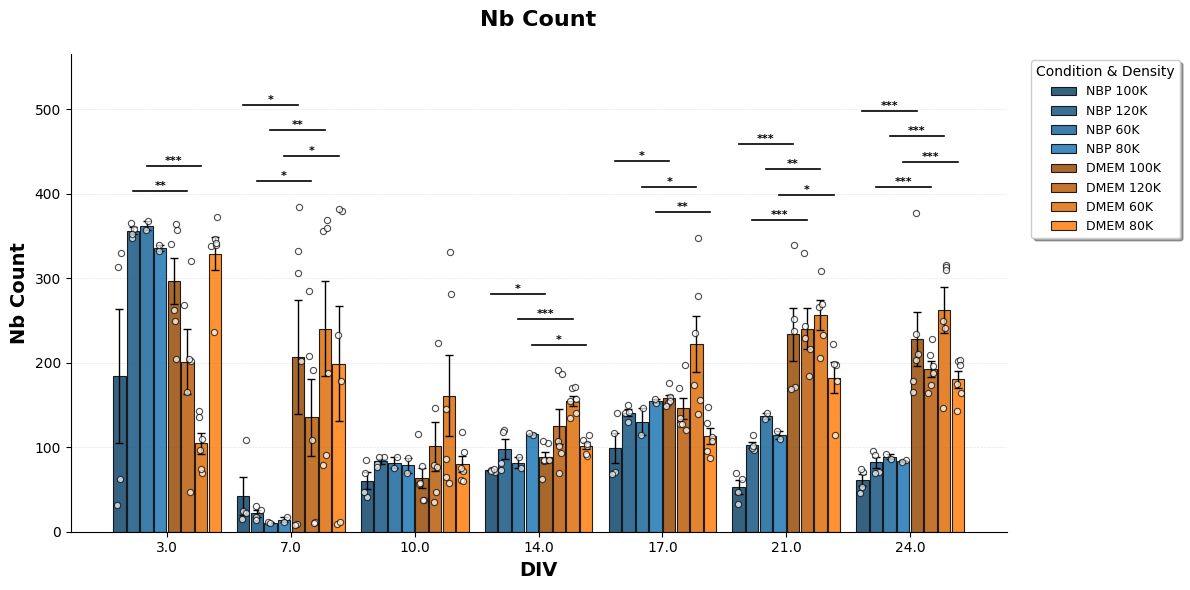

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_OnlySameDensitiesCompared/nb_rate_hz_250414.png


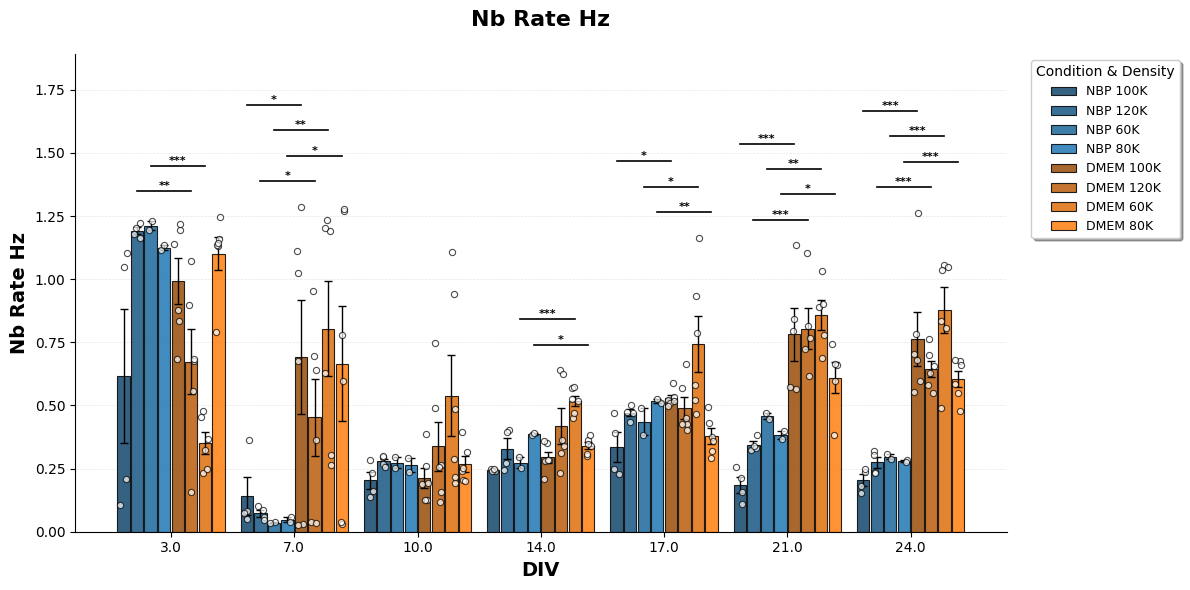

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_OnlySameDensitiesCompared/nb_duration_mean_s_250414.png


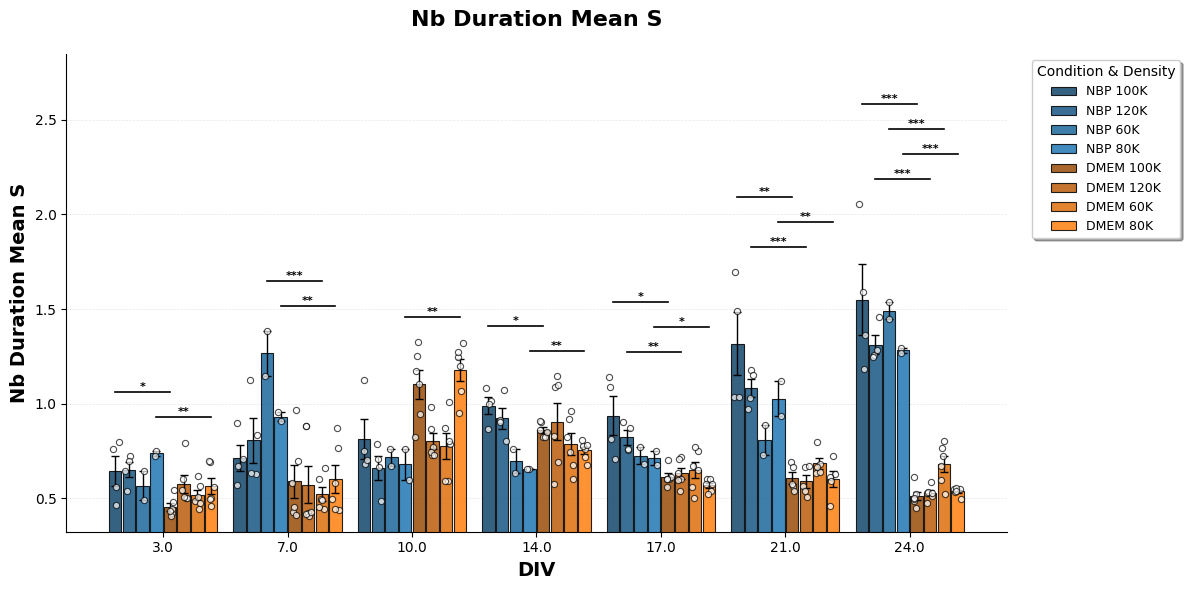

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_OnlySameDensitiesCompared/nb_ibi_mean_s_250414.png


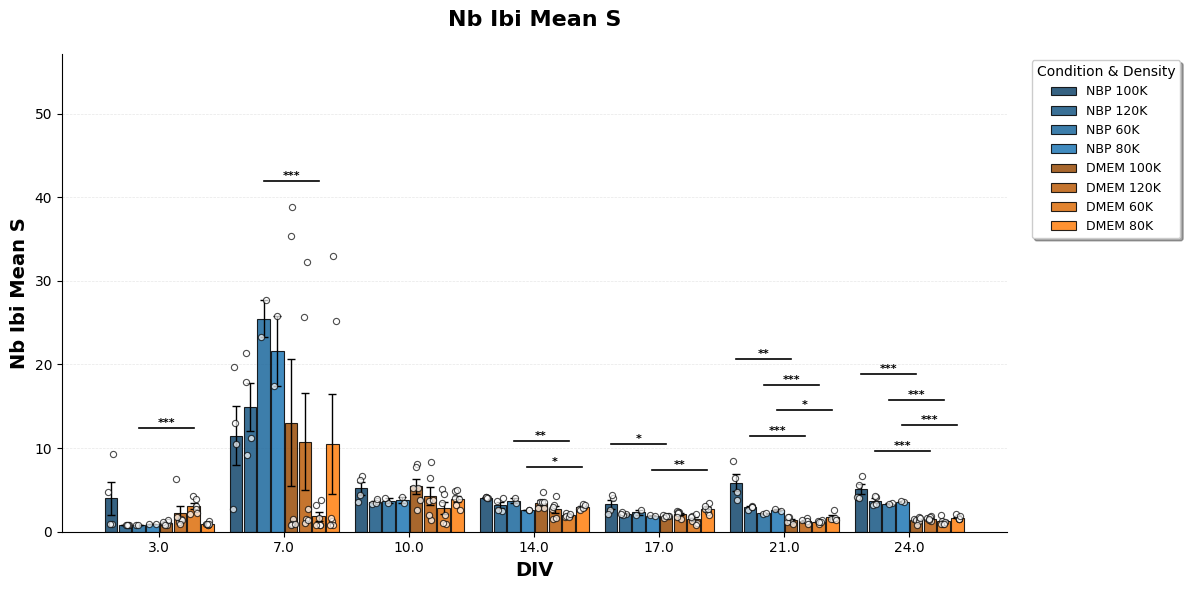

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_OnlySameDensitiesCompared/nb_spikes_per_burst_mean_250414.png


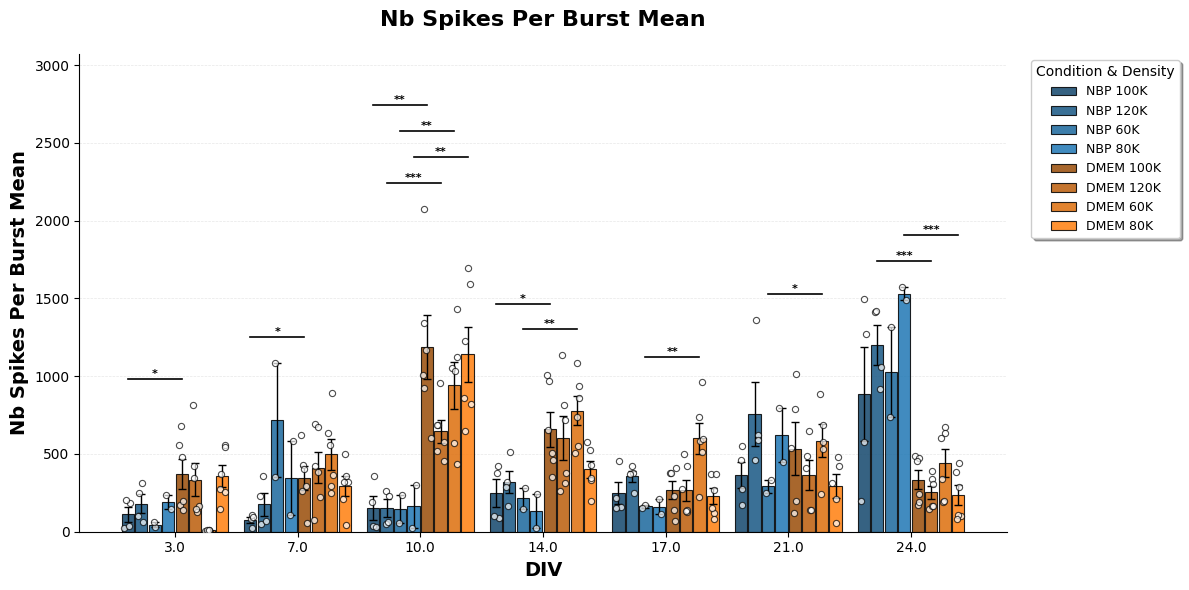

Saved figure to: /mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_OnlySameDensitiesCompared/nb_energy_mean_250414.png


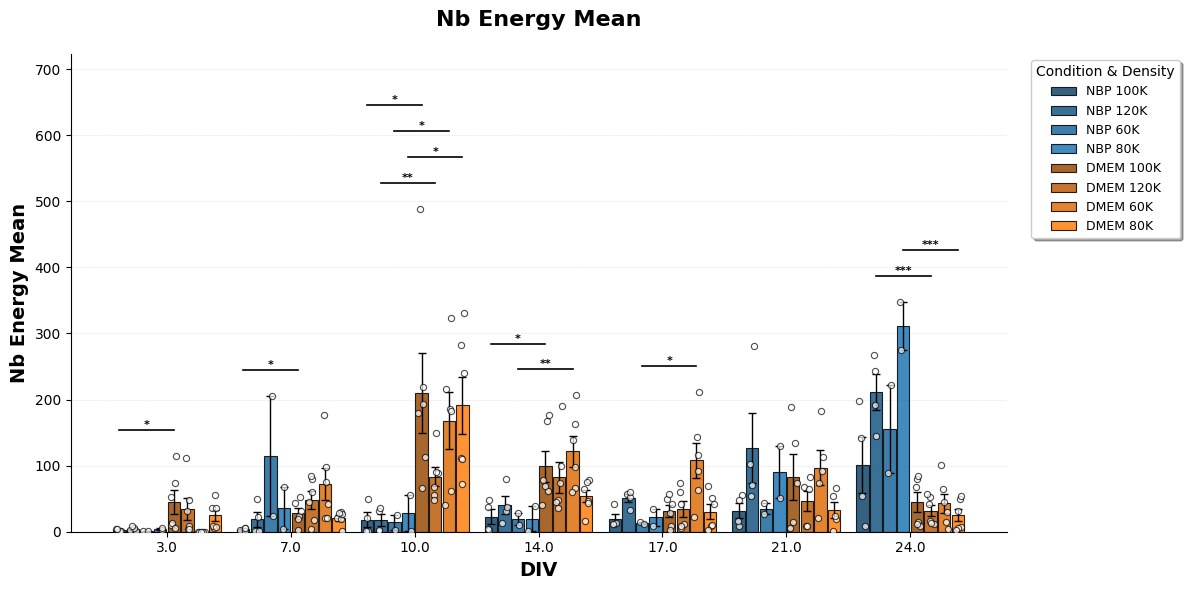

In [225]:
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

df = merged_df.copy()

# Create condition and density columns
def get_condition_and_density(neuron_source):
    if pd.isna(neuron_source) or str(neuron_source) == 'nan':
        return None, None
    ns = str(neuron_source)
    if 'NBP' in ns:
        condition = 'NBP'
    elif 'DMEM' in ns:
        condition = 'DMEM'
    else:
        return None, None
    
    # Extract density (e.g., "60K", "80K")
    parts = ns.split()
    density = parts[0] if len(parts) > 0 else ns.split('K')[0] + 'K'
    return condition, density

df[['Condition', 'Density']] = df['Neuron Source'].apply(
    lambda x: pd.Series(get_condition_and_density(x))
)
df = df.dropna(subset=['Condition', 'Density'])

output_types = ['nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
                'nb_spikes_per_burst_mean', 'nb_energy_mean']

div = sorted(df['DIV'].unique())

# Get unique densities for each condition
nbp_densities = sorted(df[df['Condition'] == 'NBP']['Density'].unique())
dmem_densities = sorted(df[df['Condition'] == 'DMEM']['Density'].unique())

# Combine all genotypes (density labels) maintaining their condition
all_genotypes = [f"NBP {d}" for d in nbp_densities] + [f"DMEM {d}" for d in dmem_densities]



# Create colors: shades of blue for NBP, shades of orange for DMEM
nbp_base_color = np.array([31, 119, 180]) / 255  # Blue
dmem_base_color = np.array([255, 127, 14]) / 255  # Orange

def create_color_shades(base_color, n_shades):
    """Create n different shades of a base color"""
    shades = []
    for i in range(n_shades):
        # Vary lightness: darker to lighter
        factor = 0.6 + (0.4 * i / max(1, n_shades - 1))
        shade = base_color * factor
        shade = np.clip(shade, 0, 1)
        shades.append(shade)
    return shades

nbp_colors = create_color_shades(nbp_base_color, len(nbp_densities))
dmem_colors = create_color_shades(dmem_base_color, len(dmem_densities))
colors = nbp_colors + dmem_colors

for output_type in output_types:
    total_genotypes = len(all_genotypes)
    
    # Initialize output arrays for each genotype
    output_arrays = {genotype: [] for genotype in all_genotypes}
    
    # Fill data from data frame
    for i in div:
        for genotype in all_genotypes:
            condition, density = genotype.split(' ', 1)
            temp_df = df.loc[(df['DIV'] == i) & 
                            (df['Condition'] == condition) & 
                            (df['Density'] == density)]
            output_arrays[genotype].append(np.array(temp_df[output_type]))
    
    # Dynamic bar width based on number of genotypes
    bar_width = 0.8 / total_genotypes
    gap_between_bars = 0.01
    
    # Create x-coordinates of bars for each genotype group
    x_genotype = {genotype: [] for genotype in all_genotypes}
    base_x_coordinate = np.arange(len(div))
    offset = (total_genotypes * bar_width + (total_genotypes - 1) * gap_between_bars) / 2
    centered_x = base_x_coordinate - offset + bar_width / 2
    
    for i, genotype in enumerate(all_genotypes):
        x_genotype[genotype] = centered_x + i * (bar_width + gap_between_bars)
    
    # Larger figure size
    fig_width = max(12, len(div) * 1.5)
    fig_height = 6
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Plot data for each genotype
    mean_data_all = {}
    yerr_data_all = {}
    n_data_all = {}
    
    for i, genotype in enumerate(all_genotypes):
        y_data = output_arrays[genotype]
        
        # Calculate statistics
        mean_data = [np.mean([n for n in yi if np.isfinite(n)]) if len([n for n in yi if np.isfinite(n)]) > 0 else 0 
                     for yi in y_data]
        yerr_data = [np.std([n for n in yi if np.isfinite(n)], ddof=1) / np.sqrt(len([n for n in yi if np.isfinite(n)])) 
                     if len([n for n in yi if np.isfinite(n)]) > 1 else 0 
                     for yi in y_data]
        n_data = [len([n for n in yi if np.isfinite(n)]) for yi in y_data]
        
        # Store statistics in dictionaries
        mean_data_all[genotype] = mean_data
        yerr_data_all[genotype] = yerr_data
        n_data_all[genotype] = n_data
        
        # Plot bars
        ax.bar(x_genotype[genotype], mean_data, yerr=yerr_data, capsize=3, 
               width=bar_width, color=colors[i], edgecolor='black', linewidth=0.8,
               ecolor='black', label=genotype, alpha=0.85, error_kw={'linewidth': 1})
        
        # Plot scatter points
        jitter_amount = bar_width * 0.3
        for j in range(len(x_genotype[genotype])):
            for k in range(len(y_data[j])):
                if np.isfinite(y_data[j][k]):
                    ax.scatter(
                        x_genotype[genotype][j] + np.random.uniform(-jitter_amount, jitter_amount),
                        y_data[j][k],
                        s=20,
                        color='white',
                        marker='o',
                        edgecolors='black',
                        linewidths=0.8,
                        alpha=0.7,
                        zorder=3
                    )
    
    # Calculate significance and determine y-axis limits dynamically
    all_valid_values = []
    for genotype_arrays in output_arrays.values():
        for array in genotype_arrays:
            valid_vals = [v for v in array if np.isfinite(v)]
            all_valid_values.extend(valid_vals)
    
    if len(all_valid_values) > 0:
        data_max = max(all_valid_values)
        data_min = min(all_valid_values)
        data_range = data_max - data_min if data_max > data_min else data_max
        
        # Perform t-tests ONLY between matching densities (NBP 60K vs DMEM 60K, etc.)
        for i in range(len(base_x_coordinate)):
            # Get max for this specific DIV
            div_max_values = []
            for genotype in all_genotypes:
                valid_vals = [v for v in output_arrays[genotype][i] if np.isfinite(v)]
                if valid_vals:
                    div_max_values.append(max(valid_vals))
            
            if not div_max_values:
                continue
                
            maxim = max(div_max_values)
            count = 1
            
            # Compare only matching densities between NBP and DMEM
            # Get all unique densities present in the data
            all_densities = set(nbp_densities).union(set(dmem_densities))
            
            for density in all_densities:
                genotype1 = f"NBP {density}"
                genotype2 = f"DMEM {density}"
                
                # Check if both genotypes exist in our data
                if genotype1 not in all_genotypes or genotype2 not in all_genotypes:
                    continue
                
                mean1, sem1, n1 = mean_data_all[genotype1][i], yerr_data_all[genotype1][i], n_data_all[genotype1][i]
                mean2, sem2, n2 = mean_data_all[genotype2][i], yerr_data_all[genotype2][i], n_data_all[genotype2][i]
                
                # Skip if not enough data
                if n1 < 2 or n2 < 2 or sem1 == 0 or sem2 == 0:
                    continue
                
                sed = sqrt(sem1**2.0 + sem2**2.0)
                t_stat = (mean1 - mean2) / sed
                degreef = n1 + n2 - 2
                p_value = (1.0 - stats.t.cdf(abs(t_stat), degreef)) * 2.0
                
                x1, x2 = x_genotype[genotype1][i], x_genotype[genotype2][i]
                sign = "***" if p_value <= 0.001 else "**" if p_value <= 0.01 else "*" if p_value <= 0.05 else "ns"
                
                if sign != 'ns':
                    # Dynamic y-position for significance bars
                    y_pos = maxim + 0.08 * data_range * count
                    ax.plot([x1, x2], [y_pos, y_pos], 'k', linewidth=1.2)
                    ax.text((x1 + x2) / 2, y_pos, sign, ha='center', va='bottom', fontsize=8, fontweight='bold')
                    count += 1
        
        # Count only matching density comparisons for y-limit
        max_comparisons = len(set(nbp_densities).intersection(set(dmem_densities)))
        
        y_max = data_max + 0.08 * data_range * (max_comparisons + 2)
        y_min = max(0, data_min - 0.05 * data_range)
        ax.set_ylim(y_min, y_max)
    
    # Better plot aesthetics
    ax.set_title(f"{output_type.replace('_', ' ').title()}", fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('DIV', fontsize=14, fontweight='bold')
    ax.set_ylabel(f"{output_type.replace('_', ' ').title()}", fontsize=14, fontweight='bold')
    ax.set_xticks(base_x_coordinate)
    ax.set_xticklabels(div, fontsize=11)
    ax.tick_params(axis='both', labelsize=10)
    
    # Better legend placement
    ax.legend(title='Condition & Density', loc='upper left', bbox_to_anchor=(1.02, 1), 
              fontsize=9, title_fontsize=10, frameon=True, fancybox=True, shadow=True)
    
    # Grid for better readability
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    outdir = "/mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_OnlySameDensitiesCompared"
    os.makedirs(outdir, exist_ok=True)

    safe_output_type = output_type.replace(" ", "_").replace("/", "_")
    fname = f"{safe_output_type}_{plating_date}.png"
    savepath = os.path.join(outdir, fname)

    fig.savefig(savepath, dpi=300, bbox_inches='tight', format='png')
    print(f"Saved figure to: {savepath}")
    plt.tight_layout()
    plt.show()

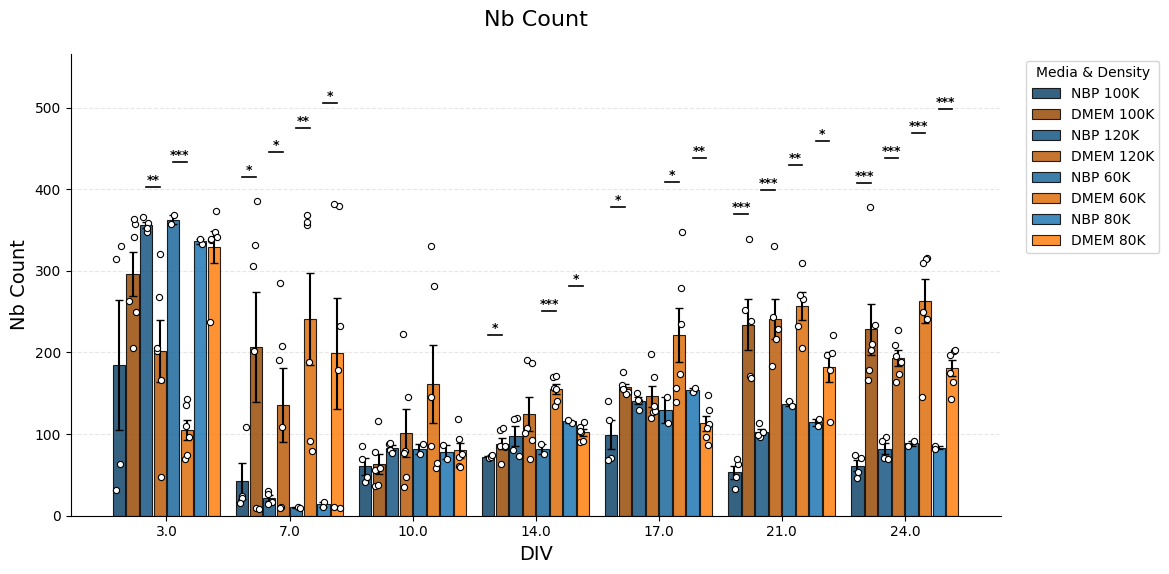

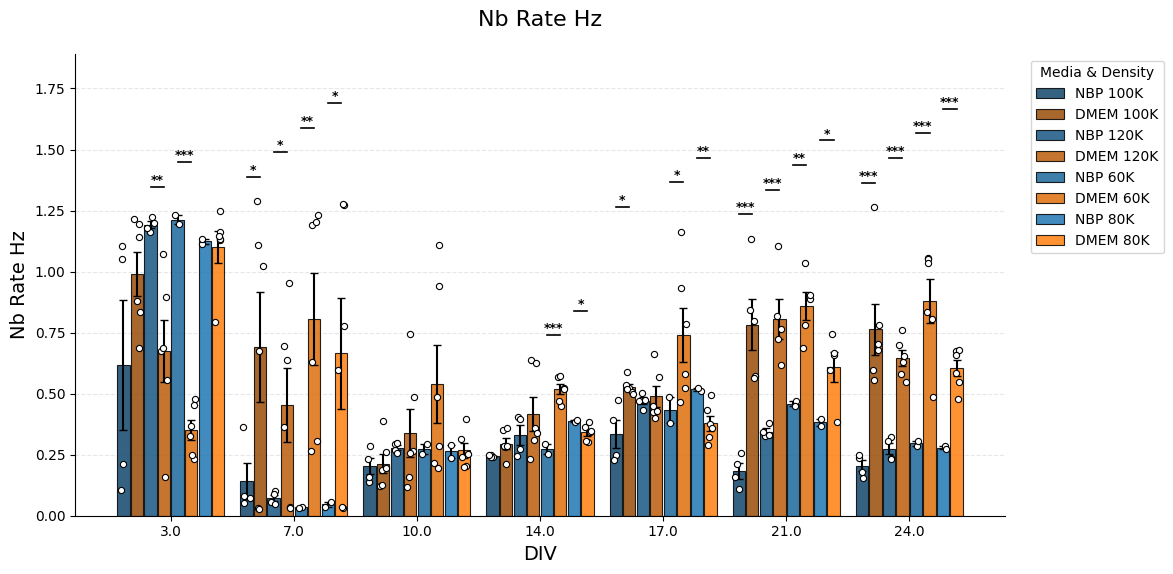

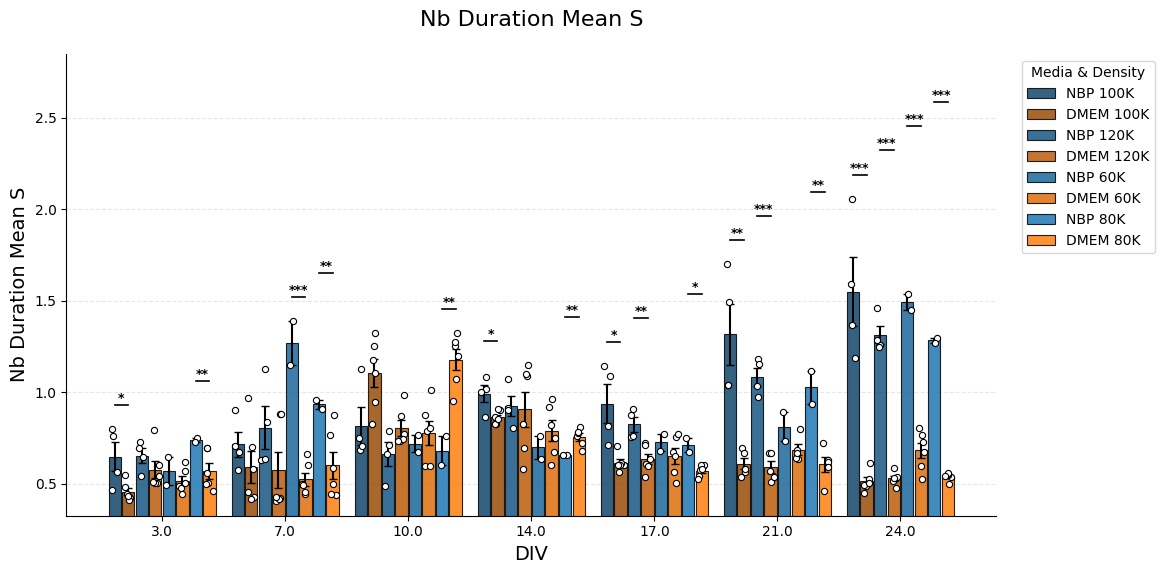

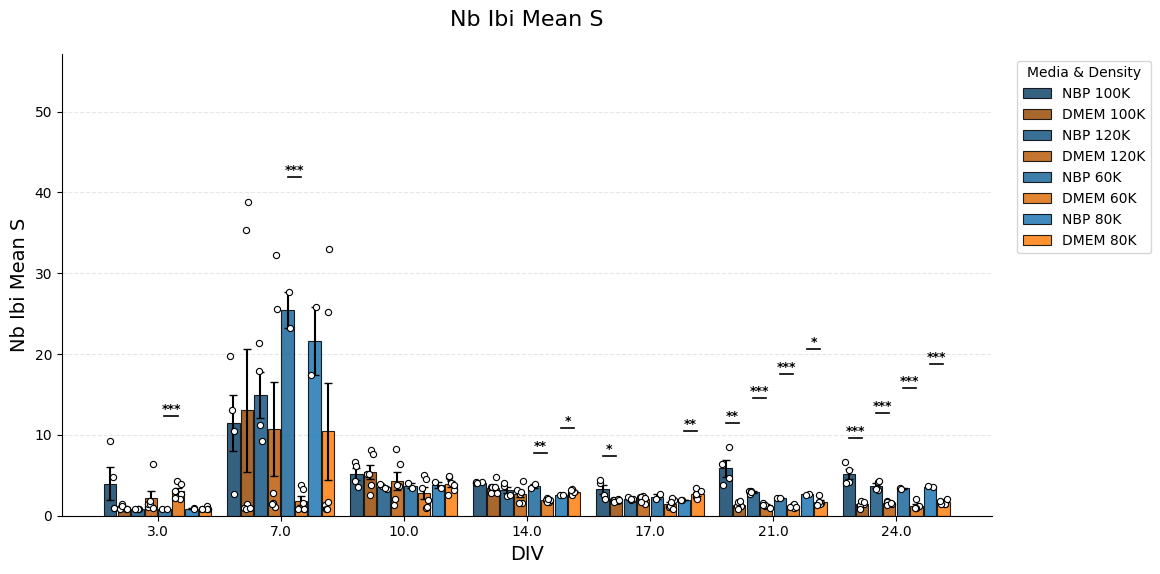

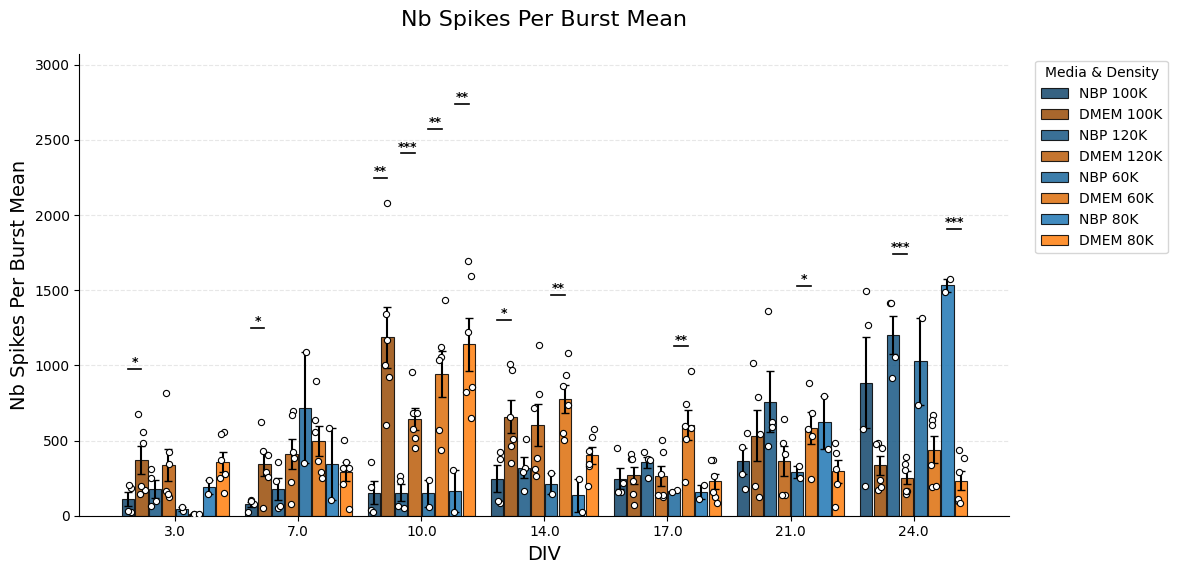

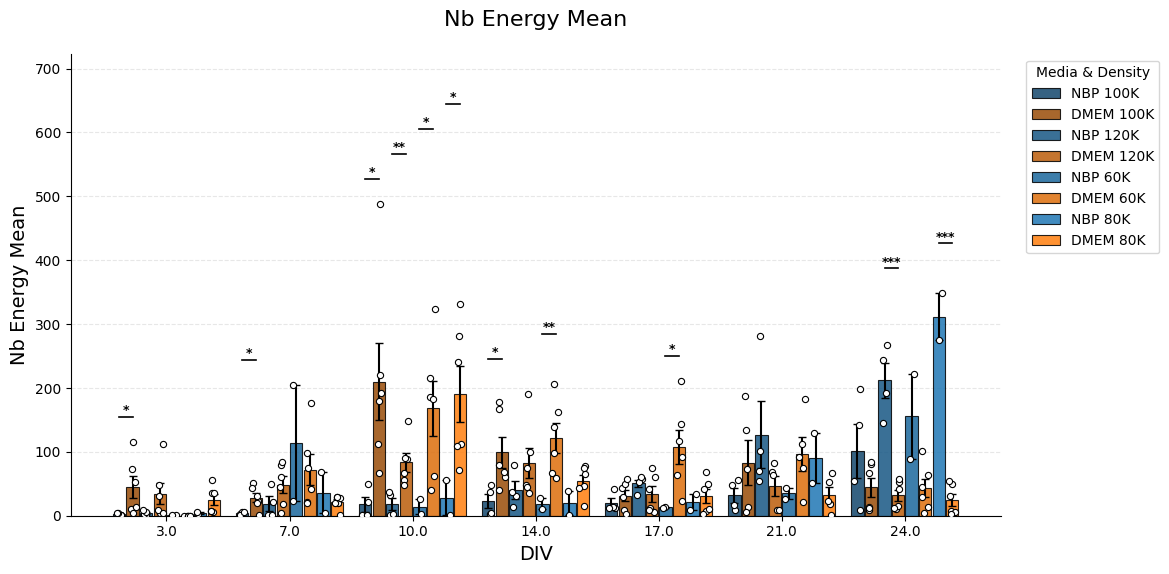

In [230]:
from math import sqrt
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

df = merged_df.copy()

# =========================
# CONDITION & DENSITY PARSING
# =========================
def get_condition_and_density(neuron_source):
    if pd.isna(neuron_source):
        return None, None

    ns = str(neuron_source)

    if 'NBP' in ns:
        condition = 'NBP'
    elif 'DMEM' in ns:
        condition = 'DMEM'
    else:
        return None, None

    density = ns.split()[0]  # e.g. "60K"
    return condition, density

df[['Condition', 'Density']] = df['Neuron Source'].apply(
    lambda x: pd.Series(get_condition_and_density(x))
)
df = df.dropna(subset=['Condition', 'Density'])

# =========================
# METRICS & DIVS
# =========================
output_types = [
    'nb_count', 'nb_rate_hz', 'nb_duration_mean_s', 'nb_ibi_mean_s',
    'nb_spikes_per_burst_mean', 'nb_energy_mean'
]

div = sorted(df['DIV'].unique())

# =========================
# DENSITY-FIRST GENOTYPE ORDERING
# =========================
nbp_densities = sorted(df[df['Condition'] == 'NBP']['Density'].unique())
dmem_densities = sorted(df[df['Condition'] == 'DMEM']['Density'].unique())

all_densities = sorted(set(nbp_densities) | set(dmem_densities))

all_genotypes = []
for d in all_densities:
    if d in nbp_densities:
        all_genotypes.append(f"NBP {d}")
    if d in dmem_densities:
        all_genotypes.append(f"DMEM {d}")

# =========================
# COLOR HANDLING (FIXED)
# =========================
nbp_base_color = np.array([31, 119, 180]) / 255
dmem_base_color = np.array([255, 127, 14]) / 255

def create_color_shades(base_color, n):
    shades = []
    for i in range(n):
        factor = 0.6 + 0.4 * i / max(1, n - 1)
        shades.append(np.clip(base_color * factor, 0, 1))
    return shades

nbp_colors = create_color_shades(nbp_base_color, len(nbp_densities))
dmem_colors = create_color_shades(dmem_base_color, len(dmem_densities))

color_map = {}
for d, c in zip(nbp_densities, nbp_colors):
    color_map[f"NBP {d}"] = c
for d, c in zip(dmem_densities, dmem_colors):
    color_map[f"DMEM {d}"] = c

colors = [color_map[g] for g in all_genotypes]
# =========================
# MAIN PLOTTING LOOP
# =========================
for output_type in output_types:

    output_arrays = {g: [] for g in all_genotypes}

    for d in div:
        for g in all_genotypes:
            cond, dens = g.split()
            temp = df[
                (df['DIV'] == d) &
                (df['Condition'] == cond) &
                (df['Density'] == dens)
            ]
            output_arrays[g].append(np.array(temp[output_type]))

    total_genotypes = len(all_genotypes)
    bar_width = 0.8 / total_genotypes
    gap = 0.01

    base_x = np.arange(len(div))
    offset = (total_genotypes * bar_width + (total_genotypes - 1) * gap) / 2
    centered_x = base_x - offset + bar_width / 2

    x_genotype = {
        g: centered_x + i * (bar_width + gap)
        for i, g in enumerate(all_genotypes)
    }

    fig, ax = plt.subplots(figsize=(max(12, len(div) * 1.5), 6))

    mean_all, sem_all, n_all = {}, {}, {}

    # =========================
    # BAR PLOTTING
    # =========================
    for i, g in enumerate(all_genotypes):

        y_data = output_arrays[g]

        means = [np.nanmean(y) if len(y) else np.nan for y in y_data]
        sems = [
            np.nanstd(y, ddof=1) / np.sqrt(np.sum(np.isfinite(y)))
            if np.sum(np.isfinite(y)) > 1 else np.nan
            for y in y_data
        ]
        ns = [np.sum(np.isfinite(y)) for y in y_data]

        mean_all[g] = means
        sem_all[g] = sems
        n_all[g] = ns

        ax.bar(
            x_genotype[g],
            means,
            yerr=sems,
            capsize=3,
            width=bar_width,
            color=colors[i],
            edgecolor='black',
            linewidth=0.8,
            label=g,
            alpha=0.85
        )

        # Scatter overlay
        jitter = bar_width * 0.3
        for j in range(len(div)):
            for val in y_data[j]:
                if np.isfinite(val):
                    ax.scatter(
                        x_genotype[g][j] + np.random.uniform(-jitter, jitter),
                        val,
                        s=20,
                        color='white',
                        edgecolors='black',
                        linewidths=0.8,
                        zorder=3
                    )

    # =========================
    # SIGNIFICANCE TESTS
    # SAME DENSITY ONLY (NBP vs DMEM)
    # =========================
    common_densities = sorted(set(nbp_densities) & set(dmem_densities))

    all_valid = [
        v for g in output_arrays.values()
        for arr in g
        for v in arr if np.isfinite(v)
    ]

    if len(all_valid) > 0:

        data_max = max(all_valid)
        data_min = min(all_valid)
        data_range = data_max - data_min if data_max > data_min else data_max

        for i_div in range(len(div)):

            # highest point at this DIV
            div_vals = []
            for g in all_genotypes:
                vals = [v for v in output_arrays[g][i_div] if np.isfinite(v)]
                if vals:
                    div_vals.append(max(vals))

            if not div_vals:
                continue

            y_base = max(div_vals)
            stack = 1

            for density in common_densities:

                g1 = f"NBP {density}"
                g2 = f"DMEM {density}"

                n1, n2 = n_all[g1][i_div], n_all[g2][i_div]
                sem1, sem2 = sem_all[g1][i_div], sem_all[g2][i_div]

                if n1 < 2 or n2 < 2 or np.isnan(sem1) or np.isnan(sem2):
                    continue

                mean1 = mean_all[g1][i_div]
                mean2 = mean_all[g2][i_div]

                sed = np.sqrt(sem1**2 + sem2**2)
                t_stat = (mean1 - mean2) / sed
                dfree = n1 + n2 - 2
                p = 2 * (1 - stats.t.cdf(abs(t_stat), dfree))

                if p <= 0.001:
                    label = "***"
                elif p <= 0.01:
                    label = "**"
                elif p <= 0.05:
                    label = "*"
                else:
                    continue

                x1 = x_genotype[g1][i_div]
                x2 = x_genotype[g2][i_div]
                y = y_base + 0.08 * data_range * stack

                ax.plot([x1, x2], [y, y], 'k', lw=1.2)
                ax.text((x1 + x2) / 2, y, label,
                        ha='center', va='bottom',
                        fontsize=9, fontweight='bold')

                stack += 1

        ax.set_ylim(
            max(0, data_min - 0.05 * data_range),
            data_max + 0.08 * data_range * (len(common_densities) + 2)
        )

    # =========================
    # AESTHETICS (RESTORED)
    # =========================
    title = output_type.replace('_', ' ').title()
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('DIV', fontsize=14)
    ax.set_ylabel(title, fontsize=14)

    ax.set_xticks(base_x)
    ax.set_xticklabels(div)

    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    ax.spines[['top', 'right']].set_visible(False)

    ax.legend(
        title='Media & Density',
        bbox_to_anchor=(1.02, 1),
        loc='upper left'
    )

    outdir = "/mnt/benshalom-nas/analysis/BatchTest/BatchTest_MediaDensityComparison/MediaDensityV2figures_SameColorMedia_Adjacent"
    os.makedirs(outdir, exist_ok=True)

    fname = f"{output_type}_{plating_date}.png"
    fig.savefig(os.path.join(outdir, fname), dpi=300, bbox_inches='tight')
    plt.show()


In [2]:
pip install cairosvg

  Using cached cairosvg-2.8.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached cairocffi-1.7.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached cssselect2-0.8.0-py3-none-any.whl.metadata (2.9 kB)
Using cached cairosvg-2.8.2-py3-none-any.whl (45 kB)
Using cached cairocffi-1.7.1-py3-none-any.whl (75 kB)
Using cached cssselect2-0.8.0-py3-none-any.whl (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [cairosvg]━━━━━━━━━ 2/3 [cairosvg]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import cairosvg
from io import BytesIO
from PIL import Image

# Define paths
base_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/B6J_PSYCHEDELICS_T1_11252025_PS/251216/M08034/Network/"
output_dir = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/B6J_PSYCHEDELICS_T1_11252025_PS//fixed_y/combined_rasters_251216"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define runs and wells
runs = ['000073', '000079', '000089']
run_labels = ['Baseline', 'Acute (Post-Drug)', '1.5hr Post']
wells = ['well000', 'well001', 'well002', 'well003', 'well004', 'well005']
well_treatments = {
    'well000': 'P2W1 - Ketanserin salt',
    'well001': 'P2W2 - BDNF',
    'well002': 'P2W3 - untreated (1st neg)',
    'well003': 'P2W4 - 5-MeO DMT - Treatment A',
    'well004': 'P2W5 - DMSO',
    'well005': 'P2W6 - LSD - Treatment B'
}

def svg_to_png(svg_path):
    """Convert SVG to PNG for matplotlib display"""
    try:
        png_data = cairosvg.svg2png(url=svg_path)
        img = Image.open(BytesIO(png_data))
        return img
    except Exception as e:
        print(f"Error converting {svg_path}: {e}")
        return None

def format_path_title(full_path):
    """Extract path starting from AnalyzedData and format with line break after run ID"""
    if "AnalyzedData" in full_path:
        shortened = full_path.split("AnalyzedData/")[1]
        # Find the run ID (6-digit number) and add line break after it
        parts = shortened.split('/')
        for i, part in enumerate(parts):
            if part.isdigit() and len(part) == 6:
                # Join parts before and including run, then add newline, then rest
                before_break = '/'.join(parts[:i+1])
                after_break = '/'.join(parts[i+1:])
                return f"{before_break}/\n{after_break}"
        return shortened
    return full_path

# Create individual well plots (6 files)
for well_idx, well in enumerate(wells):
    fig = plt.figure(figsize=(18, 6))
    gs = GridSpec(1, 3, figure=fig, hspace=0.3, wspace=0.3, 
                  top=0.85, bottom=0.05, left=0.05, right=0.95)
    
    well_name = well_treatments[well]
    fig.suptitle(f'{well_name}', fontsize=18, fontweight='bold', y=0.98)
    
    for run_idx, (run, label) in enumerate(zip(runs, run_labels)):
        svg_path = os.path.join(base_path, run, well, "fixed_y_raster_burst_plot_30s.svg")
        ax = fig.add_subplot(gs[0, run_idx])
        
        if os.path.exists(svg_path):
            try:
                img = svg_to_png(svg_path)
                if img is not None:
                    ax.imshow(img)
                    ax.axis('off')
                    
                    # Format and add title
                    formatted_path = format_path_title(svg_path)
                    ax.set_title(f"{label}\n{formatted_path}", fontsize=10, pad=10)
                else:
                    ax.text(0.5, 0.5, f'Error loading:\n{svg_path}', 
                           ha='center', va='center', fontsize=10)
                    ax.axis('off')
            except Exception as e:
                ax.text(0.5, 0.5, f'Error:\n{str(e)}', 
                       ha='center', va='center', fontsize=10)
                ax.axis('off')
        else:
            ax.text(0.5, 0.5, f'File not found:\n{svg_path}', 
                   ha='center', va='center', fontsize=10)
            ax.axis('off')
    
    # Save individual well plot
    output_path = os.path.join(output_dir, f"M08034_P2_{well}_rasters_30s.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {output_path}")
    plt.close()

# Create combined plot (1 file with all 6 wells)
fig = plt.figure(figsize=(24, 20))
gs = GridSpec(7, 3, figure=fig, hspace=0.5, wspace=0.3, 
              top=0.96, bottom=0.02, left=0.12, right=0.98)

# Add column headers
for col_idx, (run, label) in enumerate(zip(runs, run_labels)):
    ax = fig.add_subplot(gs[0, col_idx])
    ax.text(0.5, 0.5, label, ha='center', va='center', 
            fontsize=18, fontweight='bold')
    ax.axis('off')

# Process each well and run
for well_idx, well in enumerate(wells):
    for run_idx, run in enumerate(runs):
        svg_path = os.path.join(base_path, run, well, "fixed_y_raster_burst_plot_30s.svg")
        ax = fig.add_subplot(gs[well_idx + 1, run_idx])
        
        if os.path.exists(svg_path):
            try:
                img = svg_to_png(svg_path)
                if img is not None:
                    ax.imshow(img)
                    ax.axis('off')
                    
                    # Format and add title
                    formatted_path = format_path_title(svg_path)
                    ax.set_title(formatted_path, fontsize=9, pad=5)
                else:
                    ax.text(0.5, 0.5, f'Error loading', 
                           ha='center', va='center', fontsize=10)
                    ax.axis('off')
            except Exception as e:
                ax.text(0.5, 0.5, f'Error:\n{str(e)}', 
                       ha='center', va='center', fontsize=10)
                ax.axis('off')
        else:
            ax.text(0.5, 0.5, f'File not found', 
                   ha='center', va='center', fontsize=10)
            ax.axis('off')
        
        # Add well label on the left side
        if run_idx == 0:
            ax.text(-0.15, 0.5, well_treatments[well], 
                   ha='right', va='center', fontsize=13, 
                   fontweight='bold', transform=ax.transAxes, rotation=0)

# Add main title
fig.suptitle('M08029 (P3) - MEA Raster Plots Across Time Points', 
             fontsize=20, fontweight='bold', y=0.99)

# Save the combined figure
output_path = os.path.join(output_dir, "M08034_P2_ALL_WELLS_combined_rasters_300s.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved combined plot: {output_path}")
plt.close()

print("\n✓ Processing complete! Created 7 files:")
print("  - 6 individual well plots (3 rasters each)")
print("  - 1 combined plot (all 6 wells)")

Saved: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/B6J_PSYCHEDELICS_T1_11252025_PS/combined_rasters_251216/M08034_P2_well000_rasters_30s.png
Saved: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/B6J_PSYCHEDELICS_T1_11252025_PS/combined_rasters_251216/M08034_P2_well001_rasters_30s.png
Saved: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/B6J_PSYCHEDELICS_T1_11252025_PS/combined_rasters_251216/M08034_P2_well002_rasters_30s.png
Saved: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/B6J_PSYCHEDELICS_T1_11252025_PS/combined_rasters_251216/M08034_P2_well003_rasters_30s.png
Saved: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/B6J_PSYCHEDELICS_T1_11252025_PS/combined_rasters_251216/M08034_P2_well004_rasters_30s.png
Saved: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysi

In [31]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cairosvg
from io import BytesIO
from PIL import Image

# =============================================================================
# CONFIGURATION - CHANGE THESE VALUES ONLY
# =============================================================================

CONFIG = {
    # Base paths
    'base_analysis_dir': "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData",
    'project': "B6J_PSYCHEDELICS_T1_11252025_PS",
    
    # Analysis settings
    'chips': ['M08029', 'M08034'],  # Which chips to process
    'plot_types': ['fixed_y_raster_burst_plot.svg', 'fixed_y_raster_burst_plot_30s.svg'],  # Which plots to combine
    
    # Chip to plate mapping
    'chip_to_plate': {
        'M08029': 'P3',
        'M08034': 'P2'
    },
    
    # Timeline configuration (date -> recordings with labels)
    'timeline': {
        '251212': [
            {'run_pattern': None, 'label': 'Baseline', 'order': 0},
            {'run_pattern': None, 'label': 'Acute (Post-Drug)', 'order': 1},
            {'run_pattern': None, 'label': '1.5hr Post', 'order': 2}
        ],
        '251216': [
            {'run_pattern': None, 'label': '3 Days Post', 'order': 0}
        ],
        '251223': [
            {'run_pattern': None, 'label': '11 Days Post', 'order': 0}
        ]
    },
    
    # Well treatments per plate
    'well_treatments': {
        'P2': {
            'well000': 'P2W1 - Ketanserin salt',
            'well001': 'P2W2 - BDNF',
            'well002': 'P2W3 - untreated (1st neg)',
            'well003': 'P2W4 - 5-MeO DMT - Treatment A',
            'well004': 'P2W5 - DMSO',
            'well005': 'P2W6 - LSD - Treatment B'
        },
        'P3': {
            'well000': 'P3W1 - Ketanserin salt',
            'well001': 'P3W2 - 5-MeO DMT - Treatment A',
            'well002': 'P3W3 - LSD - Treatment B',
            'well003': 'P3W4 - untreated (1st neg)',
            'well004': 'P3W5 - DMSO',
            'well005': 'P3W6 - BDNF'
        }
    }
}

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def svg_to_png(svg_path):
    """Convert SVG to PNG for matplotlib display"""
    try:
        png_data = cairosvg.svg2png(url=svg_path)
        img = Image.open(BytesIO(png_data))
        return img
    except Exception as e:
        print(f"Error converting {svg_path}: {e}")
        return None

def discover_runs(base_path):
    """Automatically discover run numbers (6-digit folders) in a path"""
    runs = []
    
    if not os.path.exists(base_path):
        return runs
    
    # Find all 6-digit directories
    for item in sorted(os.listdir(base_path)):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path) and item.isdigit() and len(item) == 6:
            runs.append(item)
    
    return runs

def get_plot_suffix(plot_filename):
    """Extract suffix from plot filename"""
    if '30s' in plot_filename:
        return '30s_fixed_y'
    elif '60s' in plot_filename:
        return '60s_fixed_y'
    else:
        return 'full_fixed_y'

def get_plate_for_chip(chip):
    """Get the plate designation (P2/P3) for a given chip"""
    return CONFIG['chip_to_plate'].get(chip, 'P2')

def get_well_treatments_for_chip(chip):
    """Get the correct well treatments for a given chip"""
    plate = get_plate_for_chip(chip)
    return CONFIG['well_treatments'][plate]

def build_timeline_for_chip(chip):
    """Build complete timeline with all recordings across all dates"""
    timeline_data = []
    
    for date in sorted(CONFIG['timeline'].keys()):
        base_path = os.path.join(
            CONFIG['base_analysis_dir'],
            CONFIG['project'],
            date,
            chip,
            'Network'
        )
        
        # Discover runs for this date
        runs = discover_runs(base_path)
        
        # Map runs to timeline entries
        date_config = CONFIG['timeline'][date]
        for i, run in enumerate(runs):
            if i < len(date_config):
                timeline_data.append({
                    'date': date,
                    'run': run,
                    'label': date_config[i]['label'],
                    'base_path': base_path
                })
    
    return timeline_data

# =============================================================================
# MAIN PROCESSING - COMBINED TIMELINE PLOTS
# =============================================================================

def create_combined_timeline_plots(chip, plot_type):
    """Create combined plots showing entire timeline for each well"""
    
    plate = get_plate_for_chip(chip)
    well_treatments = get_well_treatments_for_chip(chip)
    plot_suffix = get_plot_suffix(plot_type)
    
    # Build timeline
    timeline = build_timeline_for_chip(chip)
    
    if not timeline:
        print(f"⚠️  No timeline data found for {chip} ({plate}), skipping...")
        return
    
    print(f"\n{'='*60}")
    print(f"Processing Timeline: {chip} ({plate}) | {plot_type}")
    print(f"Found {len(timeline)} recordings across timeline:")
    for entry in timeline:
        print(f"  - {entry['label']} ({entry['date']}, run {entry['run']})")
    print(f"{'='*60}")
    
    # Create output directory
    output_dir = os.path.join(
        CONFIG['base_analysis_dir'],
        CONFIG['project'],
        f"combined_timeline_{plot_suffix}"
    )
    os.makedirs(output_dir, exist_ok=True)
    
    wells = list(well_treatments.keys())
    
    # ==========================================================================
    # 1. CREATE INDIVIDUAL WELL TIMELINE PLOTS (1 plot per well, all timepoints)
    # ==========================================================================
    
    for well in wells:
        n_timepoints = len(timeline)
        fig = plt.figure(figsize=(6 * n_timepoints, 6))
        gs = GridSpec(1, n_timepoints, figure=fig, hspace=0.3, wspace=0.3,
                      top=0.88, bottom=0.08, left=0.05, right=0.95)
        
        well_name = well_treatments[well]
        # Centered title with more top space
        fig.suptitle(well_name, fontsize=18, fontweight='bold', 
                     y=0.96, ha='center')
        
        for idx, timepoint in enumerate(timeline):
            svg_path = os.path.join(
                timepoint['base_path'],
                timepoint['run'],
                well,
                plot_type
            )
            
            ax = fig.add_subplot(gs[0, idx])
            
            if os.path.exists(svg_path):
                try:
                    img = svg_to_png(svg_path)
                    if img is not None:
                        ax.imshow(img)
                        ax.axis('off')
                        # Centered subtitle for each timepoint
                        ax.set_title(timepoint['label'], fontsize=14, 
                                   pad=10, fontweight='bold', ha='center')
                    else:
                        ax.text(0.5, 0.5, f'Error loading',
                               ha='center', va='center', fontsize=10)
                        ax.axis('off')
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error:\n{str(e)}',
                           ha='center', va='center', fontsize=10)
                    ax.axis('off')
            else:
                ax.text(0.5, 0.5, f'File not found',
                       ha='center', va='center', fontsize=10)
                ax.axis('off')
                ax.set_title(timepoint['label'], fontsize=14, 
                           pad=10, fontweight='bold', ha='center')
        
        # Save individual well timeline plot
        output_filename = f"{chip}_{plate}_{well}_timeline_{plot_suffix}.png"
        output_path = os.path.join(output_dir, output_filename)
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {output_filename}")
        plt.close()
    
    # ==========================================================================
    # 2. CREATE MASTER COMBINED PLOT (ALL WELLS x ALL TIMEPOINTS)
    # ==========================================================================
    
    n_timepoints = len(timeline)
    n_wells = len(wells)
    
    fig = plt.figure(figsize=(6 * n_timepoints, 4 * n_wells))
    gs = GridSpec(n_wells + 1, n_timepoints, figure=fig, 
                  hspace=0.4, wspace=0.3,
                  top=0.96, bottom=0.02, left=0.15, right=0.98)
    
    # Add column headers (timepoint labels)
    for col_idx, timepoint in enumerate(timeline):
        ax = fig.add_subplot(gs[0, col_idx])
        ax.text(0.5, 0.5, timepoint['label'], ha='center', va='center',
                fontsize=16, fontweight='bold')
        ax.axis('off')
    
    # Process each well and timepoint
    for well_idx, well in enumerate(wells):
        for tp_idx, timepoint in enumerate(timeline):
            svg_path = os.path.join(
                timepoint['base_path'],
                timepoint['run'],
                well,
                plot_type
            )
            
            ax = fig.add_subplot(gs[well_idx + 1, tp_idx])
            
            if os.path.exists(svg_path):
                try:
                    img = svg_to_png(svg_path)
                    if img is not None:
                        ax.imshow(img)
                        ax.axis('off')
                    else:
                        ax.text(0.5, 0.5, f'Error loading',
                               ha='center', va='center', fontsize=10)
                        ax.axis('off')
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error',
                           ha='center', va='center', fontsize=10)
                    ax.axis('off')
            else:
                ax.text(0.5, 0.5, f'Not found',
                       ha='center', va='center', fontsize=10)
                ax.axis('off')
            
            # Add well label on the left side
            if tp_idx == 0:
                ax.text(-0.12, 0.5, well_treatments[well],
                       ha='right', va='center', fontsize=12,
                       fontweight='bold', transform=ax.transAxes)
    
    # Add main title
    fig.suptitle(f'{chip} ({plate}) - Complete Timeline ({plot_suffix})',
                 fontsize=20, fontweight='bold', y=0.99, ha='center')
    
    # Save master combined plot
    output_filename = f"{chip}_{plate}_ALL_WELLS_complete_timeline_{plot_suffix}.png"
    output_path = os.path.join(output_dir, output_filename)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved master timeline: {output_filename}")
    plt.close()

# =============================================================================
# RUN ALL COMBINATIONS
# =============================================================================

if __name__ == "__main__":
    print(f"\n🚀 Starting timeline processing...")
    print(f"   Chips: {CONFIG['chips']}")
    print(f"   Plot types: {CONFIG['plot_types']}\n")
    
    for chip in CONFIG['chips']:
        for plot_type in CONFIG['plot_types']:
            create_combined_timeline_plots(chip, plot_type)
    
    print(f"\n{'='*60}")
    print(f"✅ Timeline processing complete!")
    print(f"{'='*60}\n")


🚀 Starting timeline processing...
   Chips: ['M08029', 'M08034']
   Plot types: ['fixed_y_raster_burst_plot.svg', 'fixed_y_raster_burst_plot_30s.svg']


Processing Timeline: M08029 (P3) | fixed_y_raster_burst_plot.svg
Found 5 recordings across timeline:
  - Baseline (251212, run 000084)
  - Acute (Post-Drug) (251212, run 000085)
  - 1.5hr Post (251212, run 000086)
  - 3 Days Post (251216, run 000111)
  - 11 Days Post (251223, run 000131)
✓ Saved: M08029_P3_well000_timeline_full_fixed_y.png
✓ Saved: M08029_P3_well001_timeline_full_fixed_y.png
✓ Saved: M08029_P3_well002_timeline_full_fixed_y.png
✓ Saved: M08029_P3_well003_timeline_full_fixed_y.png
✓ Saved: M08029_P3_well004_timeline_full_fixed_y.png
✓ Saved: M08029_P3_well005_timeline_full_fixed_y.png
✓ Saved master timeline: M08029_P3_ALL_WELLS_complete_timeline_full_fixed_y.png

Processing Timeline: M08029 (P3) | fixed_y_raster_burst_plot_30s.svg
Found 5 recordings across timeline:
  - Baseline (251212, run 000084)
  - Acute (Post-Dru

In [14]:
import os
from altair import Baseline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cairosvg
from io import BytesIO
from PIL import Image

# =============================================================================
# CONFIGURATION - CHANGE THESE VALUES ONLY
# =============================================================================

CONFIG = {
    # Base paths
    'base_analysis_dir': "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData",
    'project': "B6J_PSYCHEDELICS_T1_11252025_PS",
    
    # Analysis settings
    'chips': ['M08029', 'M08034'],  # Which chips to process
    'plot_types': ['raster_burst_plot.svg', 'raster_burst_plot_30s.svg'],  # Which plots to combine
    
    # Chip to plate mapping
    'chip_to_plate': {
        'M08029': 'P3',
        'M08034': 'P2'
    },
    
    # Timeline configuration (date -> recordings with labels)
    'timeline': {
        '251212': [
            {'run_pattern': None, 'label': 'Baseline', 'order': 0},
            {'run_pattern': None, 'label': 'Acute (Post-Drug)', 'order': 1},
            {'run_pattern': None, 'label': '1.5hr Post', 'order': 2}
        ],
        '251216': [
            {'run_pattern': None, 'label': '3 Days Post', 'order': 0}
        ],
        '251223': [
            {'run_pattern': None, 'label': '11 Days Post', 'order': 0}
        ]
    },
    
    # Well treatments per plate
    'well_treatments': {
        'P2': {
            'well000': 'P2W1 - Ketanserin salt',
            'well001': 'P2W2 - BDNF',
            'well002': 'P2W3 - untreated (1st neg)',
            'well003': 'P2W4 - 5-MeO DMT - Treatment A',
            'well004': 'P2W5 - DMSO',
            'well005': 'P2W6 - LSD - Treatment B'
        },
        'P3': {
            'well000': 'P3W1 - Ketanserin salt',
            'well001': 'P3W2 - 5-MeO DMT - Treatment A',
            'well002': 'P3W3 - LSD - Treatment B',
            'well003': 'P3W4 - untreated (1st neg)',
            'well004': 'P3W5 - DMSO',
            'well005': 'P3W6 - BDNF'
        }
    }
}

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def svg_to_png(svg_path):
    """Convert SVG to PNG for matplotlib display"""
    try:
        png_data = cairosvg.svg2png(url=svg_path)
        img = Image.open(BytesIO(png_data))
        return img
    except Exception as e:
        print(f"Error converting {svg_path}: {e}")
        return None

def format_path_title(full_path):
    """Extract path starting from AnalyzedData and format with line break after run ID"""
    if "AnalyzedData" in full_path:
        shortened = full_path.split("AnalyzedData/")[1]
        # Find the run ID (6-digit number) and add line break after it
        parts = shortened.split('/')
        for i, part in enumerate(parts):
            if part.isdigit() and len(part) == 6:
                # Join parts before and including run, then add newline, then rest
                before_break = '/'.join(parts[:i+1])
                after_break = '/'.join(parts[i+1:])
                return f"{before_break}/\n{after_break}"
        return shortened
    return full_path

def discover_runs(base_path):
    """Automatically discover run numbers (6-digit folders) in a path"""
    runs = []
    
    if not os.path.exists(base_path):
        return runs
    
    # Find all 6-digit directories
    for item in sorted(os.listdir(base_path)):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path) and item.isdigit() and len(item) == 6:
            runs.append(item)
    
    return runs

def get_plot_suffix(plot_filename):
    """Extract suffix from plot filename"""
    if '30s' in plot_filename:
        return '30s'
    elif '60s' in plot_filename:
        return '60s'
    else:
        return 'full'

def get_plate_for_chip(chip):
    """Get the plate designation (P2/P3) for a given chip"""
    return CONFIG['chip_to_plate'].get(chip, 'P2')

def get_well_treatments_for_chip(chip):
    """Get the correct well treatments for a given chip"""
    plate = get_plate_for_chip(chip)
    return CONFIG['well_treatments'][plate]

def build_timeline_for_chip(chip):
    """Build complete timeline with all recordings across all dates"""
    timeline_data = []
    
    for date in sorted(CONFIG['timeline'].keys()):
        base_path = os.path.join(
            CONFIG['base_analysis_dir'],
            CONFIG['project'],
            date,
            chip,
            'Network'
        )
        
        # Discover runs for this date
        runs = discover_runs(base_path)
        
        # Map runs to timeline entries
        date_config = CONFIG['timeline'][date]
        for i, run in enumerate(runs):
            if i < len(date_config):
                timeline_data.append({
                    'date': date,
                    'run': run,
                    'label': date_config[i]['label'],
                    'base_path': base_path
                })
    
    return timeline_data

# =============================================================================
# MAIN PROCESSING - COMBINED TIMELINE PLOTS
# =============================================================================

def create_combined_timeline_plots(chip, plot_type):
    """Create combined plots showing entire timeline for each well"""
    
    plate = get_plate_for_chip(chip)
    well_treatments = get_well_treatments_for_chip(chip)
    plot_suffix = get_plot_suffix(plot_type)
    
    # Build timeline
    timeline = build_timeline_for_chip(chip)
    
    if not timeline:
        print(f"⚠️  No timeline data found for {chip} ({plate}), skipping...")
        return
    
    print(f"\n{'='*60}")
    print(f"Processing Timeline: {chip} ({plate}) | {plot_type}")
    print(f"Found {len(timeline)} recordings across timeline:")
    for entry in timeline:
        print(f"  - {entry['label']} ({entry['date']}, run {entry['run']})")
    print(f"{'='*60}")
    
    # Create output directory
    output_dir = os.path.join(
        CONFIG['base_analysis_dir'],
        CONFIG['project'],
        f"combined_timeline_{plot_suffix}"
    )
    os.makedirs(output_dir, exist_ok=True)
    
    wells = list(well_treatments.keys())
    
    # ==========================================================================
    # 1. CREATE INDIVIDUAL WELL TIMELINE PLOTS (1 plot per well, all timepoints)
    # ==========================================================================
    
    for well in wells:
        n_timepoints = len(timeline)
        fig = plt.figure(figsize=(6 * n_timepoints, 7))
        gs = GridSpec(1, n_timepoints, figure=fig, hspace=0.3, wspace=0.3,
                      top=0.88, bottom=0.08, left=0.05, right=0.95)
        
        well_name = well_treatments[well]
        # Centered title with more top space
        fig.suptitle(well_name, fontsize=18, fontweight='bold', 
                     y=0.96, ha='center')
        
        for idx, timepoint in enumerate(timeline):
            svg_path = os.path.join(
                timepoint['base_path'],
                timepoint['run'],
                well,
                plot_type
            )
            
            ax = fig.add_subplot(gs[0, idx])
            
            if os.path.exists(svg_path):
                try:
                    img = svg_to_png(svg_path)
                    if img is not None:
                        ax.imshow(img)
                        ax.axis('off')
                        
                        # Format file path and create title
                        formatted_path = format_path_title(svg_path)
                        title_text = f"{timepoint['label']}\n{formatted_path}"
                        
                        # Centered subtitle with file path
                        ax.set_title(title_text, fontsize=9, 
                                   pad=10, ha='center')
                    else:
                        ax.text(0.5, 0.5, f'Error loading',
                               ha='center', va='center', fontsize=10)
                        ax.axis('off')
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error:\n{str(e)}',
                           ha='center', va='center', fontsize=10)
                    ax.axis('off')
            else:
                ax.text(0.5, 0.5, f'File not found',
                       ha='center', va='center', fontsize=10)
                ax.axis('off')
                ax.set_title(timepoint['label'], fontsize=14, 
                           pad=10, fontweight='bold', ha='center')
        
        # Save individual well timeline plot
        output_filename = f"{chip}_{plate}_{well}_timeline_{plot_suffix}.png"
        output_path = os.path.join(output_dir, output_filename)
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {output_filename}")
        plt.close()
    
    # ==========================================================================
    # 2. CREATE MASTER COMBINED PLOT (ALL WELLS x ALL TIMEPOINTS)
    # ==========================================================================
    
    n_timepoints = len(timeline)
    n_wells = len(wells)
    
    fig = plt.figure(figsize=(6 * n_timepoints, 4.5 * n_wells))
    gs = GridSpec(n_wells + 1, n_timepoints, figure=fig, 
                  hspace=0.5, wspace=0.3,
                  top=0.96, bottom=0.02, left=0.15, right=0.98)
    
    # Add column headers (timepoint labels)
    for col_idx, timepoint in enumerate(timeline):
        ax = fig.add_subplot(gs[0, col_idx])
        ax.text(0.5, 0.5, timepoint['label'], ha='center', va='center',
                fontsize=16, fontweight='bold')
        ax.axis('off')
    
    # Process each well and timepoint
    for well_idx, well in enumerate(wells):
        for tp_idx, timepoint in enumerate(timeline):
            svg_path = os.path.join(
                timepoint['base_path'],
                timepoint['run'],
                well,
                plot_type
            )
            
            ax = fig.add_subplot(gs[well_idx + 1, tp_idx])
            
            if os.path.exists(svg_path):
                try:
                    img = svg_to_png(svg_path)
                    if img is not None:
                        ax.imshow(img)
                        ax.axis('off')
                        
                        # Add formatted file path as title
                        formatted_path = format_path_title(svg_path)
                        ax.set_title(formatted_path, fontsize=8, pad=5, ha='center')
                    else:
                        ax.text(0.5, 0.5, f'Error loading',
                               ha='center', va='center', fontsize=10)
                        ax.axis('off')
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error',
                           ha='center', va='center', fontsize=10)
                    ax.axis('off')
            else:
                ax.text(0.5, 0.5, f'Not found',
                       ha='center', va='center', fontsize=10)
                ax.axis('off')
            
            # Add well label on the left side
            if tp_idx == 0:
                ax.text(-0.12, 0.5, well_treatments[well],
                       ha='right', va='center', fontsize=12,
                       fontweight='bold', transform=ax.transAxes)
    
    # Add main title
    fig.suptitle(f'{chip} ({plate}) - Complete Timeline ({plot_suffix})',
                 fontsize=20, fontweight='bold', y=0.99, ha='center')
    
    # Save master combined plot
    output_filename = f"{chip}_{plate}_ALL_WELLS_complete_timeline_{plot_suffix}.png"
    output_path = os.path.join(output_dir, output_filename)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✓ Saved master timeline: {output_filename}")
    plt.close()

# =============================================================================
# RUN ALL COMBINATIONS
# =============================================================================

if __name__ == "__main__":
    print(f"\n🚀 Starting timeline processing...")
    print(f"   Chips: {CONFIG['chips']}")
    print(f"   Plot types: {CONFIG['plot_types']}\n")
    
    for chip in CONFIG['chips']:
        for plot_type in CONFIG['plot_types']:
            create_combined_timeline_plots(chip, plot_type)
    
    print(f"\n{'='*60}")
    print(f"✅ Timeline processing complete!")
    print(f"{'='*60}\n")



🚀 Starting timeline processing...
   Chips: ['M08029', 'M08034']
   Plot types: ['raster_burst_plot.svg', 'raster_burst_plot_30s.svg']


Processing Timeline: M08029 (P3) | raster_burst_plot.svg
Found 5 recordings across timeline:
  - Baseline (251212, run 000084)
  - Acute (Post-Drug) (251212, run 000085)
  - 1.5hr Post (251212, run 000086)
  - 3 Days Post (251216, run 000111)
  - 11 Days Post (251223, run 000131)
✓ Saved: M08029_P3_well000_timeline_full.png
✓ Saved: M08029_P3_well001_timeline_full.png
✓ Saved: M08029_P3_well002_timeline_full.png
✓ Saved: M08029_P3_well003_timeline_full.png
✓ Saved: M08029_P3_well004_timeline_full.png
✓ Saved: M08029_P3_well005_timeline_full.png
✓ Saved master timeline: M08029_P3_ALL_WELLS_complete_timeline_full.png

Processing Timeline: M08029 (P3) | raster_burst_plot_30s.svg
Found 5 recordings across timeline:
  - Baseline (251212, run 000084)
  - Acute (Post-Drug) (251212, run 000085)
  - 1.5hr Post (251212, run 000086)
  - 3 Days Post (251216, run

✓ Lookup table: 97 well-entries from 29 Network runs
plate_id  run_num  div  well_num genotype
  M09152        5    6         2      HET
  M09152        5    6         3      HET
  M09152        5    6         5       WT
  M09152        5    6         6       WT
  M09152        9    6         2      HET
  M09152        9    6         3      HET
  M09152        9    6         5       WT
  M09152        9    6         6       WT
  M07301       12    6         2      HET
  M07301       12    6         3      HET
  M07301       12    6         6       WT
  M07301       15    6         2      HET
  M07301       15    6         3      HET
  M07301       15    6         6       WT
  M08068       18    6         2      HET
  M08068       18    6         3      HET
  M08068       18    6         6       WT
  M09152       21   12         2      HET
  M09152       21   12         3      HET
  M09152       21   12         5       WT
  M09152       21   12         6       WT
  M07301       24   12 

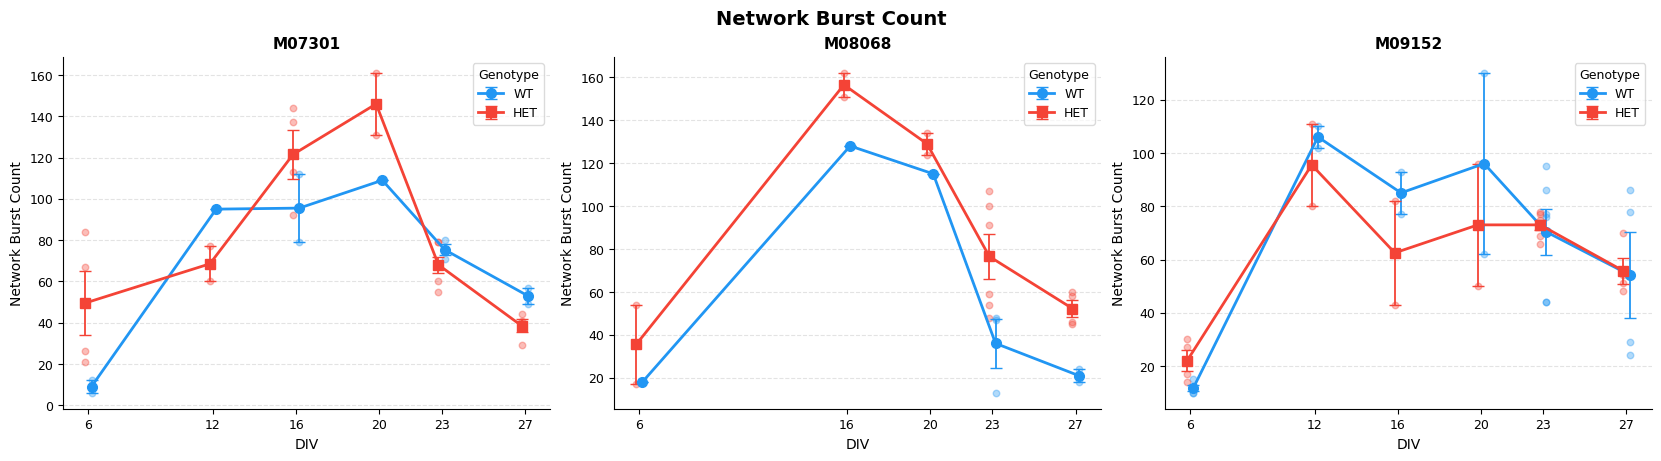

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_rate_hz.png


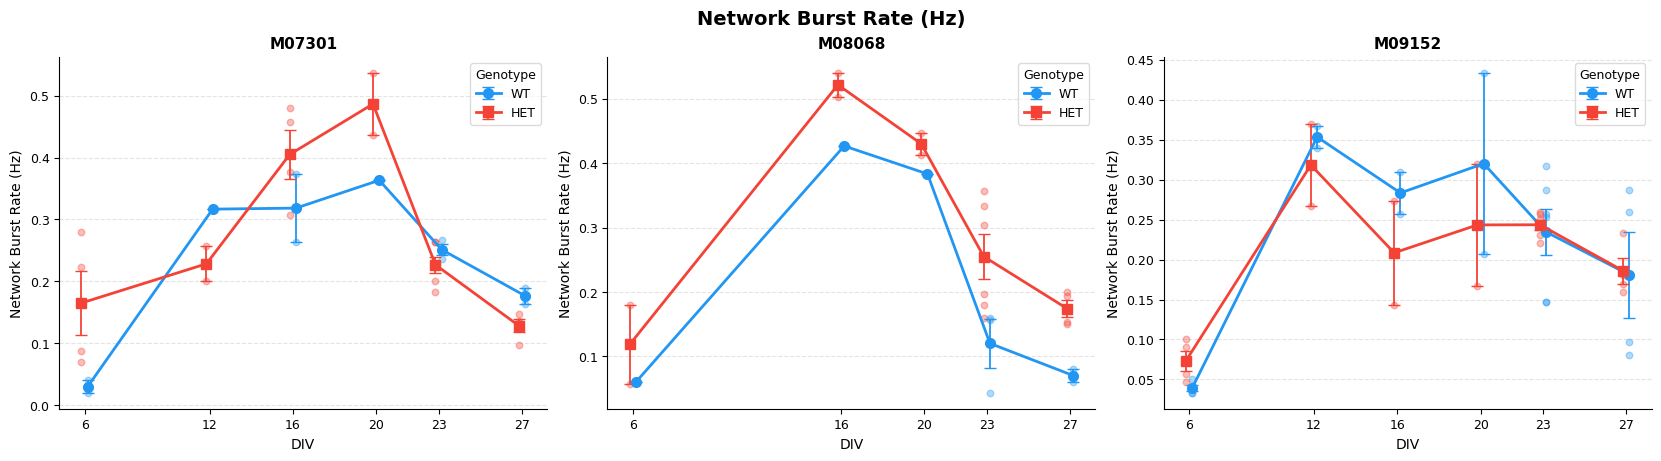

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_duration_mean_s.png


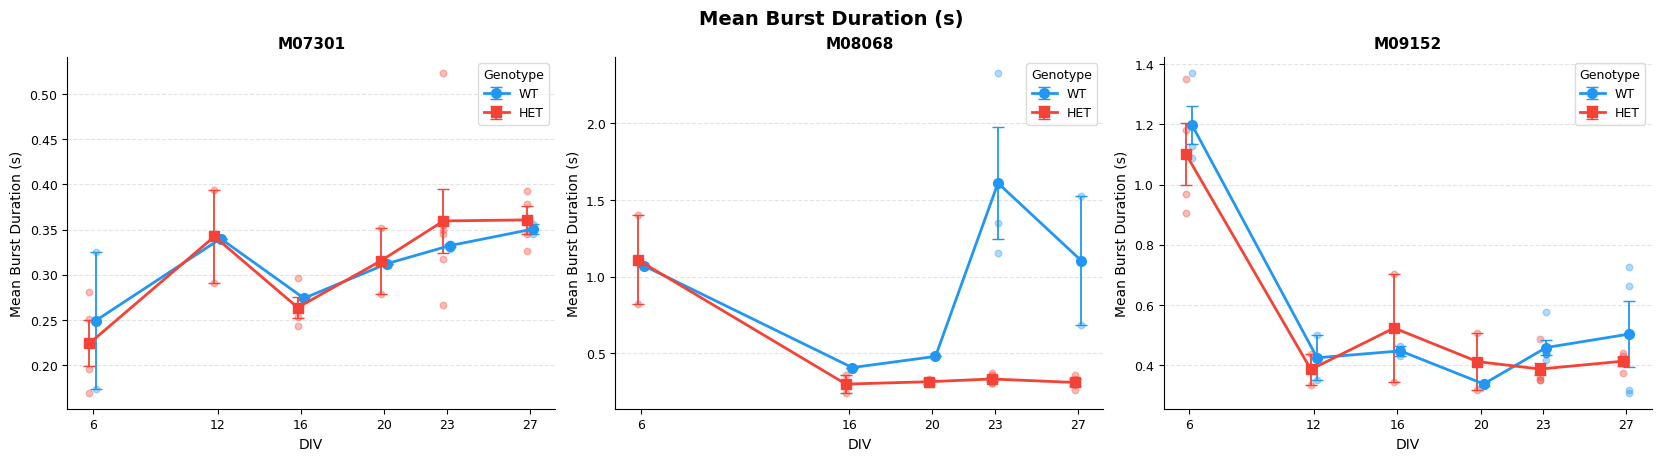

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_ibi_mean_s.png


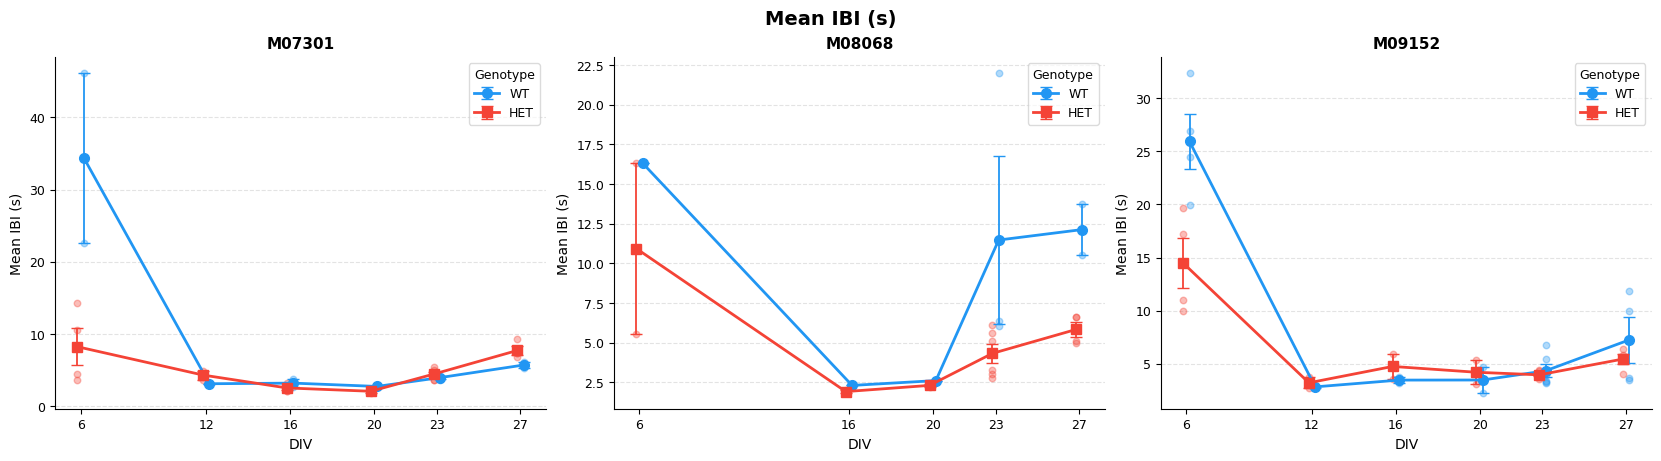

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_spikes_per_burst_mean.png


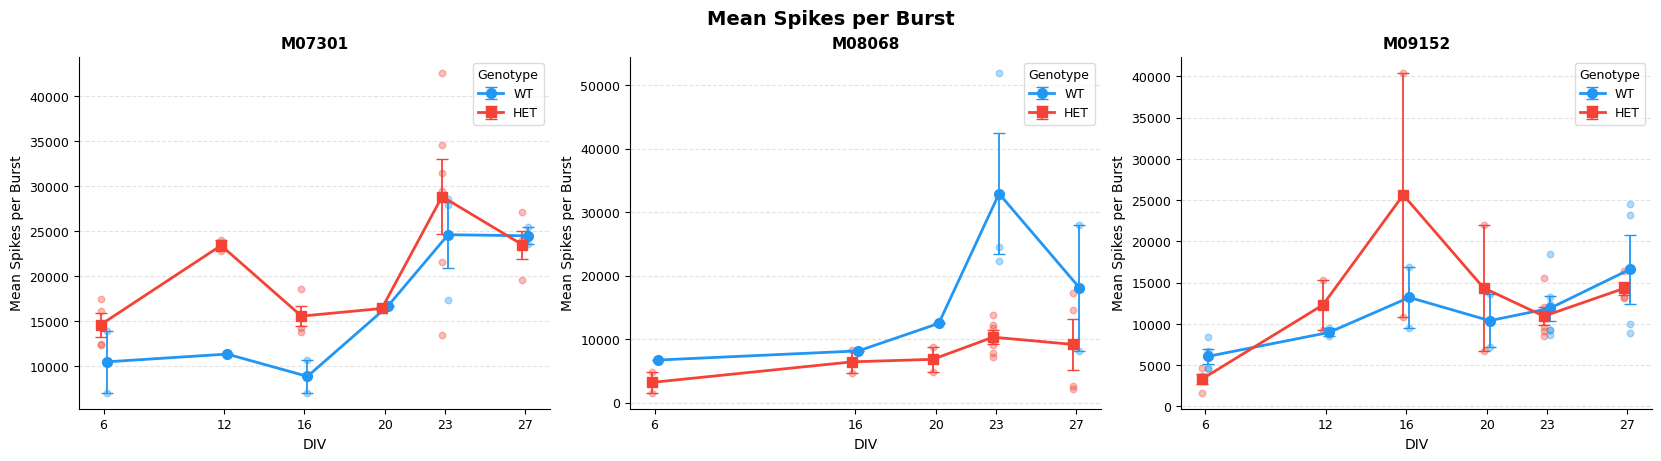

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_energy_mean.png


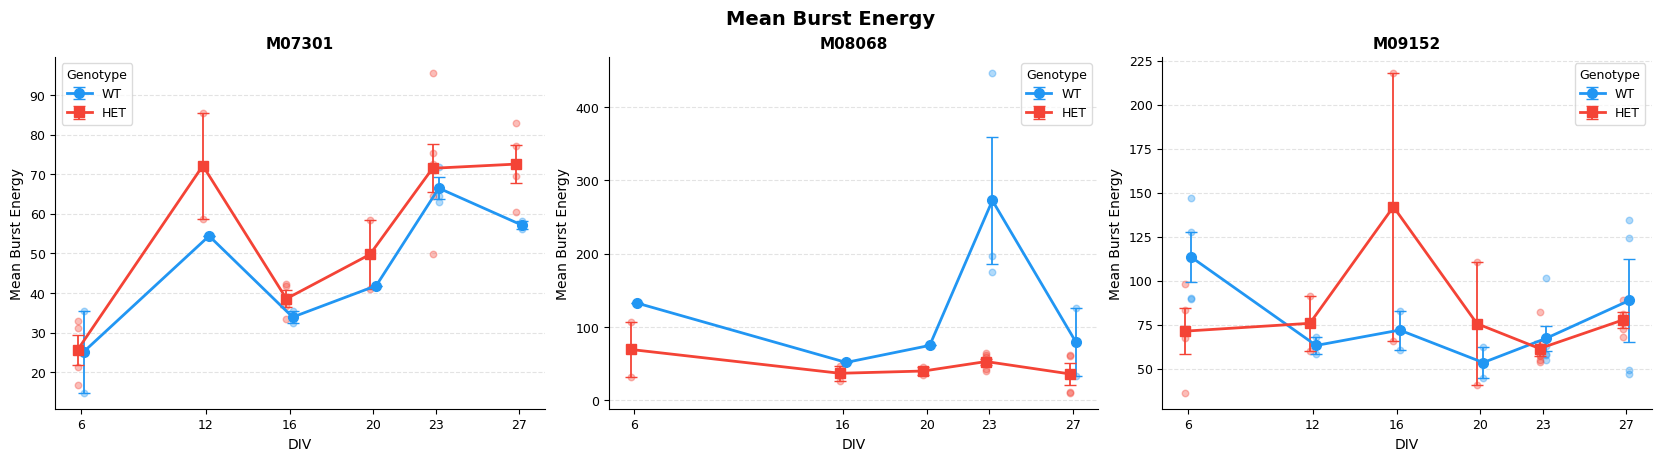

✓ Tidy CSV saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/network_burst_metrics_tidy.csv


In [7]:
# =============================================================================
# MEA Network Burst Analysis — KCNT1_M1Plus_T1_01142026_PVS  (v2 - fixed)
# =============================================================================

# ── Cell 1: Imports ──────────────────────────────────────────────────────────
import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path


# ── Cell 2: Configuration ────────────────────────────────────────────────────

BASE_DIR = Path(
    "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/"
    "AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS"
)

CSV_PATH = Path(
    "/home/shruti/Downloads/MaxTwo MEA Primary Neurons Assays(KCNT1_M1Plus_T1_01142026_PV(1).csv"
)
# ↑ Update this to the actual path of your CSV

METRICS = {
    "nb_count":                 "Network Burst Count",
    "nb_rate_hz":               "Network Burst Rate (Hz)",
    "nb_duration_mean_s":       "Mean Burst Duration (s)",
    "nb_ibi_mean_s":            "Mean IBI (s)",
    "nb_spikes_per_burst_mean": "Mean Spikes per Burst",
    "nb_energy_mean":           "Mean Burst Energy",
}

GENO_COLORS  = {"WT": "#2196F3", "HET": "#F44336"}
GENO_MARKERS = {"WT": "o",       "HET": "s"}


# ── Cell 3: Parse CSV ─────────────────────────────────────────────────────────
# Builds a lookup table:  plate_id × run_num × well_num → (div, genotype)

def parse_csv(csv_path: Path) -> pd.DataFrame:
    raw = pd.read_csv(csv_path, header=0)
    raw = raw.iloc[:, :7]                          # columns A–G only
    raw.columns = ["date", "div", "assay", "run_num",
                   "plate_id", "wells_recorded", "neuron_source"]

    # ── FIX 1: run_num comes in as float64 (e.g. 4.0) — convert properly ──
    raw["run_num"] = pd.to_numeric(raw["run_num"], errors="coerce")
    raw = raw.dropna(subset=["run_num", "plate_id"])
    raw["run_num"] = raw["run_num"].astype(int)

    # ── FIX 2: same for DIV — also float64 with NaN rows ──────────────────
    raw["div"] = pd.to_numeric(raw["div"], errors="coerce")
    raw = raw.dropna(subset=["div"])
    raw["div"] = raw["div"].astype(int)

    raw["plate_id"] = raw["plate_id"].astype(str).str.strip()

    # Keep only "Network Today Default" assay rows
    raw = raw[raw["assay"].str.lower().str.strip() == "network today default"]

    # ── Expand wells × neuron_source into per-well rows ───────────────────
    records = []
    for _, row in raw.iterrows():
        wells   = [w.strip() for w in str(row["wells_recorded"]).split(",")]
        sources = [s.strip() for s in str(row["neuron_source"]).split(",")]

        for well_str, source_str in zip(wells, sources):
            try:
                well_num = int(well_str)
            except ValueError:
                continue

            src_upper = source_str.upper()
            if "HET" in src_upper:
                genotype = "HET"
            elif "WT" in src_upper:
                genotype = "WT"
            else:
                genotype = "UNKNOWN"

            records.append({
                "plate_id": row["plate_id"],
                "run_num":  row["run_num"],
                "div":      row["div"],
                "well_num": well_num,       # 1-based, matches CSV
                "genotype": genotype,
            })

    lookup = pd.DataFrame(records)
    print(f"✓ Lookup table: {len(lookup)} well-entries from {lookup['run_num'].nunique()} Network runs")
    print(lookup.to_string(index=False))
    return lookup


lookup_df = parse_csv(CSV_PATH)


# ── Cell 4: Scan filesystem for network_results.json files ───────────────────
# Path structure: <BASE_DIR>/<date>/<plate_id>/Network/<run_padded>/<well_folder>/network_results.json
# well000 = well 1  (0-indexed → 1-based: +1)

def scan_json_files(base_dir: Path) -> pd.DataFrame:
    pattern = re.compile(
        r"(?P<plate_id>M\d+)[/\\]"
        r"[^/\\]+[/\\]"                     # assay folder (e.g. "Network")
        r"(?P<run_padded>\d+)[/\\]"
        r"well(?P<well_idx>\d+)[/\\]"
        r"network_results\.json$",
        re.IGNORECASE,
    )

    records = []
    for root, dirs, files in os.walk(base_dir):
        for fname in files:
            if fname != "network_results.json":
                continue
            full_path = Path(root) / fname
            rel = str(full_path.relative_to(base_dir)).replace("\\", "/")
            m = pattern.search(rel)
            if not m:
                continue

            records.append({
                "full_path": str(full_path),
                "plate_id":  m.group("plate_id"),
                "run_num":   int(m.group("run_padded")),
                "well_num":  int(m.group("well_idx")) + 1,  # 0-indexed → 1-based
            })

    df = pd.DataFrame(records)
    print(f"\n✓ Found {len(df)} network_results.json files")
    if len(df) > 0:
        print(df[["plate_id", "run_num", "well_num"]].to_string(index=False))
    return df


file_df = scan_json_files(BASE_DIR)


# ── Cell 5: Extract burst metrics ────────────────────────────────────────────
# New JSON format (post Dec 10 2025) confirmed structure:
#
#   network_bursts.metrics.count              → nb_count
#   network_bursts.metrics.rate               → nb_rate_hz   (bursts/s)
#   network_bursts.metrics.duration.mean      → nb_duration_mean_s
#   network_bursts.metrics.inter_event_interval.mean → nb_ibi_mean_s
#   network_bursts.metrics.spikes_per_burst.mean     → nb_spikes_per_burst_mean
#   network_bursts.metrics.intensity.mean     → nb_energy_mean  (synchrony intensity)
#
# Everything is pre-aggregated — no need to loop over events lists.

def extract_metrics(row: pd.Series) -> pd.Series:
    path = row["full_path"]
    out  = {k: np.nan for k in METRICS}

    try:
        with open(path) as f:
            data = json.load(f)

        # ── NEW format (post Dec 10 2025) ────────────────────────────────
        if "network_bursts" in data and "metrics" in data["network_bursts"]:
            m = data["network_bursts"]["metrics"]

            out["nb_count"]                 = m.get("count")
            out["nb_rate_hz"]               = m.get("rate")
            out["nb_duration_mean_s"]       = m.get("duration",             {}).get("mean")
            out["nb_ibi_mean_s"]            = m.get("inter_event_interval", {}).get("mean")
            out["nb_spikes_per_burst_mean"] = m.get("spikes_per_burst",     {}).get("mean")
            out["nb_energy_mean"]           = m.get("intensity",            {}).get("mean")

        # ── OLD format (pre Dec 10 2025) — kept for backwards compatibility
        elif "aggregates" in data:
            rec_dur = data.get("recording_end", 0) - data.get("recording_start", 0)
            nl = data.get("aggregates", {}).get("network_level", {})

            out["nb_count"]                 = nl.get("count")
            out["nb_duration_mean_s"]       = nl.get("mean_duration")
            out["nb_spikes_per_burst_mean"] = nl.get("mean_total_spikes")

            if out["nb_count"] is not None and rec_dur > 0:
                out["nb_rate_hz"] = out["nb_count"] / rec_dur

            nb_list = data.get("network_bursts", [])
            if isinstance(nb_list, list) and nb_list:
                energies = [b["burst_energy"] for b in nb_list if b.get("burst_energy") is not None]
                if energies:
                    out["nb_energy_mean"] = np.nanmean(energies)
                starts = sorted(b["start"] for b in nb_list if b.get("start") is not None)
                if len(starts) > 1:
                    ibis = [starts[i+1] - starts[i] for i in range(len(starts)-1)]
                    out["nb_ibi_mean_s"] = np.nanmean(ibis)

        else:
            print(f"  ⚠ Unrecognized JSON format: {path}")
            print(f"    Top-level keys: {list(data.keys())}")

    except Exception as e:
        print(f"  ⚠ Error reading {path}: {e}")

    return pd.Series(out)


print("\nExtracting burst metrics...")
metric_series = file_df.apply(extract_metrics, axis=1)
burst_df = pd.concat([file_df, metric_series], axis=1)
print(f"✓ Done. {len(burst_df)} rows")
print(burst_df[["plate_id", "run_num", "well_num"] + list(METRICS.keys())].to_string(index=False))


# ── Cell 7: Merge with genotype lookup ───────────────────────────────────────

merged_df = burst_df.merge(
    lookup_df[["plate_id", "run_num", "well_num", "div", "genotype"]],
    on=["plate_id", "run_num", "well_num"],
    how="inner",
)
print(f"\n✓ Merged: {len(merged_df)} rows matched to genotype+DIV info")

# Report anything that didn't match (useful for debugging re-runs / path mismatches)
unmatched = burst_df[
    ~burst_df[["plate_id","run_num","well_num"]].apply(tuple, axis=1).isin(
         merged_df[["plate_id","run_num","well_num"]].apply(tuple, axis=1)
    )
]
if len(unmatched) > 0:
    print(f"  ⚠ {len(unmatched)} JSON files had no CSV match:")
    print(unmatched[["plate_id","run_num","well_num","full_path"]].to_string(index=False))

# Filter to DIV 6–27
plot_df = merged_df[merged_df["div"].between(6, 27)].copy()
print(f"\nPlates:    {sorted(plot_df['plate_id'].unique())}")
print(f"DIVs:      {sorted(plot_df['div'].unique())}")
print(f"Genotypes: {sorted(plot_df['genotype'].unique())}")
print(f"\nPer-plate, per-DIV, per-genotype well counts:")
print(
    plot_df.groupby(["plate_id","div","genotype"])["well_num"]
    .count().rename("n_wells").reset_index().to_string(index=False)
)


# ── Cell 8: Plot ─────────────────────────────────────────────────────────────

def plot_metric(df, metric_key, metric_label, plates, save_dir=None):
    """
    One figure per metric. One subplot per plate.
    Faint dots = individual wells. Solid line+markers = mean ± SEM across wells.
    """
    n = len(plates)
    fig, axes = plt.subplots(1, n, figsize=(5.5 * n, 4.5),
                             sharey=False, constrained_layout=True)
    if n == 1:
        axes = [axes]

    fig.suptitle(metric_label, fontsize=14, fontweight="bold")

    for ax, plate_id in zip(axes, plates):
        pdata = df[df["plate_id"] == plate_id]
        all_divs = sorted(pdata["div"].unique())

        for geno in ["WT", "HET"]:
            color  = GENO_COLORS[geno]
            marker = GENO_MARKERS[geno]
            gdata  = pdata[pdata["genotype"] == geno]
            if gdata.empty:
                continue

            # Individual wells — faint dots with jitter so overlapping points show
            jitter = 0.15 * (1 if geno == "WT" else -1)
            ax.scatter(gdata["div"] + jitter, gdata[metric_key],
                       color=color, alpha=0.35, s=22, zorder=2)

            # Mean ± SEM per DIV
            summary = (
                gdata.groupby("div")[metric_key]
                .agg(mean="mean", sem=lambda x: x.sem(ddof=1) if len(x) > 1 else 0)
                .reset_index()
            )
            ax.errorbar(summary["div"] + jitter, summary["mean"],
                        yerr=summary["sem"],
                        color=color, marker=marker, markersize=7,
                        linewidth=2, capsize=4, elinewidth=1.3,
                        label=geno, zorder=3)

        ax.set_title(f"{plate_id}", fontsize=11, fontweight="bold")
        ax.set_xlabel("DIV", fontsize=10)
        ax.set_ylabel(metric_label, fontsize=10)
        ax.set_xticks(all_divs)
        ax.grid(axis="y", linestyle="--", alpha=0.35)
        ax.legend(title="Genotype", fontsize=9, title_fontsize=9, framealpha=0.7)
        ax.spines[["top","right"]].set_visible(False)
        ax.tick_params(axis="both", labelsize=9)

    if save_dir is not None:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        out = Path(save_dir) / f"{metric_key}.png"
        fig.savefig(out, dpi=150, bbox_inches="tight")
        print(f"  Saved → {out}")

    plt.show()


SAVE_DIR = BASE_DIR / "figures"   # set to None to skip saving

plates = sorted(plot_df["plate_id"].unique())

for metric_key, metric_label in METRICS.items():
    plot_metric(plot_df, metric_key, metric_label, plates, save_dir=SAVE_DIR)


# ── Cell 9: Export tidy CSV ───────────────────────────────────────────────────

out_csv = BASE_DIR / "figures" / "network_burst_metrics_tidy.csv"
out_csv.parent.mkdir(parents=True, exist_ok=True)
(
    plot_df[["plate_id", "run_num", "well_num", "div", "genotype"] + list(METRICS.keys())]
    .sort_values(["plate_id", "div", "genotype", "well_num"])
    .to_csv(out_csv, index=False)
)
print(f"✓ Tidy CSV saved → {out_csv}")

✓ Lookup table: 97 well-entries from 29 Network runs
plate_id  run_num  div  well_num genotype
  M09152        5    6         2      HET
  M09152        5    6         3      HET
  M09152        5    6         5       WT
  M09152        5    6         6       WT
  M09152        9    6         2      HET
  M09152        9    6         3      HET
  M09152        9    6         5       WT
  M09152        9    6         6       WT
  M07301       12    6         2      HET
  M07301       12    6         3      HET
  M07301       12    6         6       WT
  M07301       15    6         2      HET
  M07301       15    6         3      HET
  M07301       15    6         6       WT
  M08068       18    6         2      HET
  M08068       18    6         3      HET
  M08068       18    6         6       WT
  M09152       21   12         2      HET
  M09152       21   12         3      HET
  M09152       21   12         5       WT
  M09152       21   12         6       WT
  M07301       24   12 

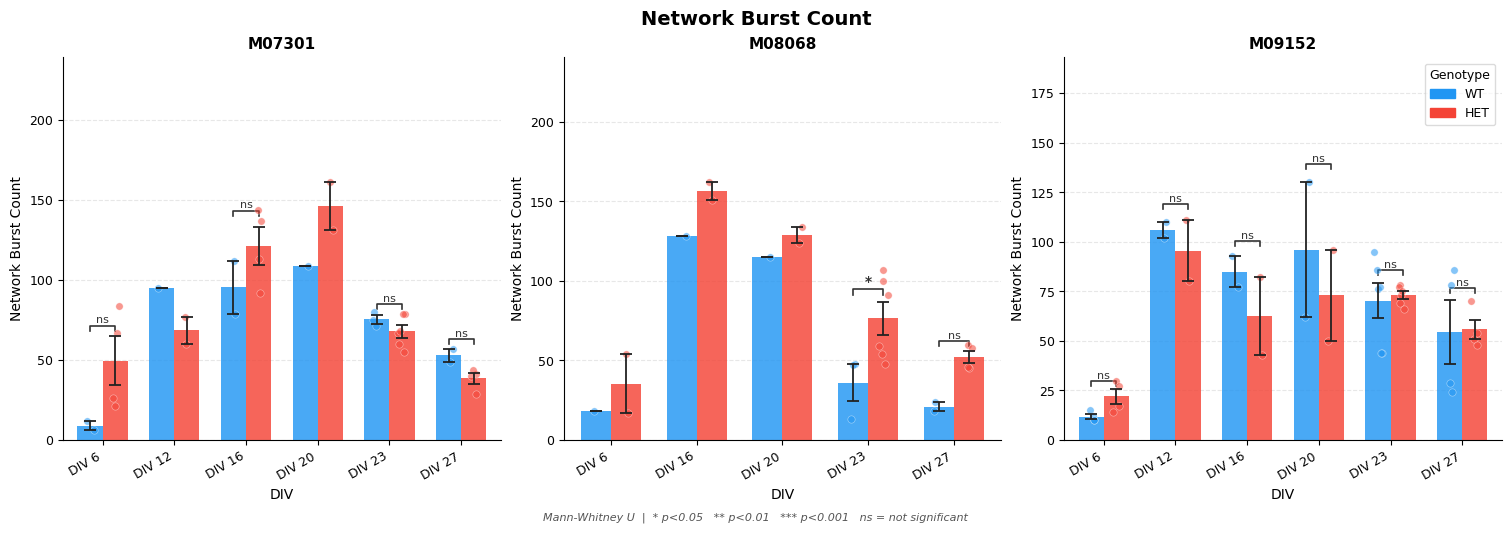

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_rate_hz_bars.png


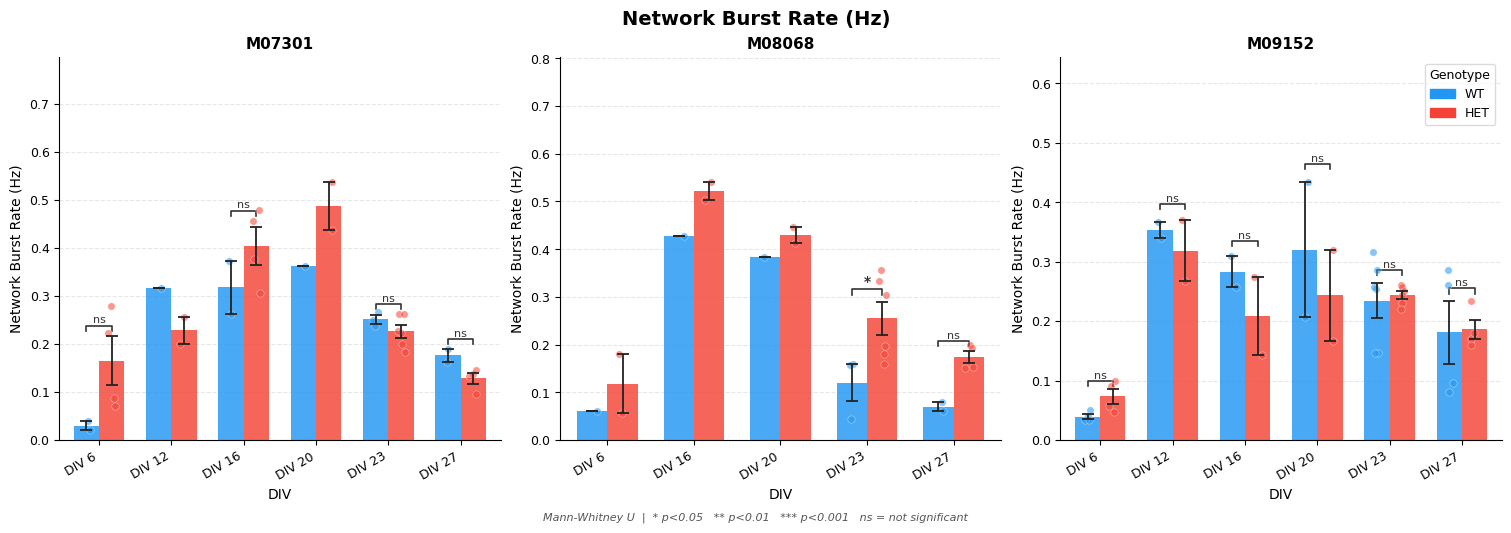

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_duration_mean_s_bars.png


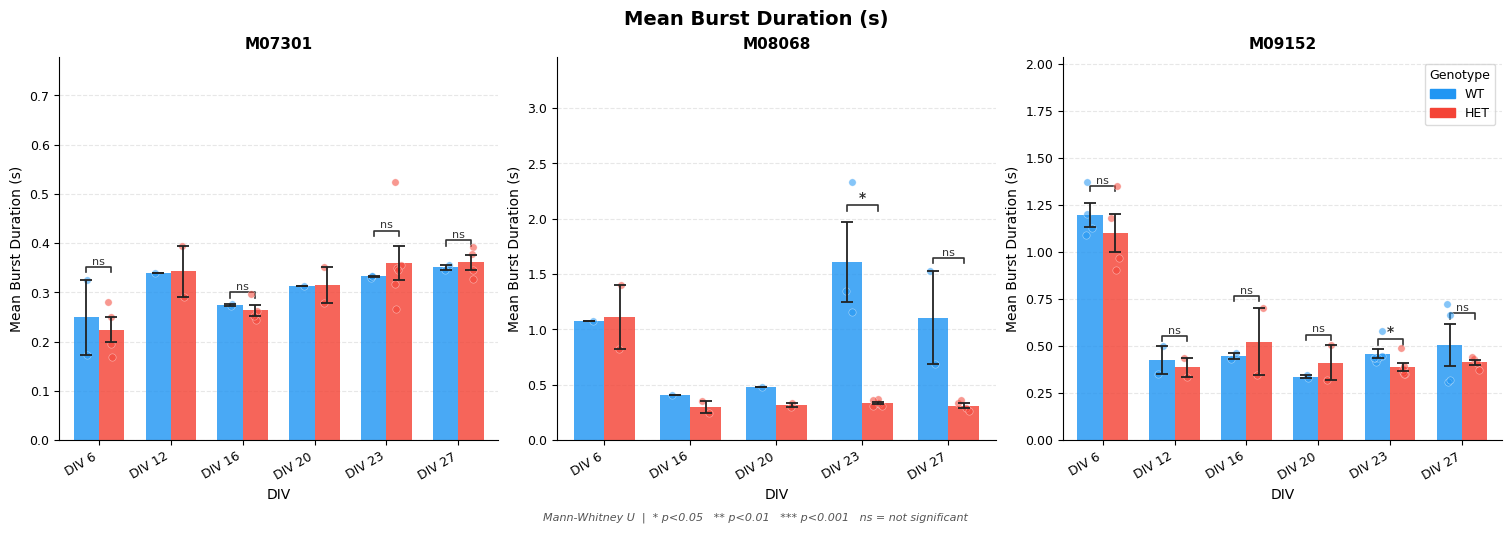

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_ibi_mean_s_bars.png


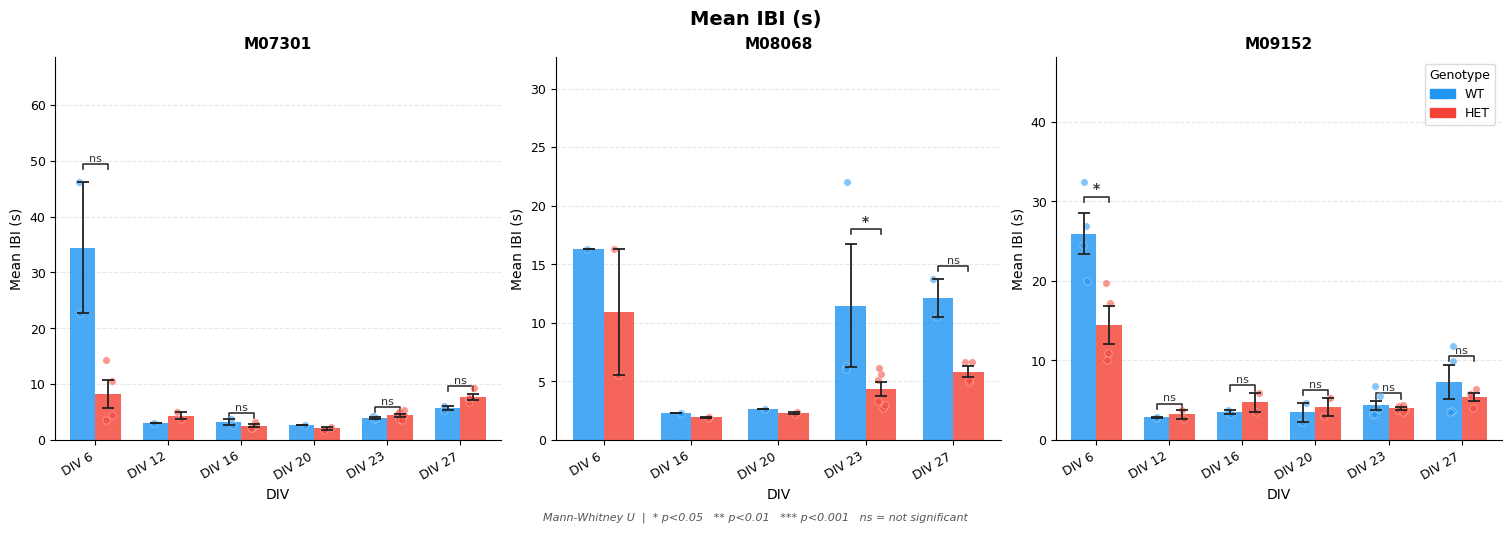

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_spikes_per_burst_mean_bars.png


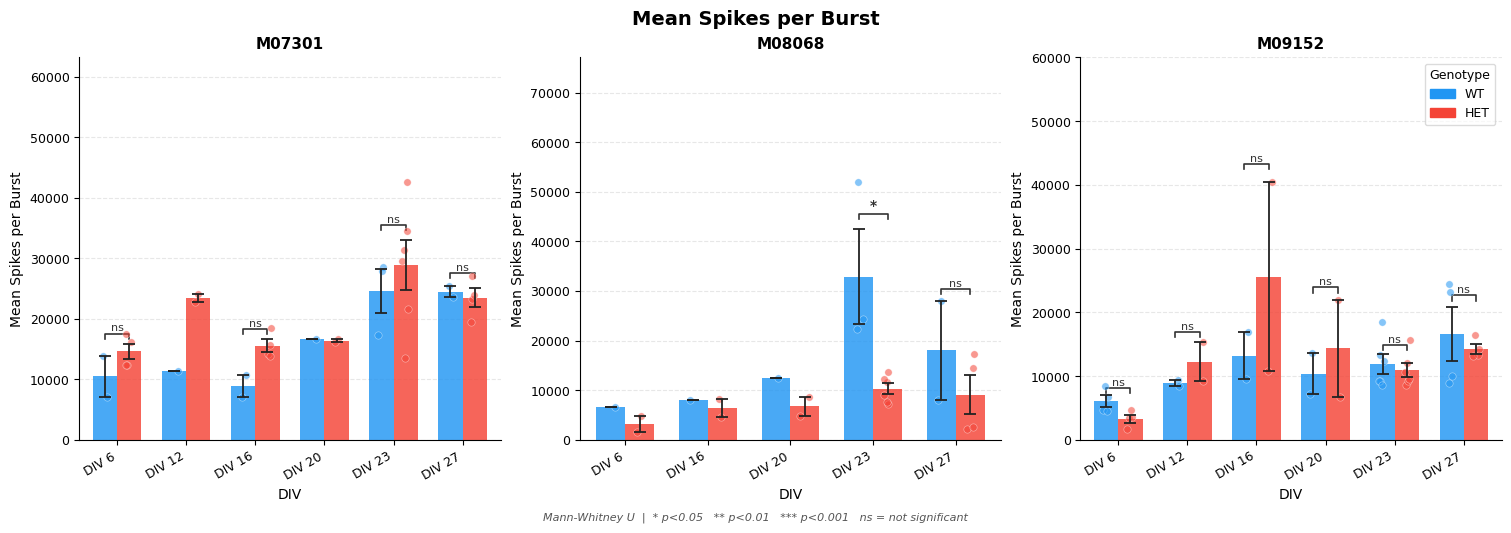

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_energy_mean_bars.png


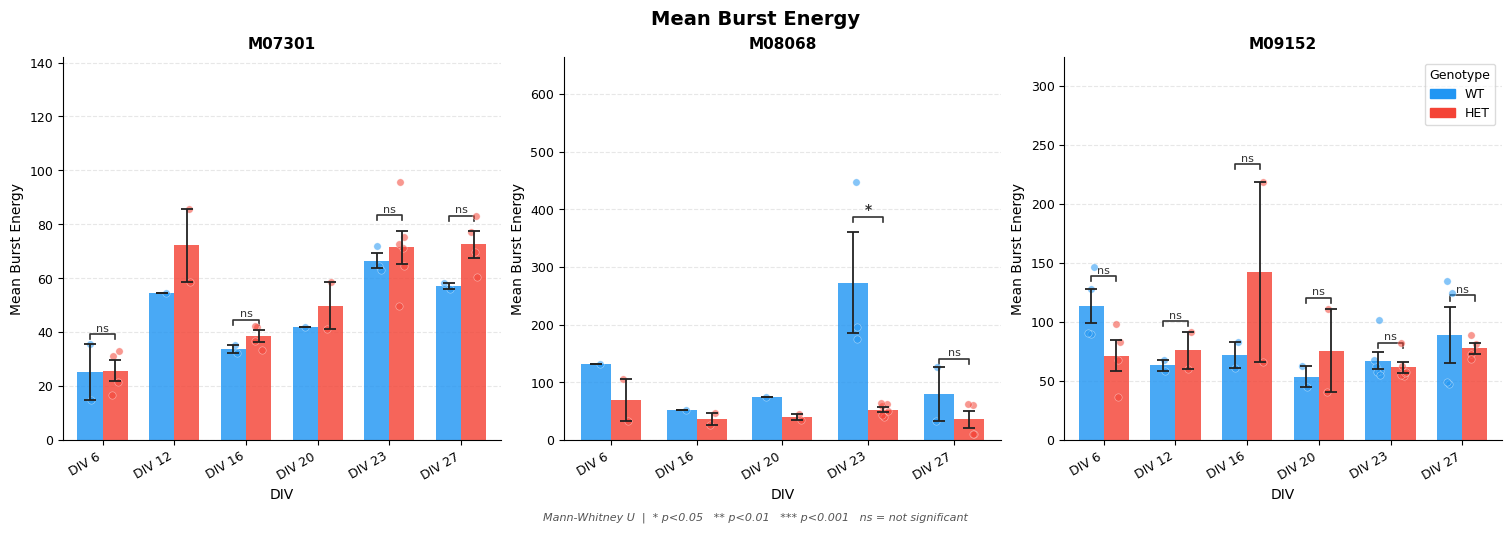

✓ Tidy CSV saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/network_burst_metrics_tidy.csv


In [8]:
# =============================================================================
# MEA Network Burst Analysis — KCNT1_M1Plus_T1_01142026_PVS  (v2 - fixed)
# =============================================================================

# ── Cell 1: Imports ──────────────────────────────────────────────────────────
import os, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
from pathlib import Path
from scipy.stats import mannwhitneyu


# ── Cell 2: Configuration ────────────────────────────────────────────────────

BASE_DIR = Path(
    "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/"
    "AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS"
)

CSV_PATH = Path(
    "/home/shruti/Downloads/MaxTwo MEA Primary Neurons Assays(KCNT1_M1Plus_T1_01142026_PV(1).csv"
)
# ↑ Update this to the actual path of your CSV

METRICS = {
    "nb_count":                 "Network Burst Count",
    "nb_rate_hz":               "Network Burst Rate (Hz)",
    "nb_duration_mean_s":       "Mean Burst Duration (s)",
    "nb_ibi_mean_s":            "Mean IBI (s)",
    "nb_spikes_per_burst_mean": "Mean Spikes per Burst",
    "nb_energy_mean":           "Mean Burst Energy",
}

GENO_COLORS  = {"WT": "#2196F3", "HET": "#F44336"}
GENO_MARKERS = {"WT": "o",       "HET": "s"}


# ── Cell 3: Parse CSV ─────────────────────────────────────────────────────────
# Builds a lookup table:  plate_id × run_num × well_num → (div, genotype)

def parse_csv(csv_path: Path) -> pd.DataFrame:
    raw = pd.read_csv(csv_path, header=0)
    raw = raw.iloc[:, :7]                          # columns A–G only
    raw.columns = ["date", "div", "assay", "run_num",
                   "plate_id", "wells_recorded", "neuron_source"]

    # ── FIX 1: run_num comes in as float64 (e.g. 4.0) — convert properly ──
    raw["run_num"] = pd.to_numeric(raw["run_num"], errors="coerce")
    raw = raw.dropna(subset=["run_num", "plate_id"])
    raw["run_num"] = raw["run_num"].astype(int)

    # ── FIX 2: same for DIV — also float64 with NaN rows ──────────────────
    raw["div"] = pd.to_numeric(raw["div"], errors="coerce")
    raw = raw.dropna(subset=["div"])
    raw["div"] = raw["div"].astype(int)

    raw["plate_id"] = raw["plate_id"].astype(str).str.strip()

    # Keep only "Network Today Default" assay rows
    raw = raw[raw["assay"].str.lower().str.strip() == "network today default"]

    # ── Expand wells × neuron_source into per-well rows ───────────────────
    records = []
    for _, row in raw.iterrows():
        wells   = [w.strip() for w in str(row["wells_recorded"]).split(",")]
        sources = [s.strip() for s in str(row["neuron_source"]).split(",")]

        for well_str, source_str in zip(wells, sources):
            try:
                well_num = int(well_str)
            except ValueError:
                continue

            src_upper = source_str.upper()
            if "HET" in src_upper:
                genotype = "HET"
            elif "WT" in src_upper:
                genotype = "WT"
            else:
                genotype = "UNKNOWN"

            records.append({
                "plate_id": row["plate_id"],
                "run_num":  row["run_num"],
                "div":      row["div"],
                "well_num": well_num,       # 1-based, matches CSV
                "genotype": genotype,
            })

    lookup = pd.DataFrame(records)
    print(f"✓ Lookup table: {len(lookup)} well-entries from {lookup['run_num'].nunique()} Network runs")
    print(lookup.to_string(index=False))
    return lookup


lookup_df = parse_csv(CSV_PATH)


# ── Cell 4: Scan filesystem for network_results.json files ───────────────────
# Path structure: <BASE_DIR>/<date>/<plate_id>/Network/<run_padded>/<well_folder>/network_results.json
# well000 = well 1  (0-indexed → 1-based: +1)

def scan_json_files(base_dir: Path) -> pd.DataFrame:
    pattern = re.compile(
        r"(?P<plate_id>M\d+)[/\\]"
        r"[^/\\]+[/\\]"                     # assay folder (e.g. "Network")
        r"(?P<run_padded>\d+)[/\\]"
        r"well(?P<well_idx>\d+)[/\\]"
        r"network_results\.json$",
        re.IGNORECASE,
    )

    records = []
    for root, dirs, files in os.walk(base_dir):
        for fname in files:
            if fname != "network_results.json":
                continue
            full_path = Path(root) / fname
            rel = str(full_path.relative_to(base_dir)).replace("\\", "/")
            m = pattern.search(rel)
            if not m:
                continue

            records.append({
                "full_path": str(full_path),
                "plate_id":  m.group("plate_id"),
                "run_num":   int(m.group("run_padded")),
                "well_num":  int(m.group("well_idx")) + 1,  # 0-indexed → 1-based
            })

    df = pd.DataFrame(records)
    print(f"\n✓ Found {len(df)} network_results.json files")
    if len(df) > 0:
        print(df[["plate_id", "run_num", "well_num"]].to_string(index=False))
    return df


file_df = scan_json_files(BASE_DIR)


# ── Cell 5: Extract burst metrics ────────────────────────────────────────────
# New JSON format (post Dec 10 2025) confirmed structure:
#
#   network_bursts.metrics.count              → nb_count
#   network_bursts.metrics.rate               → nb_rate_hz   (bursts/s)
#   network_bursts.metrics.duration.mean      → nb_duration_mean_s
#   network_bursts.metrics.inter_event_interval.mean → nb_ibi_mean_s
#   network_bursts.metrics.spikes_per_burst.mean     → nb_spikes_per_burst_mean
#   network_bursts.metrics.intensity.mean     → nb_energy_mean  (synchrony intensity)
#
# Everything is pre-aggregated — no need to loop over events lists.

def extract_metrics(row: pd.Series) -> pd.Series:
    path = row["full_path"]
    out  = {k: np.nan for k in METRICS}

    try:
        with open(path) as f:
            data = json.load(f)

        # ── NEW format (post Dec 10 2025) ────────────────────────────────
        if "network_bursts" in data and "metrics" in data["network_bursts"]:
            m = data["network_bursts"]["metrics"]

            out["nb_count"]                 = m.get("count")
            out["nb_rate_hz"]               = m.get("rate")
            out["nb_duration_mean_s"]       = m.get("duration",             {}).get("mean")
            out["nb_ibi_mean_s"]            = m.get("inter_event_interval", {}).get("mean")
            out["nb_spikes_per_burst_mean"] = m.get("spikes_per_burst",     {}).get("mean")
            out["nb_energy_mean"]           = m.get("intensity",            {}).get("mean")

        # ── OLD format (pre Dec 10 2025) — kept for backwards compatibility
        elif "aggregates" in data:
            rec_dur = data.get("recording_end", 0) - data.get("recording_start", 0)
            nl = data.get("aggregates", {}).get("network_level", {})

            out["nb_count"]                 = nl.get("count")
            out["nb_duration_mean_s"]       = nl.get("mean_duration")
            out["nb_spikes_per_burst_mean"] = nl.get("mean_total_spikes")

            if out["nb_count"] is not None and rec_dur > 0:
                out["nb_rate_hz"] = out["nb_count"] / rec_dur

            nb_list = data.get("network_bursts", [])
            if isinstance(nb_list, list) and nb_list:
                energies = [b["burst_energy"] for b in nb_list if b.get("burst_energy") is not None]
                if energies:
                    out["nb_energy_mean"] = np.nanmean(energies)
                starts = sorted(b["start"] for b in nb_list if b.get("start") is not None)
                if len(starts) > 1:
                    ibis = [starts[i+1] - starts[i] for i in range(len(starts)-1)]
                    out["nb_ibi_mean_s"] = np.nanmean(ibis)

        else:
            print(f"  ⚠ Unrecognized JSON format: {path}")
            print(f"    Top-level keys: {list(data.keys())}")

    except Exception as e:
        print(f"  ⚠ Error reading {path}: {e}")

    return pd.Series(out)


# ── Cell 6: Extract burst metrics — apply to all files ───────────────────────
metric_series = file_df.apply(extract_metrics, axis=1)
burst_df = pd.concat([file_df, metric_series], axis=1)
print(f"✓ Done. {len(burst_df)} rows")
print(burst_df[["plate_id", "run_num", "well_num"] + list(METRICS.keys())].to_string(index=False))


# ── Cell 7: Merge with genotype lookup ───────────────────────────────────────

merged_df = burst_df.merge(
    lookup_df[["plate_id", "run_num", "well_num", "div", "genotype"]],
    on=["plate_id", "run_num", "well_num"],
    how="inner",
)
print(f"\n✓ Merged: {len(merged_df)} rows matched to genotype+DIV info")

# Report anything that didn't match (useful for debugging re-runs / path mismatches)
unmatched = burst_df[
    ~burst_df[["plate_id","run_num","well_num"]].apply(tuple, axis=1).isin(
         merged_df[["plate_id","run_num","well_num"]].apply(tuple, axis=1)
    )
]
if len(unmatched) > 0:
    print(f"  ⚠ {len(unmatched)} JSON files had no CSV match:")
    print(unmatched[["plate_id","run_num","well_num","full_path"]].to_string(index=False))

# Filter to DIV 6–27
plot_df = merged_df[merged_df["div"].between(6, 27)].copy()
print(f"\nPlates:    {sorted(plot_df['plate_id'].unique())}")
print(f"DIVs:      {sorted(plot_df['div'].unique())}")
print(f"Genotypes: {sorted(plot_df['genotype'].unique())}")
print(f"\nPer-plate, per-DIV, per-genotype well counts:")
print(
    plot_df.groupby(["plate_id","div","genotype"])["well_num"]
    .count().rename("n_wells").reset_index().to_string(index=False)
)


# ── Cell 8: Significance helper ──────────────────────────────────────────────

def stars(p: float) -> str:
    """Convert p-value to significance stars."""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return "ns"


def draw_sig_bar(ax, x1, x2, y_top, p_val, bar_height_frac=0.015):
    """
    Draw a significance bracket between bar centres x1 and x2.
    y_top   : top of the taller bar + its error bar (data units)
    Returns the y position used (so caller can stack multiple bars).
    """
    label   = stars(p_val)
    color   = "#333333"
    y_bar   = y_top
    tick_h  = (ax.get_ylim()[1] - ax.get_ylim()[0]) * bar_height_frac

    ax.plot([x1, x1, x2, x2],
            [y_bar, y_bar + tick_h, y_bar + tick_h, y_bar],
            lw=1.2, color=color, clip_on=False)

    fontsize = 10 if label != "ns" else 8
    weight   = "bold" if label != "ns" else "normal"
    ax.text((x1 + x2) / 2, y_bar + tick_h * 1.1,
            label, ha="center", va="bottom",
            fontsize=fontsize, fontweight=weight, color=color)

    return y_bar + tick_h * 2.5   # return clearance height for stacking


# ── Cell 9: Bar plot function ─────────────────────────────────────────────────
# Layout:  one figure per metric  ×  one subplot per plate
# Bars:    WT and HET side-by-side at each DIV (mean ± SEM)
# Dots:    individual wells overlaid (jittered)
# Stats:   Mann-Whitney U (two-sided) between WT and HET at each DIV

BAR_WIDTH = 0.35

def plot_metric_bars(df, metric_key, metric_label, plates, save_dir=None):
    n   = len(plates)
    fig, axes = plt.subplots(1, n, figsize=(max(6, 2.2 * n * 7 // n), 5),
                             sharey=False, constrained_layout=True)
    if n == 1:
        axes = [axes]

    fig.suptitle(metric_label, fontsize=14, fontweight="bold")

    for ax, plate_id in zip(axes, plates):
        pdata    = df[df["plate_id"] == plate_id].dropna(subset=[metric_key])
        all_divs = sorted(pdata["div"].unique())
        x_pos    = np.arange(len(all_divs))          # integer x positions for DIVs

        # ── Draw bars ────────────────────────────────────────────────────
        bar_tops = {}   # (div_idx, geno) → top of bar + error for sig bracket placement

        for gi, geno in enumerate(["WT", "HET"]):
            color  = GENO_COLORS[geno]
            offset = (gi - 0.5) * BAR_WIDTH          # -0.175 for WT, +0.175 for HET
            gdata  = pdata[pdata["genotype"] == geno]

            means, sems, xs, raw_xs = [], [], [], []
            for di, div in enumerate(all_divs):
                vals = gdata.loc[gdata["div"] == div, metric_key].dropna().values
                if len(vals) == 0:
                    means.append(0); sems.append(0)
                    bar_tops[(di, geno)] = 0
                else:
                    m = np.mean(vals)
                    s = np.std(vals, ddof=1) / np.sqrt(len(vals)) if len(vals) > 1 else 0
                    means.append(m); sems.append(s)
                    bar_tops[(di, geno)] = m + s

                xs.append(x_pos[di] + offset)

                # Individual well dots with jitter
                jitter = np.random.uniform(-0.06, 0.06, size=len(vals))
                ax.scatter(np.full(len(vals), x_pos[di] + offset) + jitter,
                           vals, color=color, s=28, alpha=0.55,
                           zorder=4, linewidths=0.4, edgecolors="white")

            ax.bar(xs, means, width=BAR_WIDTH, color=color, alpha=0.82,
                   label=geno, zorder=2)
            ax.errorbar(xs, means, yerr=sems, fmt="none",
                        ecolor="#222222", elinewidth=1.3, capsize=4, capthick=1.3,
                        zorder=5)

        # ── Significance brackets ─────────────────────────────────────────
        # Temporarily set ylim so draw_sig_bar can read it for tick scaling;
        # we'll tighten it again after.
        y_max_data = max(
            (pdata.loc[pdata["div"] == div, metric_key].max(skipna=True) or 0)
            for div in all_divs
        )
        ax.set_ylim(0, y_max_data * 1.35)   # initial headroom estimate

        for di, div in enumerate(all_divs):
            wt_vals  = pdata.loc[(pdata["div"] == div) & (pdata["genotype"] == "WT"),
                                 metric_key].dropna().values
            het_vals = pdata.loc[(pdata["div"] == div) & (pdata["genotype"] == "HET"),
                                 metric_key].dropna().values

            if len(wt_vals) < 2 or len(het_vals) < 2:
                # Can't test with fewer than 2 observations per group — skip bracket
                continue

            _, p = mannwhitneyu(wt_vals, het_vals, alternative="two-sided")

            # Place bracket just above the taller bar + error bar
            y_top = max(bar_tops.get((di, "WT"), 0),
                        bar_tops.get((di, "HET"), 0)) * 1.05

            x_wt  = x_pos[di] - 0.5 * BAR_WIDTH
            x_het = x_pos[di] + 0.5 * BAR_WIDTH
            draw_sig_bar(ax, x_wt, x_het, y_top, p)

        # ── Axes cosmetics ────────────────────────────────────────────────
        ax.set_xticks(x_pos)
        ax.set_xticklabels([f"DIV {d}" for d in all_divs], fontsize=9, rotation=30, ha="right")
        ax.set_xlabel("DIV", fontsize=10)
        ax.set_ylabel(metric_label, fontsize=10)
        ax.set_title(plate_id, fontsize=11, fontweight="bold")
        ax.set_xlim(-0.55, len(all_divs) - 0.45)
        ax.grid(axis="y", linestyle="--", alpha=0.3, zorder=0)
        ax.spines[["top", "right"]].set_visible(False)
        ax.tick_params(axis="both", labelsize=9)

        # Re-fit ylim to include sig brackets
        ax.autoscale_view(scalex=False, scaley=True)
        lo, hi = ax.get_ylim()
        ax.set_ylim(0, hi * 1.1)

    # Legend (shared, outside top-right of last subplot)
    legend_patches = [
        mpatches.Patch(color=GENO_COLORS["WT"],  label="WT"),
        mpatches.Patch(color=GENO_COLORS["HET"], label="HET"),
    ]
    axes[-1].legend(handles=legend_patches, title="Genotype",
                    fontsize=9, title_fontsize=9, framealpha=0.7,
                    loc="upper right")

    # Significance key (bottom of figure)
    fig.text(0.5, -0.03,
             "Mann-Whitney U  |  * p<0.05   ** p<0.01   *** p<0.001   ns = not significant",
             ha="center", fontsize=8, color="#555555", style="italic")

    if save_dir is not None:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        out = Path(save_dir) / f"{metric_key}_bars.png"
        fig.savefig(out, dpi=150, bbox_inches="tight")
        print(f"  Saved → {out}")

    plt.show()


SAVE_DIR = BASE_DIR / "figures"   # set to None to skip saving

plates = sorted(plot_df["plate_id"].unique())

for metric_key, metric_label in METRICS.items():
    plot_metric_bars(plot_df, metric_key, metric_label, plates, save_dir=SAVE_DIR)


# ── Cell 10: Export tidy CSV ─────────────────────────────────────────────────

out_csv = BASE_DIR / "figures" / "network_burst_metrics_tidy.csv"
out_csv.parent.mkdir(parents=True, exist_ok=True)
(
    plot_df[["plate_id", "run_num", "well_num", "div", "genotype"] + list(METRICS.keys())]
    .sort_values(["plate_id", "div", "genotype", "well_num"])
    .to_csv(out_csv, index=False)
)
print(f"✓ Tidy CSV saved → {out_csv}")

✓ Lookup table: 97 well-entries from 29 Network runs
plate_id  run_num  div  well_num genotype
  M09152        5    6         2      HET
  M09152        5    6         3      HET
  M09152        5    6         5       WT
  M09152        5    6         6       WT
  M09152        9    6         2      HET
  M09152        9    6         3      HET
  M09152        9    6         5       WT
  M09152        9    6         6       WT
  M07301       12    6         2      HET
  M07301       12    6         3      HET
  M07301       12    6         6       WT
  M07301       15    6         2      HET
  M07301       15    6         3      HET
  M07301       15    6         6       WT
  M08068       18    6         2      HET
  M08068       18    6         3      HET
  M08068       18    6         6       WT
  M09152       21   12         2      HET
  M09152       21   12         3      HET
  M09152       21   12         5       WT
  M09152       21   12         6       WT
  M07301       24   12 

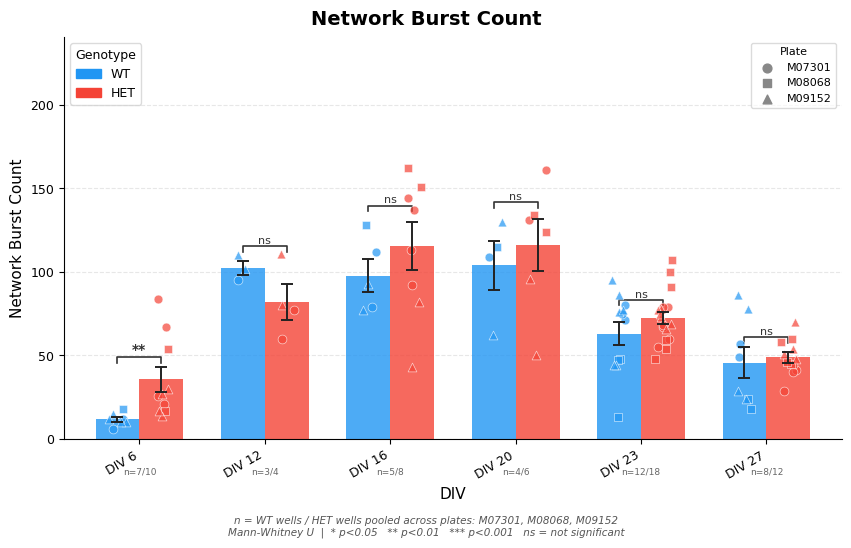

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_rate_hz_aggregated.png


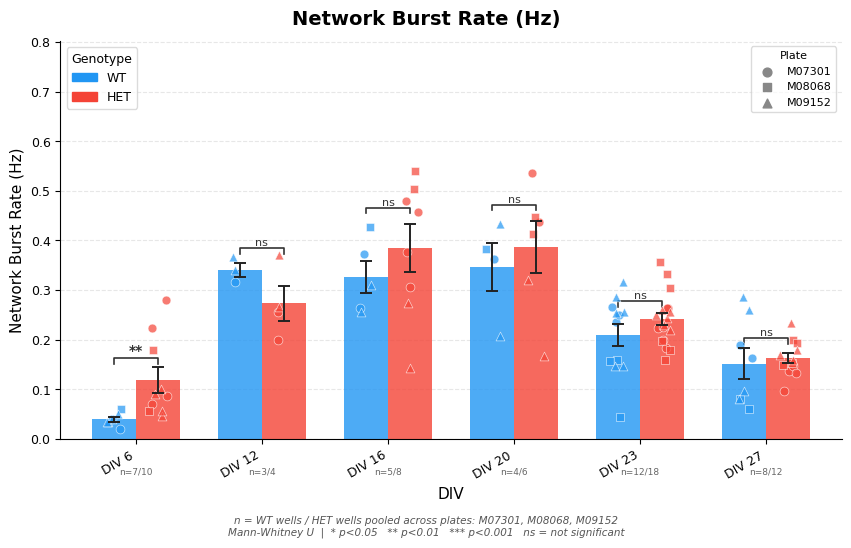

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_duration_mean_s_aggregated.png


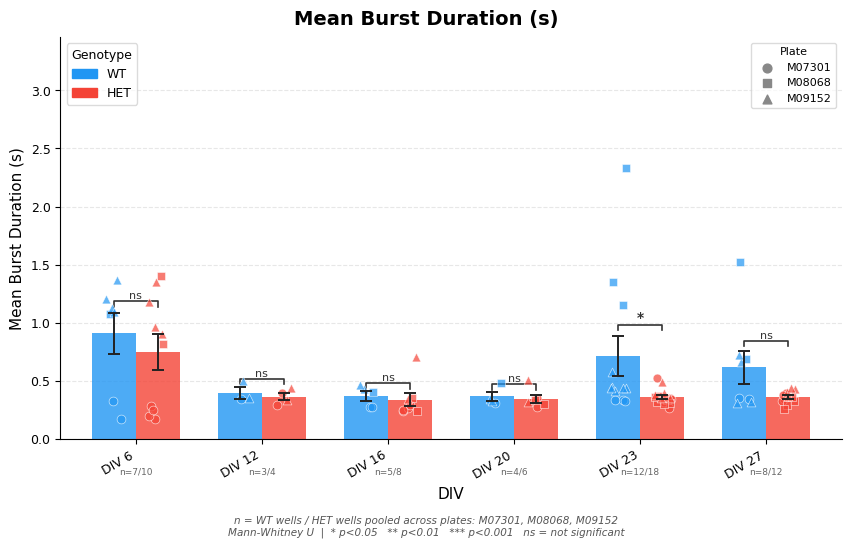

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_ibi_mean_s_aggregated.png


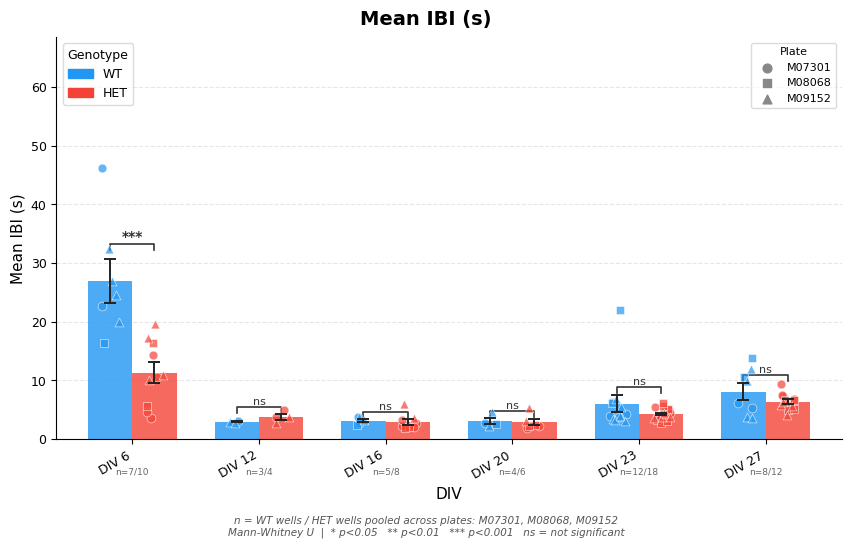

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_spikes_per_burst_mean_aggregated.png


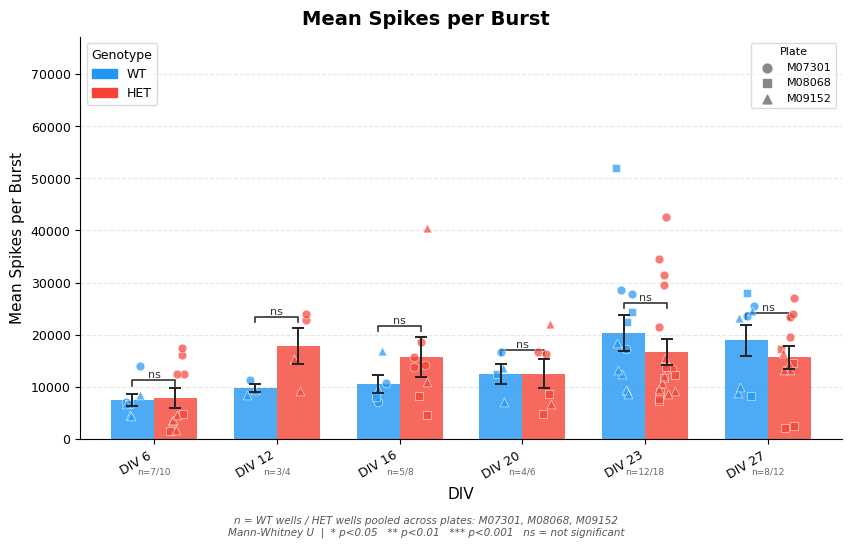

  Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/nb_energy_mean_aggregated.png


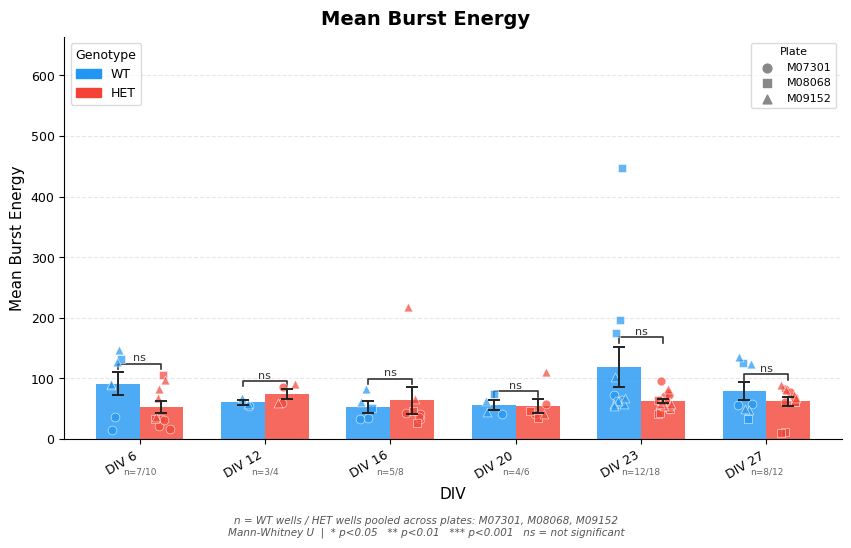

✓ Tidy CSV saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/network_burst_metrics_tidy.csv
✓ Found 337 raster SVG files across 3 plates
  → 97 raster files matched to genotype+DIV

Plate M07301: 3 wells × 6 DIVs
  Tile size detected: 1500×1200 px
  ✓ Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/raster_grids/M07301_raster_grid.png  (9188×3666 px)

Plate M08068: 3 wells × 5 DIVs
  Tile size detected: 1500×1200 px
  ✓ Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/raster_grids/M08068_raster_grid.png  (7684×3666 px)

Plate M09152: 4 wells × 6 DIVs
  Tile size detected: 1500×1200 px
  ✓ Saved → /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/raster_grids/M09152_raster_grid.png  (9188×4870 px)


In [30]:
# =============================================================================
# MEA Network Burst Analysis — KCNT1_M1Plus_T1_01142026_PVS  (v2 - fixed)
# =============================================================================

# ── Cell 1: Imports ──────────────────────────────────────────────────────────
import os, json, re, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from pathlib import Path
from scipy.stats import mannwhitneyu
from PIL import Image, ImageDraw, ImageFont


# ── Cell 2: Configuration ────────────────────────────────────────────────────

BASE_DIR = Path(
    "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/"
    "AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS"
)

CSV_PATH = Path(
    "/home/shruti/Downloads/MaxTwo MEA Primary Neurons Assays(KCNT1_M1Plus_T1_01142026_PV(1).csv"
)
# ↑ Update this to the actual path of your CSV

METRICS = {
    "nb_count":                 "Network Burst Count",
    "nb_rate_hz":               "Network Burst Rate (Hz)",
    "nb_duration_mean_s":       "Mean Burst Duration (s)",
    "nb_ibi_mean_s":            "Mean IBI (s)",
    "nb_spikes_per_burst_mean": "Mean Spikes per Burst",
    "nb_energy_mean":           "Mean Burst Energy",
}

GENO_COLORS  = {"WT": "#2196F3", "HET": "#F44336"}
GENO_MARKERS = {"WT": "o",       "HET": "s"}


# ── Cell 3: Parse CSV ─────────────────────────────────────────────────────────
# Builds a lookup table:  plate_id × run_num × well_num → (div, genotype)

def parse_csv(csv_path: Path) -> pd.DataFrame:
    raw = pd.read_csv(csv_path, header=0)
    raw = raw.iloc[:, :7]                          # columns A–G only
    raw.columns = ["date", "div", "assay", "run_num",
                   "plate_id", "wells_recorded", "neuron_source"]

    # ── FIX 1: run_num comes in as float64 (e.g. 4.0) — convert properly ──
    raw["run_num"] = pd.to_numeric(raw["run_num"], errors="coerce")
    raw = raw.dropna(subset=["run_num", "plate_id"])
    raw["run_num"] = raw["run_num"].astype(int)

    # ── FIX 2: same for DIV — also float64 with NaN rows ──────────────────
    raw["div"] = pd.to_numeric(raw["div"], errors="coerce")
    raw = raw.dropna(subset=["div"])
    raw["div"] = raw["div"].astype(int)

    raw["plate_id"] = raw["plate_id"].astype(str).str.strip()

    # Keep only "Network Today Default" assay rows
    raw = raw[raw["assay"].str.lower().str.strip() == "network today default"]

    # ── Expand wells × neuron_source into per-well rows ───────────────────
    records = []
    for _, row in raw.iterrows():
        wells   = [w.strip() for w in str(row["wells_recorded"]).split(",")]
        sources = [s.strip() for s in str(row["neuron_source"]).split(",")]

        for well_str, source_str in zip(wells, sources):
            try:
                well_num = int(well_str)
            except ValueError:
                continue

            src_upper = source_str.upper()
            if "HET" in src_upper:
                genotype = "HET"
            elif "WT" in src_upper:
                genotype = "WT"
            else:
                genotype = "UNKNOWN"

            records.append({
                "plate_id": row["plate_id"],
                "run_num":  row["run_num"],
                "div":      row["div"],
                "well_num": well_num,       # 1-based, matches CSV
                "genotype": genotype,
            })

    lookup = pd.DataFrame(records)
    print(f"✓ Lookup table: {len(lookup)} well-entries from {lookup['run_num'].nunique()} Network runs")
    print(lookup.to_string(index=False))
    return lookup


lookup_df = parse_csv(CSV_PATH)


# ── Cell 4: Scan filesystem for network_results.json files ───────────────────
# Path structure: <BASE_DIR>/<date>/<plate_id>/Network/<run_padded>/<well_folder>/network_results.json
# well000 = well 1  (0-indexed → 1-based: +1)

def scan_json_files(base_dir: Path) -> pd.DataFrame:
    pattern = re.compile(
        r"(?P<plate_id>M\d+)[/\\]"
        r"[^/\\]+[/\\]"                     # assay folder (e.g. "Network")
        r"(?P<run_padded>\d+)[/\\]"
        r"well(?P<well_idx>\d+)[/\\]"
        r"network_results\.json$",
        re.IGNORECASE,
    )

    records = []
    for root, dirs, files in os.walk(base_dir):
        for fname in files:
            if fname != "network_results.json":
                continue
            full_path = Path(root) / fname
            rel = str(full_path.relative_to(base_dir)).replace("\\", "/")
            m = pattern.search(rel)
            if not m:
                continue

            records.append({
                "full_path": str(full_path),
                "plate_id":  m.group("plate_id"),
                "run_num":   int(m.group("run_padded")),
                "well_num":  int(m.group("well_idx")) + 1,  # 0-indexed → 1-based
            })

    df = pd.DataFrame(records)
    print(f"\n✓ Found {len(df)} network_results.json files")
    if len(df) > 0:
        print(df[["plate_id", "run_num", "well_num"]].to_string(index=False))
    return df


file_df = scan_json_files(BASE_DIR)


# ── Cell 5: Extract burst metrics ────────────────────────────────────────────
# New JSON format (post Dec 10 2025) confirmed structure:
#
#   network_bursts.metrics.count              → nb_count
#   network_bursts.metrics.rate               → nb_rate_hz   (bursts/s)
#   network_bursts.metrics.duration.mean      → nb_duration_mean_s
#   network_bursts.metrics.inter_event_interval.mean → nb_ibi_mean_s
#   network_bursts.metrics.spikes_per_burst.mean     → nb_spikes_per_burst_mean
#   network_bursts.metrics.intensity.mean     → nb_energy_mean  (synchrony intensity)
#
# Everything is pre-aggregated — no need to loop over events lists.

def extract_metrics(row: pd.Series) -> pd.Series:
    path = row["full_path"]
    out  = {k: np.nan for k in METRICS}

    try:
        with open(path) as f:
            data = json.load(f)

        # ── NEW format (post Dec 10 2025) ────────────────────────────────
        if "network_bursts" in data and "metrics" in data["network_bursts"]:
            m = data["network_bursts"]["metrics"]

            out["nb_count"]                 = m.get("count")
            out["nb_rate_hz"]               = m.get("rate")
            out["nb_duration_mean_s"]       = m.get("duration",             {}).get("mean")
            out["nb_ibi_mean_s"]            = m.get("inter_event_interval", {}).get("mean")
            out["nb_spikes_per_burst_mean"] = m.get("spikes_per_burst",     {}).get("mean")
            out["nb_energy_mean"]           = m.get("intensity",            {}).get("mean")

        # ── OLD format (pre Dec 10 2025) — kept for backwards compatibility
        elif "aggregates" in data:
            rec_dur = data.get("recording_end", 0) - data.get("recording_start", 0)
            nl = data.get("aggregates", {}).get("network_level", {})

            out["nb_count"]                 = nl.get("count")
            out["nb_duration_mean_s"]       = nl.get("mean_duration")
            out["nb_spikes_per_burst_mean"] = nl.get("mean_total_spikes")

            if out["nb_count"] is not None and rec_dur > 0:
                out["nb_rate_hz"] = out["nb_count"] / rec_dur

            nb_list = data.get("network_bursts", [])
            if isinstance(nb_list, list) and nb_list:
                energies = [b["burst_energy"] for b in nb_list if b.get("burst_energy") is not None]
                if energies:
                    out["nb_energy_mean"] = np.nanmean(energies)
                starts = sorted(b["start"] for b in nb_list if b.get("start") is not None)
                if len(starts) > 1:
                    ibis = [starts[i+1] - starts[i] for i in range(len(starts)-1)]
                    out["nb_ibi_mean_s"] = np.nanmean(ibis)

        else:
            print(f"  ⚠ Unrecognized JSON format: {path}")
            print(f"    Top-level keys: {list(data.keys())}")

    except Exception as e:
        print(f"  ⚠ Error reading {path}: {e}")

    return pd.Series(out)


# ── Cell 6: Extract burst metrics — apply to all files ───────────────────────
metric_series = file_df.apply(extract_metrics, axis=1)
burst_df = pd.concat([file_df, metric_series], axis=1)
print(f"✓ Done. {len(burst_df)} rows")
print(burst_df[["plate_id", "run_num", "well_num"] + list(METRICS.keys())].to_string(index=False))


# ── Cell 7: Merge with genotype lookup ───────────────────────────────────────

merged_df = burst_df.merge(
    lookup_df[["plate_id", "run_num", "well_num", "div", "genotype"]],
    on=["plate_id", "run_num", "well_num"],
    how="inner",
)
print(f"\n✓ Merged: {len(merged_df)} rows matched to genotype+DIV info")

# Report anything that didn't match (useful for debugging re-runs / path mismatches)
unmatched = burst_df[
    ~burst_df[["plate_id","run_num","well_num"]].apply(tuple, axis=1).isin(
         merged_df[["plate_id","run_num","well_num"]].apply(tuple, axis=1)
    )
]
if len(unmatched) > 0:
    print(f"  ⚠ {len(unmatched)} JSON files had no CSV match:")
    print(unmatched[["plate_id","run_num","well_num","full_path"]].to_string(index=False))

# Filter to DIV 6–27
plot_df = merged_df[merged_df["div"].between(6, 27)].copy()
print(f"\nPlates:    {sorted(plot_df['plate_id'].unique())}")
print(f"DIVs:      {sorted(plot_df['div'].unique())}")
print(f"Genotypes: {sorted(plot_df['genotype'].unique())}")
print(f"\nPer-plate, per-DIV, per-genotype well counts:")
print(
    plot_df.groupby(["plate_id","div","genotype"])["well_num"]
    .count().rename("n_wells").reset_index().to_string(index=False)
)


# ── Cell 8: Significance helper ──────────────────────────────────────────────

def stars(p: float) -> str:
    """Convert p-value to significance stars."""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return "ns"


def draw_sig_bar(ax, x1, x2, y_top, p_val, bar_height_frac=0.015):
    """
    Draw a significance bracket between bar centres x1 and x2.
    y_top   : top of the taller bar + its error bar (data units)
    Returns the y position used (so caller can stack multiple bars).
    """
    label   = stars(p_val)
    color   = "#333333"
    y_bar   = y_top
    tick_h  = (ax.get_ylim()[1] - ax.get_ylim()[0]) * bar_height_frac

    ax.plot([x1, x1, x2, x2],
            [y_bar, y_bar + tick_h, y_bar + tick_h, y_bar],
            lw=1.2, color=color, clip_on=False)

    fontsize = 10 if label != "ns" else 8
    weight   = "bold" if label != "ns" else "normal"
    ax.text((x1 + x2) / 2, y_bar + tick_h * 1.1,
            label, ha="center", va="bottom",
            fontsize=fontsize, fontweight=weight, color=color)

    return y_bar + tick_h * 2.5   # return clearance height for stacking


# ── Cell 9: Aggregated bar plot — all plates pooled ───────────────────────────
# One figure per metric, one panel total.
# All WT wells across all plates pooled; same for HET.
# Bars = mean ± SEM across all wells.
# Dots = every individual well, coloured by plate so you can see the spread.
# Stats = Mann-Whitney U (two-sided) per DIV.

BAR_WIDTH = 0.35

# Distinct marker shapes per plate so dots are distinguishable even if overlapping
PLATE_MARKERS = ["o", "s", "^", "D", "v", "P"]   # cycles if >6 plates

def plot_metric_aggregated(df, metric_key, metric_label, save_dir=None):
    """
    Single panel: all plates pooled by genotype.
    Each dot = one well from one plate (plate shown by marker shape).
    """
    data      = df.dropna(subset=[metric_key])
    all_divs  = sorted(data["div"].unique())
    all_plates = sorted(data["plate_id"].unique())
    x_pos     = np.arange(len(all_divs))

    # Assign a marker per plate (for the dot legend)
    plate_marker = {p: PLATE_MARKERS[i % len(PLATE_MARKERS)]
                    for i, p in enumerate(all_plates)}

    fig, ax = plt.subplots(figsize=(max(7, 1.4 * len(all_divs)), 5),
                           constrained_layout=True)
    fig.suptitle(metric_label, fontsize=14, fontweight="bold")

    bar_tops = {}   # (div_idx, geno) → bar top + SEM, for bracket placement

    for gi, geno in enumerate(["WT", "HET"]):
        color  = GENO_COLORS[geno]
        offset = (gi - 0.5) * BAR_WIDTH   # WT left, HET right

        gdata = data[data["genotype"] == geno]

        means, sems, xs = [], [], []
        for di, div in enumerate(all_divs):
            vals = gdata.loc[gdata["div"] == div, metric_key].dropna().values
            x    = x_pos[di] + offset
            xs.append(x)

            if len(vals) == 0:
                means.append(0); sems.append(0)
                bar_tops[(di, geno)] = 0
            else:
                m = float(np.mean(vals))
                s = float(np.std(vals, ddof=1) / np.sqrt(len(vals))) if len(vals) > 1 else 0.0
                means.append(m); sems.append(s)
                bar_tops[(di, geno)] = m + s

            # ── Individual well dots, one marker per plate ────────────
            for plate_id in all_plates:
                pvals = gdata.loc[
                    (gdata["div"] == div) & (gdata["plate_id"] == plate_id),
                    metric_key
                ].dropna().values
                if len(pvals) == 0:
                    continue
                jitter = np.random.uniform(-0.07, 0.07, size=len(pvals))
                ax.scatter(
                    np.full(len(pvals), x) + jitter, pvals,
                    color=color, marker=plate_marker[plate_id],
                    s=40, alpha=0.7, zorder=4,
                    linewidths=0.5, edgecolors="white",
                )

        ax.bar(xs, means, width=BAR_WIDTH, color=color, alpha=0.80,
               label=geno, zorder=2)
        ax.errorbar(xs, means, yerr=sems, fmt="none",
                    ecolor="#222222", elinewidth=1.4, capsize=4, capthick=1.4,
                    zorder=5)

    # ── Significance brackets ─────────────────────────────────────────────
    y_max_data = data[metric_key].max(skipna=True) or 1
    ax.set_ylim(0, y_max_data * 1.35)

    for di, div in enumerate(all_divs):
        wt_vals  = data.loc[(data["div"] == div) & (data["genotype"] == "WT"),
                            metric_key].dropna().values
        het_vals = data.loc[(data["div"] == div) & (data["genotype"] == "HET"),
                            metric_key].dropna().values

        if len(wt_vals) < 2 or len(het_vals) < 2:
            continue

        _, p = mannwhitneyu(wt_vals, het_vals, alternative="two-sided")

        y_top = max(bar_tops.get((di, "WT"), 0),
                    bar_tops.get((di, "HET"), 0)) * 1.05
        x_wt  = x_pos[di] - 0.5 * BAR_WIDTH
        x_het = x_pos[di] + 0.5 * BAR_WIDTH
        draw_sig_bar(ax, x_wt, x_het, y_top, p)

    # ── Axes cosmetics ────────────────────────────────────────────────────
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f"DIV {d}" for d in all_divs], fontsize=10,
                       rotation=30, ha="right")
    ax.set_xlabel("DIV", fontsize=11)
    ax.set_ylabel(metric_label, fontsize=11)
    ax.set_xlim(-0.6, len(all_divs) - 0.4)
    ax.grid(axis="y", linestyle="--", alpha=0.3, zorder=0)
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(axis="both", labelsize=9)

    ax.autoscale_view(scalex=False, scaley=True)
    lo, hi = ax.get_ylim()
    ax.set_ylim(0, hi * 1.1)

    # ── Legends ───────────────────────────────────────────────────────────
    # Genotype legend (colour)
    geno_patches = [
        mpatches.Patch(color=GENO_COLORS["WT"],  label="WT"),
        mpatches.Patch(color=GENO_COLORS["HET"], label="HET"),
    ]
    geno_legend = ax.legend(
        handles=geno_patches, title="Genotype",
        fontsize=9, title_fontsize=9, framealpha=0.7,
        loc="upper left",
    )
    ax.add_artist(geno_legend)   # keep it when adding second legend

    # Plate legend (marker shape) — grey dots, shape only
    plate_handles = [
        plt.scatter([], [], marker=plate_marker[p], color="#888888",
                    s=40, label=p)
        for p in all_plates
    ]
    ax.legend(
        handles=plate_handles, title="Plate",
        fontsize=8, title_fontsize=8, framealpha=0.7,
        loc="upper right",
    )

    # n label per DIV (total wells pooled)
    for di, div in enumerate(all_divs):
        n_wt  = int(data.loc[(data["div"]==div)&(data["genotype"]=="WT"),  metric_key].count())
        n_het = int(data.loc[(data["div"]==div)&(data["genotype"]=="HET"), metric_key].count())
        ax.text(x_pos[di], -ax.get_ylim()[1] * 0.07,
                f"n={n_wt}/{n_het}",
                ha="center", va="top", fontsize=6.5, color="#666666")

    fig.text(0.5, -0.06,
             f"n = WT wells / HET wells pooled across plates: "
             f"{', '.join(all_plates)}\n"
             "Mann-Whitney U  |  * p<0.05   ** p<0.01   *** p<0.001   ns = not significant",
             ha="center", fontsize=7.5, color="#555555", style="italic")

    if save_dir is not None:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        out = Path(save_dir) / f"{metric_key}_aggregated.png"
        fig.savefig(out, dpi=150, bbox_inches="tight")
        print(f"  Saved → {out}")

    plt.show()


SAVE_DIR = BASE_DIR / "figures"   # set to None to skip saving

for metric_key, metric_label in METRICS.items():
    plot_metric_aggregated(plot_df, metric_key, metric_label, save_dir=SAVE_DIR)


# ── Cell 10: Export tidy CSV ─────────────────────────────────────────────────

out_csv = BASE_DIR / "figures" / "network_burst_metrics_tidy.csv"
out_csv.parent.mkdir(parents=True, exist_ok=True)
(
    plot_df[["plate_id", "run_num", "well_num", "div", "genotype"] + list(METRICS.keys())]
    .sort_values(["plate_id", "div", "genotype", "well_num"])
    .to_csv(out_csv, index=False)
)
print(f"✓ Tidy CSV saved → {out_csv}")


# ── Cell 11: Raster plot tiling — one combined PNG per plate ─────────────────
#
# REQUIRES cairosvg:
#   pip install cairosvg
#
# Output layout:
#   Rows    = wells  (sorted by well number, labelled "Well N | HET" or "Well N | WT")
#   Columns = DIVs   (sorted ascending: 6, 12, 16, 20, 23, 27)
#
# Looks for:  .../Network/<run_padded>/<well_folder>/raster_burst_plot_30s.svg
# Falls back to any raster_burst_plot_*.svg in the same folder if 30s not found.
# Empty cells (no recording at that DIV/well) are filled with a grey placeholder.
# =============================================================================

try:
    import cairosvg
except ImportError:
    raise ImportError(
        "cairosvg is required for SVG→PNG conversion.\n"
        "Install it with:  pip install cairosvg"
    )

# (io, PIL imported at top of Cell 1)


# ── 11a: Build a lookup: (plate_id, run_num, well_num) → svg_path ────────────

SVG_FILENAME    = "raster_burst_plot_30s.svg"   # preferred filename
SVG_RENDER_DPI  = 150                           # resolution for each raster tile

def find_raster_svgs(base_dir: Path) -> pd.DataFrame:
    """
    Walk BASE_DIR and collect all raster SVG paths with their metadata.
    Returns DataFrame with: plate_id, run_num, well_num, svg_path
    """
    pattern = re.compile(
        r"(?P<plate_id>M\d+)[/\\]"
        r"[^/\\]+[/\\]"                     # assay folder (Network)
        r"(?P<run_padded>\d+)[/\\]"
        r"well(?P<well_idx>\d+)[/\\]",
        re.IGNORECASE,
    )

    records = []
    for root, dirs, files in os.walk(base_dir):
        # Find preferred file first, then any raster fallback
        svg_file = None
        if SVG_FILENAME in files:
            svg_file = SVG_FILENAME
        else:
            raster_files = sorted(f for f in files
                                  if f.startswith("raster_burst_plot") and f.endswith(".svg"))
            if raster_files:
                svg_file = raster_files[0]

        if svg_file is None:
            continue

        full_path = Path(root) / svg_file
        rel = str(full_path.relative_to(base_dir)).replace("\\", "/")
        m = pattern.search(rel)
        if not m:
            continue

        records.append({
            "plate_id": m.group("plate_id"),
            "run_num":  int(m.group("run_padded")),
            "well_num": int(m.group("well_idx")) + 1,   # 0-indexed → 1-based
            "svg_path": str(full_path),
        })

    df = pd.DataFrame(records)
    print(f"✓ Found {len(df)} raster SVG files across "
          f"{df['plate_id'].nunique() if len(df) else 0} plates")
    return df


raster_df = find_raster_svgs(BASE_DIR)

# Merge with lookup_df to get div + genotype for each SVG
raster_merged = raster_df.merge(
    lookup_df[["plate_id", "run_num", "well_num", "div", "genotype"]],
    on=["plate_id", "run_num", "well_num"],
    how="inner",
)
raster_merged = raster_merged[raster_merged["div"].between(6, 27)]
print(f"  → {len(raster_merged)} raster files matched to genotype+DIV")


# ── 11b: SVG → PIL Image helper ──────────────────────────────────────────────

def svg_to_pil(svg_path: str, dpi: int = SVG_RENDER_DPI) -> Image.Image:
    """Convert an SVG file to a PIL Image via cairosvg."""
    scale = dpi / 96.0   # SVGs default to 96 DPI
    png_bytes = cairosvg.svg2png(url=svg_path, scale=scale)
    return Image.open(io.BytesIO(png_bytes)).convert("RGB")


def make_placeholder(w: int, h: int, message: str = "No recording") -> Image.Image:
    """Grey tile with centred text for missing wells/DIVs."""
    import matplotlib
    fig, ax = plt.subplots(figsize=(w / 100, h / 100), dpi=100)
    fig.patch.set_facecolor("#EEEEEE")
    ax.set_facecolor("#EEEEEE")
    ax.text(0.5, 0.5, message, ha="center", va="center",
            fontsize=9, color="#999999", transform=ax.transAxes)
    ax.axis("off")
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=100, bbox_inches="tight",
                facecolor="#EEEEEE")
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf).convert("RGB")


# ── 11c: Tile and save one PNG per plate ─────────────────────────────────────

RASTER_SAVE_DIR = BASE_DIR / "figures" / "raster_grids"
RASTER_SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Row label column width and header row height (pixels)
LABEL_COL_PX = 160
HEADER_ROW_PX = 50
TILE_PAD_PX   = 4      # padding between tiles

for plate_id in sorted(raster_merged["plate_id"].unique()):
    pdata = raster_merged[raster_merged["plate_id"] == plate_id]

    all_divs   = sorted(pdata["div"].unique())
    all_wells  = sorted(pdata["well_num"].unique())

    print(f"\nPlate {plate_id}: {len(all_wells)} wells × {len(all_divs)} DIVs")

    # ── Render all tiles to get a consistent tile size ────────────────────
    tile_cache = {}    # (well_num, div) → PIL Image
    ref_w, ref_h = None, None

    for _, row in pdata.iterrows():
        key = (row["well_num"], row["div"])
        try:
            img = svg_to_pil(row["svg_path"])
            tile_cache[key] = img
            if ref_w is None:
                ref_w, ref_h = img.size
                print(f"  Tile size detected: {ref_w}×{ref_h} px")
        except Exception as e:
            print(f"  ⚠ Could not render {row['svg_path']}: {e}")

    if not tile_cache:
        print(f"  ⚠ No tiles rendered for {plate_id}, skipping.")
        continue

    # Use the most common tile size as reference
    sizes = [img.size for img in tile_cache.values()]
    ref_w  = int(np.median([s[0] for s in sizes]))
    ref_h  = int(np.median([s[1] for s in sizes]))

    n_cols = len(all_divs)
    n_rows = len(all_wells)

    # Total canvas size
    canvas_w = LABEL_COL_PX + n_cols * (ref_w + TILE_PAD_PX) + TILE_PAD_PX
    canvas_h = HEADER_ROW_PX + n_rows * (ref_h + TILE_PAD_PX) + TILE_PAD_PX

    # Build well → genotype mapping for labels
    well_geno = (
        pdata[["well_num", "genotype"]]
        .drop_duplicates()
        .set_index("well_num")["genotype"]
        .to_dict()
    )

    # ── Paste tiles onto canvas (pure PIL) ───────────────────────────────
    canvas = Image.new("RGB", (canvas_w, canvas_h), color=(255, 255, 255))
    draw   = ImageDraw.Draw(canvas)

    # Column headers
    for ci, div in enumerate(all_divs):
        cx = LABEL_COL_PX + TILE_PAD_PX + ci * (ref_w + TILE_PAD_PX) + ref_w // 2
        draw.text((cx, HEADER_ROW_PX // 2), f"DIV {div}",
                  fill="#222222", anchor="mm")

    # Row labels + tiles
    for ri, well_num in enumerate(all_wells):
        geno       = well_geno.get(well_num, "?")
        label_col  = tuple(int(c * 255) for c in
                           mcolors.to_rgb(GENO_COLORS.get(geno, "#888888")))
        row_top    = HEADER_ROW_PX + TILE_PAD_PX + ri * (ref_h + TILE_PAD_PX)
        label_y    = row_top + ref_h // 2

        draw.text((LABEL_COL_PX - 10, label_y - 10),
                  f"Well {well_num}", fill=label_col, anchor="rm")
        draw.text((LABEL_COL_PX - 10, label_y + 10),
                  geno, fill=label_col, anchor="rm")

        for ci, div in enumerate(all_divs):
            col_left = LABEL_COL_PX + TILE_PAD_PX + ci * (ref_w + TILE_PAD_PX)

            key = (well_num, div)
            if key in tile_cache:
                tile = tile_cache[key].resize((ref_w, ref_h), Image.LANCZOS)
            else:
                tile = make_placeholder(ref_w, ref_h)

            # Thin border matching genotype color
            border_img = Image.new("RGB", (ref_w + 2, ref_h + 2), color=label_col)
            border_img.paste(tile, (1, 1))
            canvas.paste(border_img, (col_left - 1, row_top - 1))

    # ── Save ─────────────────────────────────────────────────────────────
    # Use a larger font if available for nicer text
    try:
        font_bold   = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 22)
        font_normal = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 18)
        font_title  = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 28)
        # Redraw with nicer fonts
        draw = ImageDraw.Draw(canvas)
        draw.text((canvas_w // 2, 14), f"{plate_id}  —  Raster Plots by DIV",
                  fill="#111111", anchor="mt", font=font_title)
        for ci, div in enumerate(all_divs):
            cx = LABEL_COL_PX + TILE_PAD_PX + ci * (ref_w + TILE_PAD_PX) + ref_w // 2
            draw.text((cx, HEADER_ROW_PX // 2), f"DIV {div}",
                      fill="#222222", anchor="mm", font=font_bold)
        for ri, well_num in enumerate(all_wells):
            geno      = well_geno.get(well_num, "?")
            label_col = tuple(int(c * 255) for c in
                              mcolors.to_rgb(GENO_COLORS.get(geno, "#888888")))
            row_top   = HEADER_ROW_PX + TILE_PAD_PX + ri * (ref_h + TILE_PAD_PX)
            draw.text((LABEL_COL_PX - 12, row_top + ref_h // 2 - 12),
                      f"Well {well_num}", fill=label_col, anchor="rm", font=font_bold)
            draw.text((LABEL_COL_PX - 12, row_top + ref_h // 2 + 12),
                      geno, fill=label_col, anchor="rm", font=font_normal)
    except Exception:
        pass   # fall back to default PIL font — still works, just smaller

    out_path = RASTER_SAVE_DIR / f"{plate_id}_raster_grid.png"
    canvas.save(out_path, dpi=(SVG_RENDER_DPI, SVG_RENDER_DPI))
    print(f"  ✓ Saved → {out_path}  ({canvas_w}×{canvas_h} px)")

In [21]:
# =============================================================================
# MEA Raster Plot Grid — KCNT1_M1Plus_T1_01142026_PVS
#
# For each plate (M07301, M09152, M08068), produces one PNG:
#   rows    = wells recorded at that plate
#   columns = DIVs (6 → 27)
#   each cell = raster SVG converted to PNG, labelled with well # + genotype
#
# Requires: the same BASE_DIR and CSV_PATH as the main analysis script.
# SVG conversion priority: inkscape → rsvg-convert → placeholder warning
# =============================================================================

# ── Cell 1: Imports ──────────────────────────────────────────────────────────
import os, re, shutil, subprocess, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
from PIL import Image
import io


# ── Cell 2: Configuration ────────────────────────────────────────────────────

BASE_DIR = Path(
    "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/"
    "AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS"
)

CSV_PATH = Path(
    "/home/shruti/Downloads/MaxTwo MEA Primary Neurons Assays(KCNT1_M1Plus_T1_01142026_PV(1).csv"
)
# ↑ Same CSV used in the main analysis script — update path if needed

SAVE_DIR = BASE_DIR / "figures"

# SVG filename preference order — first match wins
SVG_PREFERENCES = [
    "raster_burst_plot_30s.svg",   # shortest — preferred
    "raster_burst_plot_60s.svg",
    "raster_burst_plot.svg",       # 300s — no duration suffix
]

# Genotype label colours for the row header boxes
GENO_COLORS = {"WT": "#2196F3", "HET": "#F44336", "UNKNOWN": "#9E9E9E"}

# Output DPI
OUT_DPI = 150

# Per-cell size in inches (width, height) — controls how big each raster panel is
CELL_W = 4.0
CELL_H = 2.2


# ── Cell 3: Rebuild genotype lookup (same logic as main script) ───────────────

def parse_csv(csv_path: Path) -> pd.DataFrame:
    raw = pd.read_csv(csv_path, header=0)
    raw = raw.iloc[:, :7]
    raw.columns = ["date", "div", "assay", "run_num",
                   "plate_id", "wells_recorded", "neuron_source"]

    raw["run_num"] = pd.to_numeric(raw["run_num"], errors="coerce")
    raw = raw.dropna(subset=["run_num", "plate_id"])
    raw["run_num"] = raw["run_num"].astype(int)

    raw["div"] = pd.to_numeric(raw["div"], errors="coerce")
    raw = raw.dropna(subset=["div"])
    raw["div"] = raw["div"].astype(int)

    raw["plate_id"] = raw["plate_id"].astype(str).str.strip()
    raw = raw[raw["assay"].str.lower().str.strip() == "network today default"]

    records = []
    for _, row in raw.iterrows():
        wells   = [w.strip() for w in str(row["wells_recorded"]).split(",")]
        sources = [s.strip() for s in str(row["neuron_source"]).split(",")]
        for well_str, source_str in zip(wells, sources):
            try:
                well_num = int(well_str)
            except ValueError:
                continue
            src = source_str.upper()
            genotype = "HET" if "HET" in src else ("WT" if "WT" in src else "UNKNOWN")
            records.append({
                "plate_id": row["plate_id"],
                "run_num":  row["run_num"],
                "div":      row["div"],
                "well_num": well_num,          # 1-based (matches CSV)
                "genotype": genotype,
            })

    return pd.DataFrame(records)


lookup_df = parse_csv(CSV_PATH)
print(f"✓ Lookup table: {len(lookup_df)} well-entries")


# ── Cell 4: Find SVG files ────────────────────────────────────────────────────
# Scans the directory tree for raster SVGs, extracts plate/run/well metadata.

def find_svg_files(base_dir: Path) -> pd.DataFrame:
    """
    Returns DataFrame with columns:
        plate_id, run_num, well_num (1-based), svg_path
    One row per well — picks the preferred SVG duration if multiple exist.
    """
    pattern = re.compile(
        r"(?P<plate_id>M\d+)[/\\]"
        r"[^/\\]+[/\\]"                  # assay folder
        r"(?P<run_padded>\d+)[/\\]"
        r"well(?P<well_idx>\d+)[/\\]"
        r"(?P<svg_file>raster_burst_plot[^/\\]*\.svg)$",  # [^/\\]* allows zero chars (plain .svg)
        re.IGNORECASE,
    )

    # Collect ALL svg paths first, keyed by (plate_id, run_num, well_num)
    found: dict[tuple, dict] = {}

    for root, dirs, files in os.walk(base_dir):
        for fname in files:
            if not fname.lower().startswith("raster_burst_plot"):
                continue
            if not fname.lower().endswith(".svg"):
                continue

            full_path = Path(root) / fname
            rel = str(full_path.relative_to(base_dir)).replace("\\", "/")
            m = pattern.search(rel)
            if not m:
                continue

            key = (
                m.group("plate_id"),
                int(m.group("run_padded")),
                int(m.group("well_idx")) + 1,   # 0-indexed → 1-based
            )

            # Keep preferred duration
            svg_name = m.group("svg_file").lower()
            existing = found.get(key)
            if existing is None:
                found[key] = {"svg_path": str(full_path), "svg_name": svg_name}
            else:
                # Replace if current file is higher preference
                cur_pref  = next((i for i, p in enumerate(SVG_PREFERENCES)
                                  if p.lower() == existing["svg_name"]), 999)
                new_pref  = next((i for i, p in enumerate(SVG_PREFERENCES)
                                  if p.lower() == svg_name), 999)
                if new_pref < cur_pref:
                    found[key] = {"svg_path": str(full_path), "svg_name": svg_name}

    records = [
        {"plate_id": k[0], "run_num": k[1], "well_num": k[2],
         "svg_path": v["svg_path"]}
        for k, v in found.items()
    ]
    df = pd.DataFrame(records)
    print(f"✓ Found {len(df)} raster SVG files")
    return df


svg_df = find_svg_files(BASE_DIR)


# ── Cell 5: Merge SVGs with genotype lookup ──────────────────────────────────

raster_df = svg_df.merge(
    lookup_df[["plate_id", "run_num", "well_num", "div", "genotype"]],
    on=["plate_id", "run_num", "well_num"],
    how="inner",
)
raster_df = raster_df[raster_df["div"].between(6, 27)]

print(f"✓ Matched {len(raster_df)} SVGs to genotype/DIV info")
print(raster_df[["plate_id", "div", "well_num", "genotype", "svg_path"]]
      .sort_values(["plate_id", "div", "well_num"])
      .to_string(index=False))


# ── Cell 6: SVG → PNG conversion helper ──────────────────────────────────────
'''
def _find_converter() -> str | None:
    """Return the best available SVG→PNG converter command name, or None."""
    for cmd in ["inkscape", "rsvg-convert"]:
        if shutil.which(cmd):
            return cmd
    return None


CONVERTER = _find_converter()
print(f"\nSVG converter: {CONVERTER or '⚠ NONE FOUND — cells will show placeholder'}")


def svg_to_png_bytes(svg_path: str, width_px: int = 600) -> bytes | None:
    """
    Convert an SVG file to PNG bytes at the requested pixel width.
    Returns None if conversion fails.
    """
    if CONVERTER is None:
        return None

    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
        tmp_path = tmp.name

    try:
        if CONVERTER == "inkscape":
            # Inkscape ≥1.0 CLI
            result = subprocess.run(
                ["inkscape", svg_path,
                 f"--export-filename={tmp_path}",
                 f"--export-width={width_px}"],
                capture_output=True, text=True, timeout=30
            )
            # Fallback for older inkscape syntax
            if result.returncode != 0:
                result = subprocess.run(
                    ["inkscape", f"--export-png={tmp_path}",
                     f"--export-width={width_px}", svg_path],
                    capture_output=True, text=True, timeout=30
                )

        elif CONVERTER == "rsvg-convert":
            result = subprocess.run(
                ["rsvg-convert", "-w", str(width_px), "-o", tmp_path, svg_path],
                capture_output=True, text=True, timeout=30
            )

        if result.returncode == 0 and Path(tmp_path).exists():
            with open(tmp_path, "rb") as f:
                return f.read()
        else:
            print(f"  ⚠ Converter failed for {Path(svg_path).name}: {result.stderr[:120]}")
            return None

    except Exception as e:
        print(f"  ⚠ Error converting {Path(svg_path).name}: {e}")
        return None
    finally:
        if Path(tmp_path).exists():
            os.unlink(tmp_path)


def placeholder_image(width: int, height: int, label: str) -> np.ndarray:
    """Generate a grey placeholder image with a centred label."""
    fig_tmp, ax_tmp = plt.subplots(figsize=(width / 100, height / 100), dpi=100)
    ax_tmp.set_facecolor("#EEEEEE")
    ax_tmp.text(0.5, 0.5, f"SVG not converted\n{label}",
                ha="center", va="center", fontsize=7, color="#888888",
                transform=ax_tmp.transAxes)
    ax_tmp.set_xticks([]); ax_tmp.set_yticks([])
    for spine in ax_tmp.spines.values():
        spine.set_visible(False)
    buf = io.BytesIO()
    fig_tmp.savefig(buf, format="png", dpi=100, bbox_inches="tight",
                    facecolor="#EEEEEE")
    plt.close(fig_tmp)
    buf.seek(0)
    return np.array(Image.open(buf))'''

def load_png(png_path: str) -> np.ndarray:
    """Load a raster_burst_plot.png and return as RGB numpy array."""
    return np.array(Image.open(png_path).convert("RGB"))



# ── Cell 7: Build one composite PNG per plate ─────────────────────────────────

def make_raster_grid(plate_id: str, plate_data: pd.DataFrame, save_dir: Path):
    """
    plate_data : rows from raster_df for one plate, already filtered to DIV 6-27.
    Rows = unique wells (sorted), Columns = unique DIVs (sorted).
    """
    divs  = sorted(plate_data["div"].unique())
    wells = sorted(plate_data["well_num"].unique())
    n_div = len(divs)
    n_well = len(wells)

    if n_div == 0 or n_well == 0:
        print(f"  ⚠ No data for {plate_id}, skipping")
        return

    # Pixel width for each raster cell conversion
    cell_px_w = int(CELL_W * OUT_DPI)

    print(f"\n{'─'*60}")
    print(f"  Building grid for {plate_id}  "
          f"({n_well} wells × {n_div} DIVs)")

    # ── Pre-convert all SVGs ─────────────────────────────────────────────
    # Cache: (well_num, div) → numpy array image
    img_cache: dict[tuple, np.ndarray] = {}

    for _, row in plate_data.iterrows():
        key = (row["well_num"], row["div"])
        if key in img_cache:
            continue
        png_bytes = svg_to_png_bytes(row["svg_path"], width_px=cell_px_w)
        if png_bytes:
            arr = np.array(Image.open(io.BytesIO(png_bytes)).convert("RGB"))
        else:
            arr = placeholder_image(cell_px_w, int(CELL_H * OUT_DPI),
                                    f"W{row['well_num']} DIV{row['div']}")
        img_cache[key] = arr
        print(f"    ✓ W{row['well_num']:02d} DIV{row['div']:2d}  "
              f"[{Path(row['svg_path']).name}]  → {arr.shape[1]}×{arr.shape[0]}px")

    # ── Build figure ─────────────────────────────────────────────────────
    # Extra left margin for row labels, top margin for column headers
    label_col_w = 1.2   # inches for well/genotype label column
    header_h    = 0.45  # inches for DIV column headers

    fig_w = label_col_w + CELL_W * n_div
    fig_h = header_h + CELL_H * n_well

    fig = plt.figure(figsize=(fig_w, fig_h), dpi=OUT_DPI,
                     facecolor="white")

    # GridSpec: rows = wells, cols = divs
    # Left strip handled via add_axes with absolute positioning
    gs = gridspec.GridSpec(
        n_well, n_div,
        left=label_col_w / fig_w,
        right=0.99,
        top=(fig_h - header_h) / fig_h,
        bottom=0.01,
        hspace=0.04,
        wspace=0.03,
    )

    for wi, well_num in enumerate(wells):
        # Get genotype for this well (same across all DIVs)
        geno = plate_data.loc[
            plate_data["well_num"] == well_num, "genotype"
        ].iloc[0]
        geno_color = GENO_COLORS.get(geno, "#9E9E9E")

        # ── Row label (left strip) ────────────────────────────────────
        # Position in figure-fraction coordinates
        top_frac    = (fig_h - header_h - wi * CELL_H) / fig_h
        bottom_frac = top_frac - CELL_H / fig_h
        label_ax = fig.add_axes(
            [0.002, bottom_frac + 0.005,
             (label_col_w - 0.08) / fig_w, CELL_H / fig_h - 0.01]
        )
        label_ax.set_facecolor(geno_color)
        label_ax.set_xticks([]); label_ax.set_yticks([])
        for spine in label_ax.spines.values():
            spine.set_visible(False)

        label_ax.text(
            0.5, 0.6, f"Well {well_num}",
            ha="center", va="center",
            fontsize=9, fontweight="bold", color="white",
            transform=label_ax.transAxes,
        )
        label_ax.text(
            0.5, 0.3, geno,
            ha="center", va="center",
            fontsize=8, color="white",
            transform=label_ax.transAxes,
        )

        for di, div in enumerate(divs):
            ax = fig.add_subplot(gs[wi, di])

            # ── Column header (only for first well row) ──────────────
            if wi == 0:
                ax.set_title(f"DIV {div}", fontsize=9, fontweight="bold",
                             pad=3, color="#333333")

            key = (well_num, div)
            if key in img_cache:
                ax.imshow(img_cache[key], aspect="auto",
                          interpolation="lanczos")
            else:
                # No SVG found for this well/DIV combination
                ax.set_facecolor("#F5F5F5")
                ax.text(0.5, 0.5, "—", ha="center", va="center",
                        fontsize=14, color="#CCCCCC",
                        transform=ax.transAxes)

            ax.set_xticks([]); ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_linewidth(0.4)
                spine.set_edgecolor("#CCCCCC")

    # ── Figure title ─────────────────────────────────────────────────────
    fig.suptitle(
        f"Plate {plate_id} — Network Raster Plots  (DIV 6–27)",
        fontsize=12, fontweight="bold", y=0.995, color="#222222",
    )

    # ── Genotype legend ───────────────────────────────────────────────────
    legend_patches = [
        mpatches.Patch(color=GENO_COLORS["WT"],  label="WT"),
        mpatches.Patch(color=GENO_COLORS["HET"], label="HET"),
    ]
    fig.legend(handles=legend_patches, loc="upper right",
               fontsize=8, title="Genotype", title_fontsize=8,
               framealpha=0.85, bbox_to_anchor=(0.995, 0.99))

    # ── Save ──────────────────────────────────────────────────────────────
    save_dir.mkdir(parents=True, exist_ok=True)
    out_path = save_dir / f"{plate_id}_raster_grid.png"
    fig.savefig(out_path, dpi=OUT_DPI, bbox_inches="tight",
                facecolor="white")
    plt.close(fig)
    print(f"\n  ✓ Saved → {out_path}")
    return out_path


# ── Cell 8: Run for all plates ────────────────────────────────────────────────

plates = sorted(raster_df["plate_id"].unique())
print(f"\nGenerating raster grids for plates: {plates}")

for plate_id in plates:
    plate_data = raster_df[raster_df["plate_id"] == plate_id].copy()
    make_raster_grid(plate_id, plate_data, SAVE_DIR)

print("\n✓ All done.")

✓ Lookup table: 97 well-entries
✓ Found 337 raster SVG files
✓ Matched 97 SVGs to genotype/DIV info
plate_id  div  well_num genotype                                                                                                                                                                svg_path
  M07301    6         2      HET /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/260120/M07301/Network/000012/well001/raster_burst_plot_30s.svg
  M07301    6         2      HET /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/260120/M07301/Network/000015/well001/raster_burst_plot_30s.svg
  M07301    6         3      HET /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/260120/M07301/Network/000012/well002/raster_burst_plot_30s.svg
  M07301    6         3      HET /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/

In [27]:
# ------------------------------------------------------------
# 2. GROUP: plate + well
# ------------------------------------------------------------
for (plate, well), g in raster_unique.groupby(["plate_id", "well_num"]):

    g = g.sort_values("div")   # left → right by DIV
    divs = g["div"].tolist()

    # Get genotype (assume same across all DIVs for this well)
    genotype = g["genotype"].iloc[0]

    fig, axes = plt.subplots(
        1, len(g),
        figsize=(4 * len(g), 4),
        squeeze=False
    )

    for ax, (_, row) in zip(axes[0], g.iterrows()):
        img = svg_to_array(row["svg_path"])
        ax.imshow(img)
        ax.set_title(f"DIV {row['div']}", fontsize=12)

        # optional: enlarge Y ticks if you later want them visible
        ax.tick_params(axis="y", labelsize=12, length=6, width=1.5)

        ax.axis("off")

    # ✅ Add genotype in suptitle
    fig.suptitle(f"{plate} — Well {well} | Genotype: {genotype}", fontsize=14)

    plt.tight_layout()

    out_path = OUT_DIR / f"{plate}_well{well}_DIVs.png"
    plt.savefig(out_path, dpi=200)
    plt.close(fig)

    print(f"✓ Saved {out_path}")


✓ Saved /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/simple/M07301_well2_DIVs.png
✓ Saved /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/simple/M07301_well3_DIVs.png
✓ Saved /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/simple/M07301_well6_DIVs.png
✓ Saved /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/simple/M08068_well2_DIVs.png
✓ Saved /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/simple/M08068_well3_DIVs.png
✓ Saved /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/simple/M08068_well6_DIVs.png
✓ Saved /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_

In [28]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cairosvg

# ------------------------------------------------------------
# OUTPUT DIR
# ------------------------------------------------------------
OUT_DIR = Path(
    "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/"
    "AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/plate_grids"
)
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------
# SVG → numpy array
# ------------------------------------------------------------
def svg_to_array(svg_path, width_px=400):
    png_bytes = cairosvg.svg2png(url=svg_path, output_width=width_px)
    return np.array(Image.open(io.BytesIO(png_bytes)).convert("RGB"))

# ------------------------------------------------------------
# Build plate grid
# ------------------------------------------------------------
for plate, plate_df in raster_unique.groupby("plate_id"):

    # Sort wells ascending, DIVs ascending
    wells = sorted(plate_df["well_num"].unique())
    divs = sorted(plate_df["div"].unique())

    # Build a nested list of images: rows = wells, columns = DIVs
    img_grid = []
    for well in wells:
        row_imgs = []
        well_df = plate_df[plate_df["well_num"] == well].sort_values("div")
        for div in divs:
            match = well_df[well_df["div"] == div]
            if len(match):
                img = svg_to_array(match["svg_path"].iloc[0], width_px=400)
            else:
                # placeholder grey if missing
                img = np.full((400, 400, 3), 220, dtype=np.uint8)
            row_imgs.append(img)
        img_grid.append(row_imgs)

    n_rows = len(img_grid)
    n_cols = len(divs)
    cell_h, cell_w = img_grid[0][0].shape[:2]

    # ------------------------------------------------------------
    # Create figure
    # ------------------------------------------------------------
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(cell_w/80*n_cols, cell_h/80*n_rows),
        squeeze=False
    )

    for i, row_imgs in enumerate(img_grid):
        # get genotype for the row (all DIVs same)
        genotype = plate_df[plate_df["well_num"] == wells[i]]["genotype"].iloc[0]
        for j, img in enumerate(row_imgs):
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis("off")
            if i == 0:
                ax.set_title(f"DIV {divs[j]}", fontsize=10)
        # optional: add genotype label on left
        axes[i, 0].text(-0.5, 0.5, f"{wells[i]} | {genotype}",
                        va="center", ha="right",
                        fontsize=10, color="black",
                        transform=axes[i,0].transAxes)

    fig.suptitle(f"Plate {plate} — All wells", fontsize=14)
    plt.tight_layout()

    out_path = OUT_DIR / f"{plate}_grid.png"
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print(f"✓ Saved {out_path}")


✓ Saved /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/plate_grids/M07301_grid.png
✓ Saved /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/plate_grids/M08068_grid.png
✓ Saved /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/figures/plate_grids/M09152_grid.png


In [11]:
from pathlib import Path
BASE = Path("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS")
# List all files in the first well folder found
for well_dir in BASE.rglob("well*"):
    if well_dir.is_dir():
        print(f"\n{well_dir}")
        for f in sorted(well_dir.iterdir()):
            print(f"  {f.name}")
        break  # just first one


/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/260120/M08068/Network/000019/well005
  000019_well005_pipeline.log
  network_results.json
  raster_burst_plot.png
  raster_burst_plot.svg
  raster_burst_plot_30s.svg
  raster_burst_plot_60s.svg
  spike_times.npy


In [19]:
import json
from pathlib import Path

BASE_DIR = Path("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS")

# Find the first network_results.json
for p in BASE_DIR.rglob("network_results.json"):
    print(f"File: {p}\n")
    with open(p) as f:
        data = json.load(f)
    
    def print_structure(d, indent=0):
        spacing = "  " * indent
        if isinstance(d, dict):
            for key, value in d.items():
                if isinstance(value, dict):
                    print(f"{spacing}[dict]  {key}:")
                    print_structure(value, indent + 1)
                elif isinstance(value, list):
                    print(f"{spacing}[list/{len(value)}]  {key}:")
                    if value and isinstance(value[0], dict):
                        print(f"{spacing}  → first item keys: {list(value[0].keys())}")
                    elif value:
                        print(f"{spacing}  → e.g. {value[:3]}")
                else:
                    print(f"{spacing}[{type(value).__name__}]  {key}: {value}")
    
    print_structure(data)
    break  # just the first file

File: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis_working_repo/AnalyzedData/KCNT1_M1Plus_T1_01142026_PVS/260120/M08068/Network/000019/well005/network_results.json

[dict]  burstlets:
  [list/34]  events:
    → first item keys: ['start', 'end', 'duration_s', 'peak_synchrony', 'synchrony_energy', 'participation', 'total_spikes', 'peak_time', 'burst_peak']
  [dict]  metrics:
    [int]  count: 34
    [float]  rate: 0.1133195461218885
    [dict]  duration:
      [float]  mean: 0.5858823529411767
      [float]  std: 0.30107764922865515
      [float]  cv: 0.5138875539043308
    [dict]  inter_event_interval:
      [float]  mean: 8.19909090909091
      [float]  std: 9.661610494910875
      [float]  cv: 1.1783758226413086
    [dict]  intensity:
      [float]  mean: 65.8337421543017
      [float]  std: 66.70158146795234
      [float]  cv: 1.0131822874600775
    [dict]  participation:
      [float]  mean: 0.5351513709629454
      [float]  std: 0.22017151471906887
      [float]  cv: 0.4114191